In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from global_land_mask import globe
from random import shuffle
from scipy.optimize import curve_fit
import geopandas as gpd
from shapely.geometry import Point

import numpy as np
import matplotlib.pyplot as plt

# import own functions, vars, and mappings.
from config import *
from functions_profile_gen import *

In [2]:
INT_FEAS_TOL = 1e-6
MIP_GAP = 0.001

"""Time-steps"""
DELTA_T = 1 #one hour
T = 8760 # 8760 hours in one year assessment
t = np.linspace(1, T, num=T)

# Set how much hydrogen must be produced on average per days
KG_H2_DAY = 10000 #kg
WACC = 0.07 # generic, here we dont change per country the WACC as we look at global optimal design, https://pubs.rsc.org/en/content/articlelanding/2022/ee/d2ee01023b
LOGGING = True
MAX_BAT = 1e3 #MW
MAX_WIND_CAP = 1e3 #MW
MAX_PV_CAP = 1e3 #MW
PROJECT_LT = 30
MJ_KG_H2 = 120

# For getting locations and performing optimization
GET_LOCATIONS = False
GEN_DF = False

# Get cost data
COST_DATA = pd.read_excel(FILE_NAME_COSTS, index_col = [0,1], usecols = [0,1,2,3,4,5]).fillna(0)
DICT_DBS = {"ecoinvent_310_reference":"Ref.", 
            "ecoinvent_remind_SSP2-PkBudg1150_2030_base":"2030", 
            "ecoinvent_remind_SSP2-PkBudg1150_2035_base":"2035", 
            "ecoinvent_remind_SSP2-PkBudg1150_2040_base":"2040"}

LIST_DBS = list(DICT_DBS.keys())
COST_DATA

ecoinvent_310_reference  \
tech [x/kW]       sub                                    
solar_pv_gm       capex                    1000.000000   
                  om                          0.010000   
                  lifetime                   30.000000   
                  p_density                  73.000000   
onshore_wind      capex                    1500.000000   
                  om                          0.030000   
                  lifetime                   20.000000   
                  p_density                   9.000000   
offshore_wind     capex                    3000.000000   
                  om                          0.030000   
                  lifetime                   20.000000   
                  p_density                   6.000000   
electrolyzer_pem  capex                    1250.000000   
                  eff                         0.617000   
                  stack_lt                    5.500000   
                  bop_lt                     20.000000   
                  land_m2_kw                  0.090000   
                  om                          0.050000   
battery           en_capex                  250.000000   
                  en_om                       0.020000   
                  en_lifetime                13.000000   
                  p_capex                   150.000000   
                  p_rating                    2.000000   
                  p_lifetime                 20.000000   
                  dod                         0.930000   
                  soc_min                     0.035000   
                  soc_max                     0.965000   
                  re                          0.910000   
                  eff_dis                     0.953939   
                  eff_ch                      0.953939   
                  dis_loss                    0.000540   
electrolyzer_aec  capex                    1000.000000   
                  eff                         0.645000   
                  stack_lt                    7.000000   
                  bop_lt                     27.500000   
                  land_m2_kw                  0.120000   
                  om                          0.050000   
electrolyzer_soec capex                    3000.000000   
                  eff                         0.787000   
                  stack_lt                    2.500000   
                  bop_lt                     20.000000   
                  land_m2_kw                  0.020000   
                  om                          0.050000   
h2_leakage        -                           0.000000   

                               ecoinvent_remind_SSP2-PkBudg1150_2030_base  \
tech [x/kW]       sub                                                       
solar_pv_gm       capex                                        900.000000   
                  om                                             0.010000   
                  lifetime                                      32.000000   
                  p_density                                     83.000000   
onshore_wind      capex                                       1350.000000   
                  om                                             0.030000   
                  lifetime                                      22.000000   
                  p_density                                     11.000000   
offshore_wind     capex                                       2600.000000   
                  om                                             0.030000   
                  lifetime                                      22.000000   
                  p_density                                      5.000000   
electrolyzer_pem  capex                                       1050.000000   
                  eff                                            0.632000   
                  stack_lt                                       6.500000   
                  bop_lt                             

In [3]:
LIST_DBS

['ecoinvent_310_reference',
 'ecoinvent_remind_SSP2-PkBudg1150_2030_base',
 'ecoinvent_remind_SSP2-PkBudg1150_2035_base',
 'ecoinvent_remind_SSP2-PkBudg1150_2040_base']

## Determine locations

In [6]:
# Load country boundaries shapefile
world = gpd.read_file(r"data\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp")#.rename(columns={"ISO_A2":"Country"})

def get_country_from_point(latitude, longitude):
    point = Point(longitude, latitude)
    for _, country in world.iterrows():
        if country['geometry'].contains(point):
            return country['ISO_A2_EH']  # ISO country code
    return None

# Example usage
latitude, longitude = 39.0, -118.0
country_code = get_country_from_point(latitude, longitude)
print(f"The country ISO code is: {country_code}")

The country ISO code is: US


In [7]:
# Finding mismatches between the two columns
differences = world[world['ISO_A2_EH'] != world['ISO_A2']]

# Extract mismatched values as lists
iso_a2_eh_diff = list(differences['ISO_A2_EH'])
iso_a2_diff = list(differences['ISO_A2'])

print("Mismatched values in ISO_A2_EH:", iso_a2_eh_diff)
print("Mismatched values in ISO_A2:", iso_a2_diff)

Mismatched values in ISO_A2_EH: ['NO', 'FR', 'TW', 'XK']
Mismatched values in ISO_A2: ['-99', '-99', 'CN-TW', '-99']


In [8]:
# Define the search step for iterating over latitude and longitude
search_step = 0.5  # degrees

# Check if locations need to be generated or loaded
if GET_LOCATIONS:
    # Initialize dictionaries to hold locations categorized by capacity factor ranges for PV and Wind
    list_pv = {0.10: [], 0.125: [], 0.15: [], 0.175: [], 0.20: [], 0.225: []}
    list_pv_overall = []  # To store overall PV locations with relevant data
    list_wind = {0.20: [], 0.25: [], 0.30: [], 0.35: [], 0.40: [], 0.45: []}
    list_wind_overall = []  # To store overall Wind locations with relevant data
    loc_per_sec = 20  # Maximum number of locations to store per category (240 total locations)

    # Iterate over the specified range of longitudes and latitudes
    for x in np.arange(-120, 120, search_step):
        for y in np.arange(-60, 60, search_step):
            print(f"Processing activity location lon:lat {x}/{y}", end='\r', flush=True)
            longitude, latitude = x, y

            # Check if the current coordinates are on land
            if globe.is_land(y, x):
                # Retrieve weather data and elevation for the current location
                weather_data, elevation = location_weather_data(latitude, longitude)

                # Only proceed if the elevation is within the specified range (0 to 2000 meters)
                if 0 <= elevation <= 2000:
                    # Generate PV and Wind profiles based on the weather data and location
                    pv_MW_start = pv_profile_generator_tmy(weather_data, latitude, longitude)
                    pv_MW = np.array(pv_MW_start)

                    wind_MW_start_on = wind_profile_generator_tmy(weather_data, latitude, longitude, 
                                                                  turbine_spec="V90/2000", hub_height=80)
                    wind_MW_on = np.array(wind_MW_start_on)

                    # Calculate the average capacity factors for PV and Wind
                    cf_pv = pv_MW.mean()
                    cf_wind = wind_MW_on.mean()

                    # Categorize and store locations based on PV capacity factors
                    for lower_bound in list_pv.keys():
                        upper_bound = lower_bound + 0.025

                        if (cf_pv >= 0.1) and lower_bound <= cf_pv < upper_bound:
                            category_name = f"list_pv_{lower_bound}_{upper_bound}"
                            
                            # Retrieve country ISO2 code based on latitude and longitude
                            iso2 = get_country_from_point(latitude, longitude)
                            list_pv_overall.append([iso2, y, x, cf_pv, cf_wind])  
                            
                            # Store location if conditions are met
                            if iso2 is not None:
                                if iso2 is not np.nan and iso2 not in [loc[0] for loc in list_pv[lower_bound]]:
                                    print(f"suitable pv location {iso2} {category_name} [lat:{round(latitude,2)}|lon:{round(longitude,2)}], for cfs: [{round(cf_wind,2)}/{round(cf_pv,2)}].")
                                    list_pv[lower_bound].append([iso2, y, x])
                                    
                    # Categorize and store locations based on Wind capacity factors
                    for lower_bound in list_wind.keys():
                        upper_bound = lower_bound + 0.05

                        if (cf_wind >= 0.2) and lower_bound <= cf_wind < upper_bound:
                            category_name = f"list_wind_{lower_bound}_{upper_bound}"
                            
                            # Retrieve country ISO2 code based on latitude and longitude
                            iso2 = get_country_from_point(latitude, longitude)
                            list_wind_overall.append([iso2, y, x, cf_pv, cf_wind])  
                            
                            # Store location if conditions are met
                            if iso2 is not None:
                                if iso2 is not np.nan and iso2 not in [loc[0] for loc in list_wind[lower_bound]]:
                                    print(f"suitable wind location {iso2} {category_name} [lat:{round(latitude,2)}|lon:{round(longitude,2)}], for cfs: [{round(cf_wind,2)}/{round(cf_pv,2)}].")
                                    list_wind[lower_bound].append([iso2, y, x])                
    
    # Shuffle the locations within each category for PV and Wind
    for key in list_pv.keys():
        shuffle(list_pv[key])
    for key in list_wind.keys():
        shuffle(list_wind[key])

    # Remove entries with None values from the location lists
    list_pv = {key: [sublist for sublist in value if None not in sublist] for key, value in list_pv.items()}
    list_wind = {key: [sublist for sublist in value if None not in sublist] for key, value in list_wind.items()}
    
    # Store the lists of PV and Wind locations
    %store list_pv    
    %store list_wind 

    # Combine locations from different PV categories, considering the maximum per category
    data_locs_pv = (list_pv[0.10][:loc_per_sec] + list_pv[0.125][:loc_per_sec] + 
                    list_pv[0.15][:loc_per_sec] + list_pv[0.175][:loc_per_sec] + 
                    list_pv[0.20][:loc_per_sec] + list_pv[0.225][:loc_per_sec])
    %store data_locs_pv

    # Combine locations from different Wind categories, considering the maximum per category
    data_locs_wind = (list_wind[0.20][:loc_per_sec] + list_wind[0.25][:loc_per_sec] + 
                      list_wind[0.30][:loc_per_sec] + list_wind[0.35][:loc_per_sec] + 
                      list_wind[0.40][:loc_per_sec] + list_wind[0.45][:loc_per_sec])
    %store data_locs_wind
else:
    %store -r list_pv
    %store -r list_wind
    %store -r data_locs_pv
    %store -r data_locs_wind
data_locs_pv, data_locs_wind

suitable pv location US list_pv_0.225_0.25 [lat:34.5|lon:-120.0], for cfs: [0.24/0.23].
suitable wind location US list_wind_0.2_0.25 [lat:34.5|lon:-120.0], for cfs: [0.24/0.23].
suitable pv location US list_pv_0.2_0.225 [lat:35.0|lon:-120.0], for cfs: [0.01/0.21].
suitable pv location US list_pv_0.175_0.19999999999999998 [lat:44.5|lon:-120.0], for cfs: [0.02/0.2].
suitable pv location CA list_pv_0.175_0.19999999999999998 [lat:49.5|lon:-120.0], for cfs: [0.0/0.18].
suitable pv location CA list_pv_0.15_0.175 [lat:50.0|lon:-120.0], for cfs: [0.01/0.17].
suitable pv location CA list_pv_0.125_0.15 [lat:51.5|lon:-120.0], for cfs: [0.0/0.13].
suitable pv location US list_pv_0.15_0.175 [lat:49.0|lon:-119.0], for cfs: [0.0/0.17].
suitable wind location US list_wind_0.25_0.3 [lat:47.5|lon:-118.5], for cfs: [0.25/0.2].
suitable pv location US list_pv_0.125_0.15 [lat:46.0|lon:-118.0], for cfs: [0.01/0.15].
suitable pv location CA list_pv_0.1_0.125 [lat:51.0|lon:-118.0], for cfs: [0.0/0.12].
suitab

suitable pv location VE list_pv_0.15_0.175 [lat:9.5|lon:-73.0], for cfs: [0.0/0.16].
suitable wind location AR list_wind_0.4_0.45 [lat:-49.5|lon:-72.5], for cfs: [0.41/0.09].
suitable pv location CL list_pv_0.125_0.15 [lat:-35.5|lon:-72.5], for cfs: [0.11/0.13].
suitable pv location VE list_pv_0.125_0.15 [lat:9.0|lon:-72.5], for cfs: [0.0/0.15].
suitable pv location VE list_pv_0.175_0.19999999999999998 [lat:10.5|lon:-72.5], for cfs: [0.01/0.18].
suitable pv location HT list_pv_0.175_0.19999999999999998 [lat:18.5|lon:-72.5], for cfs: [0.0/0.2].
suitable pv location AR list_pv_0.1_0.125 [lat:-48.5|lon:-72.0], for cfs: [0.11/0.11].
suitable pv location CO list_pv_0.2_0.225 [lat:12.0|lon:-72.0], for cfs: [0.66/0.2].
suitable wind location AR list_wind_0.25_0.3 [lat:-51.0|lon:-71.5], for cfs: [0.3/0.08].
suitable wind location AR list_wind_0.2_0.25 [lat:-47.0|lon:-71.5], for cfs: [0.2/0.11].
suitable pv location DO list_pv_0.2_0.225 [lat:18.0|lon:-71.5], for cfs: [0.12/0.21].
suitable pv lo

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=8.0&lon=-64.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D6B7880>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=8.5&lon=-64.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D6B4340>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=9.0&lon=-64.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=56.5&lon=-64.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D696F80>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=57.0&lon=-64.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D697D90>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=57.5&lon=-64.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-33.0&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D695090>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-32.5&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D6957B0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-32.0&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-21.5&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D697D90>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-21.0&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D6957B0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-20.5&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-10.0&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D696F80>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-9.5&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D6946D0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-9.0&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=1.5&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D6970D0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=2.0&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D696890>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=2.5&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=50.5&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D6946D0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=51.0&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D695EA0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=51.5&lon=-63.5&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0000

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-38.5&lon=-63.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D696EC0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-38.0&lon=-63.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D696F80>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-37.5&lon=-63.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0

There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-27.0&lon=-63.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D696890>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-26.5&lon=-63.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x000001C71D696EC0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
There was an error, error = HTTPSConnectionPool(host='re.jrc.ec.europa.eu', port=443): Max retries exceeded with url: /api/tmy?lat=-26.0&lon=-63.0&outputformat=csv&startyear=2005&endyear=2015 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x0

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



suitable pv location SN list_pv_0.175_0.19999999999999998 [lat:12.5|lon:-16.5], for cfs: [0.08/0.2].
suitable pv location GM list_pv_0.2_0.225 [lat:13.5|lon:-16.5], for cfs: [0.11/0.2].
suitable wind location SN list_wind_0.25_0.3 [lat:15.5|lon:-16.5], for cfs: [0.26/0.22].
suitable wind location SN list_wind_0.35_0.39999999999999997 [lat:16.0|lon:-16.5], for cfs: [0.39/0.22].
suitable pv location MR list_pv_0.225_0.25 [lat:21.0|lon:-16.5], for cfs: [0.53/0.24].
suitable pv location MA list_pv_0.225_0.25 [lat:21.5|lon:-16.5], for cfs: [0.53/0.24].
suitable pv location GW list_pv_0.175_0.19999999999999998 [lat:12.0|lon:-16.0], for cfs: [0.06/0.2].
suitable pv location MR list_pv_0.2_0.225 [lat:16.5|lon:-16.0], for cfs: [0.28/0.21].
suitable wind location MR list_wind_0.25_0.3 [lat:16.5|lon:-16.0], for cfs: [0.28/0.21].
suitable wind location MR list_wind_0.35_0.39999999999999997 [lat:17.0|lon:-16.0], for cfs: [0.38/0.22].
suitable wind location MR list_wind_0.4_0.45 [lat:17.5|lon:-16.0]

suitable wind location NE list_wind_0.2_0.25 [lat:15.0|lon:1.5], for cfs: [0.23/0.22].
suitable pv location BJ list_pv_0.15_0.175 [lat:7.0|lon:2.0], for cfs: [0.01/0.17].
suitable pv location BJ list_pv_0.2_0.225 [lat:10.5|lon:2.0], for cfs: [0.01/0.2].
suitable pv location NE list_pv_0.225_0.25 [lat:14.5|lon:2.0], for cfs: [0.19/0.23].
suitable wind location NE list_wind_0.25_0.3 [lat:15.0|lon:2.0], for cfs: [0.26/0.23].
suitable wind location BJ list_wind_0.2_0.25 [lat:6.5|lon:2.5], for cfs: [0.21/0.18].
suitable wind location DZ list_wind_0.45_0.5 [lat:27.5|lon:2.5], for cfs: [0.46/0.24].
suitable pv location NG list_pv_0.15_0.175 [lat:6.5|lon:3.0], for cfs: [0.18/0.17].
suitable pv location NG list_pv_0.175_0.19999999999999998 [lat:8.0|lon:3.0], for cfs: [0.0/0.18].
suitable pv location BE list_pv_0.125_0.15 [lat:51.0|lon:3.0], for cfs: [0.22/0.14].
suitable wind location BE list_wind_0.2_0.25 [lat:51.0|lon:3.0], for cfs: [0.22/0.14].
suitable pv location NG list_pv_0.2_0.225 [lat:

suitable pv location HR list_pv_0.15_0.175 [lat:45.0|lon:14.0], for cfs: [0.2/0.17].
suitable wind location HR list_wind_0.2_0.25 [lat:45.0|lon:14.0], for cfs: [0.2/0.17].
suitable pv location SI list_pv_0.125_0.15 [lat:45.5|lon:14.0], for cfs: [0.03/0.15].
suitable wind location SE list_wind_0.25_0.3 [lat:56.0|lon:14.0], for cfs: [0.28/0.13].
suitable wind location NA list_wind_0.35_0.39999999999999997 [lat:-24.0|lon:14.5], for cfs: [0.36/0.16].
suitable pv location CF list_pv_0.175_0.19999999999999998 [lat:5.5|lon:14.5], for cfs: [0.0/0.18].
suitable wind location TD list_wind_0.35_0.39999999999999997 [lat:15.5|lon:14.5], for cfs: [0.36/0.24].
suitable wind location IT list_wind_0.2_0.25 [lat:37.0|lon:14.5], for cfs: [0.21/0.2].
suitable pv location HR list_pv_0.125_0.15 [lat:45.5|lon:14.5], for cfs: [0.01/0.14].
suitable pv location PL list_pv_0.125_0.15 [lat:52.5|lon:14.5], for cfs: [0.14/0.13].
suitable pv location PL list_pv_0.1_0.125 [lat:53.5|lon:14.5], for cfs: [0.2/0.12].
sui

suitable pv location EG list_pv_0.225_0.25 [lat:29.5|lon:25.0], for cfs: [0.2/0.24].
suitable wind location EG list_wind_0.2_0.25 [lat:29.5|lon:25.0], for cfs: [0.2/0.24].
suitable wind location EG list_wind_0.25_0.3 [lat:30.5|lon:25.0], for cfs: [0.27/0.24].
suitable pv location ZW list_pv_0.125_0.15 [lat:-18.0|lon:25.5], for cfs: [0.04/0.15].
suitable wind location EG list_wind_0.3_0.35 [lat:30.5|lon:25.5], for cfs: [0.31/0.24].
suitable pv location RO list_pv_0.1_0.125 [lat:45.5|lon:26.0], for cfs: [0.01/0.12].
suitable pv location TR list_pv_0.175_0.19999999999999998 [lat:41.0|lon:26.5], for cfs: [0.2/0.18].
suitable wind location SD list_wind_0.35_0.39999999999999997 [lat:14.0|lon:27.0], for cfs: [0.36/0.24].
suitable pv location TR list_pv_0.15_0.175 [lat:41.5|lon:27.0], for cfs: [0.13/0.17].
suitable wind location BY list_wind_0.2_0.25 [lat:53.5|lon:27.0], for cfs: [0.2/0.12].
suitable pv location LS list_pv_0.125_0.15 [lat:-30.0|lon:27.5], for cfs: [0.02/0.13].
suitable pv loca

suitable wind location UA list_wind_0.4_0.45 [lat:47.0|lon:37.0], for cfs: [0.43/0.16].
suitable wind location SA list_wind_0.35_0.39999999999999997 [lat:24.5|lon:37.5], for cfs: [0.36/0.24].
suitable wind location SY list_wind_0.25_0.3 [lat:35.5|lon:37.5], for cfs: [0.27/0.21].
suitable wind location KE list_wind_0.3_0.35 [lat:1.5|lon:38.0], for cfs: [0.32/0.2].
suitable pv location SA list_pv_0.2_0.225 [lat:24.5|lon:38.0], for cfs: [0.1/0.22].
suitable wind location SY list_wind_0.3_0.35 [lat:36.0|lon:38.0], for cfs: [0.31/0.21].
suitable wind location RU list_wind_0.35_0.39999999999999997 [lat:46.5|lon:38.0], for cfs: [0.38/0.16].
suitable pv location ER list_pv_0.175_0.19999999999999998 [lat:16.5|lon:38.5], for cfs: [0.03/0.2].
suitable pv location IQ list_pv_0.2_0.225 [lat:33.0|lon:39.0], for cfs: [0.21/0.22].
suitable wind location IQ list_wind_0.2_0.25 [lat:33.0|lon:39.0], for cfs: [0.21/0.22].
suitable wind location SA list_wind_0.3_0.35 [lat:21.0|lon:39.5], for cfs: [0.3/0.22]

There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
suitable pv location IR list_pv_0.125_0.15 [lat:37.5|lon:49.0], for cfs: [0.01/0.13].
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
T

There was an error, error = Location over the sea. Please, select another location
suitable wind location KZ list_wind_0.35_0.39999999999999997 [lat:43.5|lon:51.5], for cfs: [0.37/0.18].
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
suitable pv location AE list_pv_0.2_0.225 [lat:23.5|lon:52.0], for cfs: [0.26/0.22].
suitable wind location AE list_wind_0.25_0.3 [lat:23.5|lon:52.0], for cfs: [0.26/0.22].
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, select another location
There was an error, error = Location over the sea. Please, 

There was an error, error = 502 Server Error: Bad Gateway for url: https://re.jrc.ec.europa.eu/api/tmy?lat=48.0&lon=68.5&outputformat=csv&startyear=2005&endyear=2015
There was an error, error = 502 Server Error: Bad Gateway for url: https://re.jrc.ec.europa.eu/api/tmy?lat=48.5&lon=68.5&outputformat=csv&startyear=2005&endyear=2015
There was an error, error = 502 Server Error: Bad Gateway for url: https://re.jrc.ec.europa.eu/api/tmy?lat=49.0&lon=68.5&outputformat=csv&startyear=2005&endyear=2015
There was an error, error = 502 Server Error: Bad Gateway for url: https://re.jrc.ec.europa.eu/api/tmy?lat=49.5&lon=68.5&outputformat=csv&startyear=2005&endyear=2015
There was an error, error = 502 Server Error: Bad Gateway for url: https://re.jrc.ec.europa.eu/api/tmy?lat=50.0&lon=68.5&outputformat=csv&startyear=2005&endyear=2015
There was an error, error = 502 Server Error: Bad Gateway for url: https://re.jrc.ec.europa.eu/api/tmy?lat=50.5&lon=68.5&outputformat=csv&startyear=2005&endyear=2015
Ther

suitable wind location MN list_wind_0.3_0.35 [lat:44.5|lon:94.5], for cfs: [0.31/0.23].
suitable pv location MN list_pv_0.175_0.19999999999999998 [lat:45.0|lon:94.5], for cfs: [0.04/0.18].
suitable pv location MM list_pv_0.1_0.125 [lat:25.5|lon:95.0], for cfs: [0.0/0.12].
suitable pv location ID list_pv_0.125_0.15 [lat:5.0|lon:95.5], for cfs: [0.0/0.14].
suitable wind location MN list_wind_0.25_0.3 [lat:44.0|lon:95.5], for cfs: [0.29/0.23].
suitable pv location ID list_pv_0.15_0.175 [lat:4.5|lon:96.0], for cfs: [0.0/0.16].
suitable pv location MM list_pv_0.125_0.15 [lat:26.0|lon:96.0], for cfs: [0.0/0.13].
suitable wind location MN list_wind_0.35_0.39999999999999997 [lat:44.0|lon:96.5], for cfs: [0.35/0.23].
suitable pv location TH list_pv_0.15_0.175 [lat:17.5|lon:98.0], for cfs: [0.0/0.17].
suitable pv location TH list_pv_0.175_0.19999999999999998 [lat:18.5|lon:98.0], for cfs: [0.0/0.18].
suitable wind location TH list_wind_0.25_0.3 [lat:11.0|lon:99.5], for cfs: [0.27/0.18].
suitable 

([['ZA', -34.0, 19.0],
  ['BT', 27.5, 90.5],
  ['LV', 56.5, 22.0],
  ['AT', 47.0, 10.0],
  ['SE', 59.0, 11.5],
  ['DK', 56.0, 8.5],
  ['GB', 55.0, -7.5],
  ['VN', 22.0, 104.5],
  ['IT', 45.5, 7.5],
  ['SZ', -27.0, 31.0],
  ['PY', -24.0, -60.0],
  ['LS', -29.5, 27.5],
  ['EE', 59.0, 24.0],
  ['NL', 51.5, 5.0],
  ['UY', -34.0, -58.0],
  ['MG', -23.5, 46.5],
  ['CL', -50.5, -73.5],
  ['AU', -34.0, 115.5],
  ['ES', 43.0, -2.0],
  ['IN', 28.0, 93.5],
  ['HN', 15.0, -84.5],
  ['BT', 27.5, 90.0],
  ['IN', 27.0, 88.5],
  ['GE', 43.0, 41.5],
  ['GR', 40.0, 21.0],
  ['MD', 47.5, 27.5],
  ['CL', -35.5, -72.5],
  ['CO', 1.5, -78.0],
  ['XK', 43.0, 21.0],
  ['NO', 58.5, 8.5],
  ['HU', 47.0, 16.5],
  ['AT', 47.5, 10.0],
  ['ZW', -18.0, 25.5],
  ['GQ', 1.5, 10.0],
  ['BY', 52.5, 23.5],
  ['BI', -4.0, 29.5],
  ['CM', 5.0, 9.0],
  ['HR', 45.5, 14.5],
  ['CR', 10.5, -84.5],
  ['ZM', -16.0, 22.5],
  ['BN', 4.5, 115.0],
  ['SK', 48.0, 17.5],
  ['PH', 10.5, 119.5],
  ['BG', 44.0, 22.5],
  ['AT', 47.5, 12.0

In [9]:
df_end = pd.DataFrame()

# Here, we set the WACC everywhere the same;
# as we do not look in country-specific WACC for determining optimal design but apply a global approach.
CONFIGS = ['wind', 'solar']
data_locs = [data_locs_wind] + [data_locs_pv]

#for config in CONFIGS:
for data_loc, config in zip(data_locs,CONFIGS):
    for place in data_loc:
        for select_db in LIST_DBS:
            data_list = []
            loc_elect = place[0].split('_')[-1]

            dataset = pd.DataFrame({'latitude': round(place[1], 4), 'longitude': round(place[2], 4), "dr": WACC, 'config': config},
                                   index=[[place[0]]])
            dataset['database'] = select_db
            data_list.append(dataset)

            df = pd.concat(data_list).rename_axis('country').reset_index()
            df['database'] = select_db

            df_end = pd.concat([df_end, df])

df_end = df_end.set_index(['database', 'country', 'latitude', 'longitude', 'config']).sort_index()
df_end

dr
database                                   country latitude longitude config      
ecoinvent_310_reference                    -99      8.5     48.0      wind    0.07
                                                    9.5     43.5      solar   0.07
                                                            44.0      wind    0.07
                                                            48.5      wind    0.07
                                                    10.0    43.0      solar   0.07
...                                                                            ...
ecoinvent_remind_SSP2-PkBudg1150_2040_base ZA      -29.5    17.0      wind    0.07
                                                   -28.5    16.5      solar   0.07
                                           ZM      -16.0    22.0      solar   0.07
                                                            22.5      solar   0.07
                                           ZW      -18.0    25.5      solar   0.07

[960 rows x 1 columns]

# Optimization problem

In [10]:
def calculate_ratio(numerator, denominator, except_set = 0):
    try:
        ratio = numerator / denominator
    except ZeroDivisionError:
        ratio = except_set
    return ratio

In [11]:
def optimize_hydrogen_system(df_data, dr, PROJECT_LT, db_name_sec, 
                             configuration = 'hybrid', fixed_cf_elect=True,     
                             cost_data=COST_DATA, electrolyzer_tech = 'pem', auto_days_stor=365):
    """
    Optimize a hydrogen system based on input data.

    Parameters
    ----------
    df_data : pandas.DataFrame
        DataFrame containing weather and profile data.
    dr : float
        Discount rate used for financial calculations.
    PROJECT_LT : int
        Project lifetime in years.
    db_name_sec : str
        Secondary database name for obtaining specific cost data.

    Returns
    -------
    overview_output : pandas.DataFrame
        DataFrame with information on system arrays.
    overview_results : pandas.DataFrame
        DataFrame with techno-economic results.

    Notes
    -----
    The function optimizes a hydrogen system using the provided data and parameters.
    The discount rate, project lifetime, and secondary database name are crucial inputs.

    See Also
    --------
    Some related functions or modules.

    Examples
    --------
    Example usage of the function with specific inputs.
    
    optimize_hydrogen_system(df_data, dr=0.07, PROJECT_LT=30, db_name_sec="example_database")

    """
    
    """
    Step 1: Create a model
    """
    #db_name_sec = db_name_sec if "SSP2" not in str(db_name_sec) else db_name_sec.replace('ecoinvent_remind_',"")
    km2_land_mw_wind_on = cost_data.loc[("onshore_wind",'p_density')][db_name_sec]
    km2_land_mw_pv_gm = cost_data.loc[("solar_pv_gm",'p_density')][db_name_sec]

    m=gp.Model("obj")
    m.setParam('MIPGap', MIP_GAP)
    m.setParam('IntFeasTol', INT_FEAS_TOL)

    # Put LOGGING off
    if LOGGING != True:
        m.setParam('OutputFlag', 0)

    """
    Step 2: Define variables
    """
    # Electrolyzer variables
    f_elect = m.addVars(T, name='f_elect') 
    p_elect = m.addVars(T, name="p_elect")

    # Electricity generation
    wind_total_on = m.addVars(T, name="wind_total")
    pv_total = m.addVars(T, name="pv_total")
    
    # Battery variables
    p_battdis = m.addVars(T, name='p_battdis', ub=MAX_BAT) 
    p_battch = m.addVars(T, name='p_battch', ub=MAX_BAT) 
    E_batt = m.addVars(T, name="E_batt", ub=MAX_BAT)
    bin_bat = m.addVars(T, vtype=gp.GRB.BINARY, name='bin_bat') 
    
    # Single variables
    cap_wind_on = m.addVar(name="cap_wind_on", ub = 0 if configuration == 'solar' else MAX_WIND_CAP)
    cap_pv = m.addVar(name="cap_pv", ub = 0 if configuration == 'wind' else MAX_PV_CAP)
    cap_electrolyzer = m.addVar(name="cap_electrolyzer", ub = MAX_PV_CAP)
    cap_bat_en = m.addVar(name="cap_bat_en", ub = MAX_BAT)

    """
    Step 3: Add constraints
    """

    """3.1. Local balance electricity"""
    if configuration == 'hybrid':
        m.addConstrs(wind_total_on[t] + pv_total[t] + (p_battdis[t] - p_battch[t]) == f_elect[t] for t in range (T))
    elif configuration == 'wind':
        m.addConstrs(wind_total_on[t] + (p_battdis[t] - p_battch[t]) == f_elect[t] for t in range (T))
        if fixed_cf_elect:
            #this constraint is to align with the assumptions of IEA database, cf of 0.4 for the electrolyzer
            m.addConstr(gp.quicksum(f_elect[t]*DELTA_T for t in range(T)) == (0.4*8760*cap_electrolyzer) )
    elif configuration == 'solar':
        #Solar PV
        m.addConstrs(pv_total[t] + (p_battdis[t] - p_battch[t]) == f_elect[t] for t in range (T))
        if fixed_cf_elect:
            #this constraint is to align with the assumptions of IEA database, cf of 0.3 for the electrolyzer
            m.addConstr(gp.quicksum(f_elect[t]*DELTA_T for t in range(T)) == (0.3*8760*cap_electrolyzer) )
    else:
        raise ValueError(f"Configuration has not been specified '{configuration}'")  

    """3.3. Wind and PV supply as well as curtailment"""
    # Get total wind based on wind supply and wind cap (variable)
    m.addConstrs(wind_total_on[t] <= cap_wind_on * df_data.wind_MW_array_on[t] for t in range(T))

    # Get total pv based on pv supply and pv cap (variable)
    m.addConstrs(pv_total[t] <= cap_pv * df_data.pv_MW_array[t] for t in range(T))

    """3.5. Hydrogen production """
    m.addConstrs(p_elect[t] == cost_data.loc[(f"electrolyzer_{electrolyzer_tech}",'eff')][db_name_sec] * f_elect[t] for t in range(T))  
    m.addConstrs(f_elect[t] <= cap_electrolyzer for t in range(T))  
    m.addConstrs(f_elect[t] >= 0 for t in range(T))    
        
    #Set constraint on maximum hydrogen which can be exported
    #m.addConstr( gp.quicksum(p_elect[t]*DELTA_T for t in range(T)) == (KG_H2_DAY/1000 * 365 * (MJ_KG_H2 / 3.6)))# max_h2_export is in tonnes

    #kg per five days:
    counter = 24 * auto_days_stor
    for t in range(0,T-1,counter):
        t_counter = min((t+counter), T-1)
        m.addConstr(gp.quicksum(p_elect[t] for t in range(t,t_counter)) == (KG_H2_DAY/1000 * auto_days_stor * (MJ_KG_H2 / 3.6)) )


    """3.3. Battery model"""
    # Battery dynamics
    for t in range(0,1):
        m.addConstr(E_batt[t] == E_batt[0] * (1-cost_data.loc[("battery",'dis_loss')][db_name_sec]*DELTA_T) + 
                    (cost_data.loc[("battery",'eff_ch')][db_name_sec]*p_battch[t]*DELTA_T) - ((p_battdis[t]*DELTA_T)/cost_data.loc[("battery",'eff_dis')][db_name_sec]))

    for t in range(1,T):
        m.addConstr(E_batt[t] == E_batt[t-1] * (1-cost_data.loc[("battery",'dis_loss')][db_name_sec]*DELTA_T) + 
                    (cost_data.loc[("battery",'eff_ch')][db_name_sec]*p_battch[t]*DELTA_T) - ((p_battdis[t]*DELTA_T)/cost_data.loc[("battery",'eff_dis')][db_name_sec]))

    # Periodicity constraint
    m.addConstr(E_batt[T-1] == E_batt[0]) 
    
    for t in range(0,T):
        # Use generator constraint instead, to improve performance https://www.gurobi.com/documentation/9.5/refman/py_model_agc_xxx.html
        m.addConstr(p_battch[t] <= MAX_BAT * bin_bat[t] )
        m.addGenConstrIndicator(bin_bat[t], True, p_battdis[t], gp.GRB.EQUAL, 0)
        
        m.addConstr(p_battch[t] <= cap_bat_en / cost_data.loc[("battery",'p_rating')][db_name_sec] )
        m.addConstr(p_battdis[t] <= cap_bat_en / cost_data.loc[("battery",'p_rating')][db_name_sec] )
        
        # respect SoC
        m.addConstr(E_batt[t] >= cap_bat_en * cost_data.loc[("battery",'soc_min')][db_name_sec])
        m.addConstr(E_batt[t] <= cap_bat_en * cost_data.loc[("battery",'soc_max')][db_name_sec])
        
    """
    Step 4: Set multi-objective function
    """

    """Investments (CAPEX)"""
    an_capex_electrolyzer = calc_crf(dr,PROJECT_LT) * (cap_electrolyzer * cost_data.loc[(f"electrolyzer_{electrolyzer_tech}",'capex')][db_name_sec]) 
    an_capex_pv = calc_crf(dr,PROJECT_LT) * (cap_pv * cost_data.loc[("solar_pv_gm",'capex')][db_name_sec])
    an_capex_wind_on = calc_crf(dr,PROJECT_LT) * (cap_wind_on * cost_data.loc[("onshore_wind",'capex')][db_name_sec])
    an_capex_bat_en = calc_crf(dr,PROJECT_LT) * (cap_bat_en * cost_data.loc[("battery",'en_capex')][db_name_sec]) 

    an_capex = (an_capex_electrolyzer +
                an_capex_pv + an_capex_wind_on +
                an_capex_bat_en )

    an_om = (
            (cap_electrolyzer * cost_data.loc[(f"electrolyzer_{electrolyzer_tech}",'capex')][db_name_sec] * cost_data.loc[(f"electrolyzer_{electrolyzer_tech}",'om')][db_name_sec])
            + (cap_pv * cost_data.loc[("solar_pv_gm",'capex')][db_name_sec] * cost_data.loc[("solar_pv_gm",'om')][db_name_sec]) 
            + (cap_wind_on * cost_data.loc[("onshore_wind",'capex')][db_name_sec] * cost_data.loc[("onshore_wind",'om')][db_name_sec]) 
            + (cap_bat_en * cost_data.loc[("battery",'en_capex')][db_name_sec] * cost_data.loc[("battery",'en_om')][db_name_sec]) 
            )

    # Combining all components for the objective function
    obj1 = an_capex + an_om #+ land_cost

    # cost objective in euro/kg
    m.setObjective(obj1)

    """
    Step 5: Solve model
    """

    # Add error handling for optimization
    try:
        m.optimize()
        # Check optimization status
        if m.status == gp.GRB.OPTIMAL:
            print("Optimization successful. Objective value:", m.objVal)
        elif m.status == gp.GRB.INFEASIBLE:
            print("Optimization failed: The model is infeasible.")
        elif m.status == gp.GRB.UNBOUNDED:
            print("Optimization failed: The model is unbounded.")
        else:
            print("Optimization failed with status:", m.status)

    except gp.GurobiError as e:
        print("Gurobi Error:", e)

    """
    Step 6: Print variables values for optimal solution
    """   
    # Get single variables values
    cap_wind_on = cap_wind_on.x
    cap_pv = cap_pv.x
    cap_electrolyzer = cap_electrolyzer.x
    cap_bat_en = cap_bat_en.x

    # Check whether obj function is same as expectations in formula
    obj_value = m.objVal
    
    land_used_pv = cap_pv * (1/km2_land_mw_pv_gm) #kiloneter solar PV
    land_used_wind = cap_wind_on * (1/km2_land_mw_wind_on) #kiloneter wind

    """Results"""
    #Create overview of electricity loads
    overview_output = pd.DataFrame({
                                    "f_elect": m.getAttr('x',f_elect).values(),
                                    "p_elect": m.getAttr('x',p_elect).values(), 
                                    "wind_kw_array_on":df_data.wind_MW_array_on,
                                    "pv_kw_array":df_data.pv_MW_array,
                                    "pv_total":m.getAttr('x',pv_total).values(),
                                    "wind_total_on":m.getAttr('x',wind_total_on).values(),
                                    "p_battdis":m.getAttr('x',p_battdis).values(),
                                    "p_battch":m.getAttr('x',p_battch).values(),
                                    "bin_bat":m.getAttr('x',bin_bat).values(),
                                    "E_batt": m.getAttr('x',E_batt).values(),  
                                   })
    
    # Curtailment of renewables       
    if ( sum(cap_wind_on *  df_data.wind_MW_array_on) - sum(overview_output.wind_total_on) ) > 0:
        curtailed_wind_on = (cap_wind_on * df_data.wind_MW_array_on) - overview_output.wind_total_on
        ratio_wind_curtailed_on = curtailed_wind_on.sum() / sum(cap_wind_on * df_data.wind_MW_array_on)
    else:
        curtailed_wind_on = [0] * len(df_data)
        ratio_wind_curtailed_on = 0
        
    if ( sum(cap_pv * df_data.pv_MW_array) - sum(overview_output.pv_total) ) > 0:   
        curtailed_pv = (cap_pv * df_data.pv_MW_array) - overview_output.pv_total
        ratio_pv_curtailed = curtailed_pv.sum() / sum(cap_pv * df_data.pv_MW_array)
    else:
        curtailed_pv = [0] * len(df_data)
        ratio_pv_curtailed = 0    

    # Check to avoid simultaneous charging and discharging of battery
    overview_output['check'] = overview_output['p_battch'][(overview_output['p_battch'] > 10**-4) & (overview_output['p_battdis'] > 10**-4)]
    if overview_output.check.sum() > 0:
        overview_output.to_excel("error_file.xlsx")
        raise ValueError("WARNING: Battery is charging and discharging at same time")
        
    total_costs=obj1.getValue()
        
    print("***************************************************************")
    print("Objective value = '{}' euros".format(round(obj_value),2))
    print("Total costs = '{}' euros annualized".format(round(total_costs,2)))
    cost_kg_h2 = 1e3 * obj1.getValue()/(KG_H2_DAY*365)
    print("Total costs specific = '{}' euro/kg H2".format(round(cost_kg_h2,3)))

    obj_type_check = "costs"

    if obj_type_check == "costs":
        if abs((total_costs-obj_value))>0.1: 
            print("**************************************************")
            print(abs((total_costs-obj_value)))
            print(total_costs,obj_value)
            raise ValueError("ERROR: in calculation please check cost calculation")
            print("**************************************************")  
    
    name_config = "hybridflex"

    ratio_wind_electrolyzer = calculate_ratio(cap_wind_on, cap_electrolyzer)
    ratio_pv_electrolyzer = calculate_ratio(cap_pv, cap_electrolyzer)
    ratio_energy_wind_pv = calculate_ratio(df_data.wind_MW_array_on.sum(), df_data.pv_MW_array.sum())
    ratio_battery_pv = calculate_ratio(cap_bat_en, cap_pv)
    ratio_battery_wind = calculate_ratio(cap_bat_en, cap_wind_on)
    cap_wind_pv_ratio = calculate_ratio(cap_wind_on, cap_pv)
    share_wind = calculate_ratio(land_used_wind, (land_used_wind + land_used_pv) )
        
    overview_results = pd.DataFrame({
                                     "total_costs": total_costs, 
                                     #"land_cost": land_cost.getValue(), 
                                     "cost_kg_h2":cost_kg_h2,
                                     "o_m_costs": an_om.getValue(),
                                     "cap_electrolyzer": cap_electrolyzer,
                                     "cap_wind_on":cap_wind_on,
                                     "cap_pv": cap_pv, 
                                     "cap_bat_en": cap_bat_en, 
                                     "KG_H2_DAY":KG_H2_DAY,
                                     "cf_pv": df_data.pv_MW_array.mean(),
                                     "cf_wind_on": df_data.wind_MW_array_on.mean(),
                                     "cf_electrolyzer": overview_output.f_elect.sum().item()/(8760*cap_electrolyzer),
                                     "investment_costs": an_capex.getValue(), 
                                    "an_costs_capex_pv": an_capex_pv.getValue(), 
                                    "an_costs_capex_wind_on": an_capex_wind_on.getValue(),
                                    "an_costs_capex_electrolyzer": an_capex_electrolyzer.getValue(),
                                     "ratio_wind_electrolyzer": ratio_wind_electrolyzer,
                                     "ratio_pv_electrolyzer": ratio_pv_electrolyzer,
                                     "share_wind":share_wind,
                                     "ratio_energy_wind_pv":ratio_energy_wind_pv,
                                     "ratio_wind_curtailed_on":ratio_wind_curtailed_on,
                                     "ratio_pv_curtailed": ratio_pv_curtailed,
                                     'ratio_renewables_vs_electr': (cap_wind_on + cap_pv) / cap_electrolyzer,
                                     'ratio_battery_pv': ratio_battery_pv,
                                      'ratio_battery_wind':ratio_battery_wind,
                                     'land_used_pv': land_used_pv,
                                     'land_used_wind': land_used_wind,
                                     'cap_wind_pv_ratio': cap_wind_pv_ratio

                                       }, index= [name_config])
    overview_results.index.names = ['config']
    
    print("ratio PV/electrolyzer = '{}'".format(round(ratio_pv_electrolyzer,2)))
    print("ratio wind/electrolyzer = '{}'".format(round(ratio_wind_electrolyzer,2)))
    print("Land use solar PV: '{}'km2 and Wind: '{}'km2".format(round(land_used_pv,2),round(land_used_wind,2)))
    print("battery capacity = '{}'".format(round(cap_bat_en,2)))
    
    print("Capacity factor electrolyzer = '{}', solar PV = '{}' and wind = '{}'".format(round(overview_results.cf_electrolyzer.item(),3),
                                                                                     round(df_data.pv_MW_array.mean(),3), 
                                                                                     round(df_data.wind_MW_array_on.mean(),3)))  
    #print("Share land cost is '{}'".format(round(overview_results.land_cost.item()/overview_results.total_costs.item(),3)))
    
    return overview_output, overview_results

# Calculate results, loop over selected locations

In [12]:
# List of parameters to be stored in df_end
parameters = ['cost_kg_h2', 'ratio_wind_electrolyzer', 'ratio_wind_curtailed_on', "ratio_pv_curtailed",
              'ratio_pv_electrolyzer', 'cf_electrolyzer', 'cf_pv', 'cf_wind_on', 'ratio_energy_wind_pv', 'ratio_battery_pv',
              'ratio_battery_wind',
              'ratio_renewables_vs_electr', 'share_wind', 'cap_electrolyzer', 'cap_wind_on', 'cap_pv',
              'cap_bat_en', 'cap_wind_pv_ratio', "cost_kg_h2"]

# Check if GEN_DF flag is True for generating a new DataFrame
if GEN_DF:
    # Loop over each row in df_end DataFrame
    #for k, (index, row) in enumerate(df_end[594:].iterrows(), start=594):
    for k, (index, row) in enumerate(df_end.iterrows()):
        # Get latitude, longitude, and config for the current row
        select_db = index[0]
        country =  index[1]
        latitude = index[2]  # assuming 'latitude' is the first level in the index
        longitude = index[3]  # assuming 'longitude' is the second level in the index
        config = index[4] # assuming 'config' is the third level in the index
        print(f"Status '[{k+1}/{len(df_end)}]'")

        # Get weather data and elevation for the current location
        weather_data, elevation = location_weather_data(latitude, longitude)

        # Generate solar PV and onshore wind power profiles
        pv_MW_start = pv_profile_generator_tmy(weather_data, latitude, longitude)
        pv_MW = np.array(pv_MW_start)

        wind_MW_start_on = wind_profile_generator_tmy(weather_data, latitude, longitude, turbine_spec="V90/2000", hub_height=80)
        wind_MW_on = np.array(wind_MW_start_on)

        print(config, latitude,longitude, pv_MW.mean(), wind_MW_on.mean())

        # Create a DataFrame with power generation profiles
        df_data = pd.DataFrame(data={'pv_MW_array': pv_MW, 'wind_MW_array_on': wind_MW_on},
                                index=pd.date_range('1/1/2021 00:00', periods=8760, freq='H'))

        # Optimize hydrogen system and get overview results
        overview_output, overview_results = optimize_hydrogen_system(df_data, float(df_end.iloc[k]['dr']), 
                                                                     PROJECT_LT, select_db, configuration=config)

        # Store optimization results in df_end
        for pm in parameters:
            df_end.loc[(select_db, country, latitude, longitude, config), pm] = overview_results[pm].item()

    # Sort df_end by 'ratio_energy_wind_pv' and store the result
    %store df_end
    df_end.to_excel(r"results\results_opt_ratios.xlsx")
else:
    %store -r df_end
df_end

Status '[1/960]'
wind 8.5 48.0 0.22506738576622257 0.4614329655710485
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2545595
Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248819 nonzeros
Model fingerprint: 0x5c98937a
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248527 nonzeros
Model fingerprint: 0xea7e7466
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-04, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22233 rows and 21397 columns
Presolve time: 0.60s
Presolved: 82890 rows, 48687 columns, 208903 nonzeros
Variable types: 40761 continuous, 7926 integer (7926 binary)
Root relaxation presolved: 74964 rows, 40761 columns, 193051 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16255    7.184

   23605    9.5616582e+04   0.000000e+00   3.777355e+04     10s
   29535    4.2977245e+04   0.000000e+00   5.004816e+03     15s
   33255    3.5404575e+04   0.000000e+00   2.514985e+04     20s
   35685    3.2499282e+04   0.000000e+00   3.222006e+02     25s
   38235    3.2125283e+04   0.000000e+00   1.481991e+02     30s
   39811    3.2023448e+04   0.000000e+00   0.000000e+00     33s
   39811    3.2023448e+04   0.000000e+00   0.000000e+00     33s
Concurrent spin time: 10.51s (can be avoided by choosing Method=3)

Solved with primal simplex

Root relaxation: objective 3.202345e+04, 39811 iterations, 42.97 seconds (73.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    32023.447976 32023.4480  0.00%     -   43s

Explored 1 nodes (39811 simplex iterations) in 43.85 seconds (74.34 work units)
Thread count was 20 (of 20 available processors)

Soluti

Thread count was 20 (of 20 available processors)

Solution count 1: 29374.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.937473544371e+04, best bound 2.937473544371e+04, gap 0.0000%
Optimization successful. Objective value: 29374.735443705744
***************************************************************
Objective value = '29375' euros
Total costs = '29374.74' euros annualized
Total costs specific = '8.048' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '2.12'
Land use solar PV: '0.0'km2 and Wind: '13.26'km2
battery capacity = '15.59'
Capacity factor electrolyzer = '0.4', solar PV = '0.227' and wind = '0.232'
Status '[11/960]'
wind 30.0 61.5 0.21339671517456926 0.255167936018484
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores,

Status '[14/960]'
solar 40.5 20.0 0.1663027075436396 0.0002450919211253817
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 240727 nonzeros
Model fingerprint: 0x50310562
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-06, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101040 rows and 48481 columns
Presolve time: 0.24s
Presolved: 4083 rows, 21603 columns, 12246 nonzeros
Presolved m

   21666    5.6105011e+04   0.000000e+00   8.804868e+04     10s
   25046    4.2250968e+04   0.000000e+00   9.485379e+03     15s
   28146    3.8434075e+04   0.000000e+00   4.091669e+05     20s
   31100    3.1825354e+04   0.000000e+00   2.020122e+03     25s
   33498    2.8698649e+04   0.000000e+00   1.280793e+04     30s
   35844    2.7029706e+04   0.000000e+00   3.506911e+03     35s
Concurrent spin time: 8.42s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 2.096343e+04, 34183 iterations, 42.77 seconds (82.45 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    20963.426287 20963.4263  0.00%     -   43s

Explored 1 nodes (34183 simplex iterations) in 43.55 seconds (83.42 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 20963.4 

Optimal solution found (tolerance 1.00e-03)
B

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246702 nonzeros
Model fingerprint: 0xb4adf266
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-05, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 43597 rows and 38896 columns
Presolve time: 0.50s
Presolved: 61526 rows, 31188 columns, 158738 nonzeros
Variable types: 27127 continuous, 4061 integer (4061 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 57465 rows, 27127 columns, 150616 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.   

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241566 nonzeros
Model fingerprint: 0xe2310275
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101134 rows and 48575 columns
Presolve time: 0.17s
Presolved: 3989 rows, 21509 columns, 11964 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12749 continuous, 8760 integer (8760 binary)

Root relaxation: 

  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 26141 rows and 24600 columns
Presolve time: 0.60s
Presolved: 78982 rows, 45484 columns, 200772 nonzeros
Variable types: 38263 continuous, 7221 integer (7221 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 71761 rows, 38263 columns, 186330 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16220    1.4389774e+05   0.000000e+00   5.421144e+04      5s
   20457    7.3773280e+04   0.000000e+00   6.249293e+03     10s
   24573    6.2035440e+04   0.000000e+00   1.971216e+05     15s
   27331    5.3294312e+04   0.000000e+00   1.028912e+04     20s
   30332    4.4950089e+04   0.000000e+00   1.977820e+03     25s
   33036    3.9270728e+04   0.000000e+00   1.017012e+03     30s
   34052    3.7920117e+04   0.000000e+00   7.837407e+02     35s
   36680    3.3692630e+04   0

Optimization successful. Objective value: 30196.635911826073
***************************************************************
Objective value = '30197' euros
Total costs = '30196.64' euros annualized
Total costs specific = '8.273' euro/kg H2
ratio PV/electrolyzer = '2.64'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '2.71'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.138' and wind = '0.001'
Status '[31/960]'
wind 6.5 2.5 0.17915037970794814 0.2121058674115685
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248907 nonzeros
Mod

Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-04, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 43746 rows and 39011 columns
Presolve time: 0.46s
Presolved: 61377 rows, 31073 columns, 157957 nonzeros
Variable types: 27046 continuous, 4027 integer (4027 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 57350 rows, 27046 columns, 149903 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   12597    1.0046451e+05   0.000000e+00   6.805396e+04      5s
   16987    4.7022000e+04   0.000000e+00   5.445624e+03     10s
   21007    3.7065263e+04   0.000000e+00   5.645355e+03     15s
   23914    3.2854808e+04   0.000000e+00   1.383069e+03     20s
Concurrent spin time: 7.65s (can b

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 240670 nonzeros
Model fingerprint: 0x6b7ea5f7
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101014 rows and 48455 columns
Presolve time: 0.17s
Presolved: 4109 rows, 21629 columns, 12324 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12869 continuous, 8760 integer (8760 binary)

Root relaxation: 

wind 53.5 27.0 0.12255757541389273 0.20427667381768236
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247962 nonzeros
Model fingerprint: 0x84cfc832
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-07, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 24610 rows and 23343 columns
Presolve time: 0.49s
Presolved: 80513 rows, 46741 columns, 204287 nonzeros
Variable types: 39246 continuo

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241547 nonzeros
Model fingerprint: 0x784c1a1f
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-04, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 43563 rows and 38879 columns
Presolve time: 0.49s
Presolved: 61560 rows, 31205 columns, 159016 nonzeros
Variable types: 27126 continuous, 4079 integer (4079 binary)

Deterministic concurrent LP optimizer: primal and dual simp

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247149 nonzeros
Model fingerprint: 0xc1d74c8b
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-06, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 97910 rows and 48477 columns
Presolve time: 0.16s
Presolved: 7213 rows, 21607 columns, 18509 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12847 continuous, 8760 integer (8760 binary)

Root relaxation: o


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16884.481944 16884.4819  0.00%     -   28s

Explored 1 nodes (30705 simplex iterations) in 28.25 seconds (75.61 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 16884.5 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.688448194373e+04, best bound 1.688448194373e+04, gap 0.0000%
Optimization successful. Objective value: 16884.481943730145
***************************************************************
Objective value = '16884' euros
Total costs = '16884.48' euros annualized
Total costs specific = '4.626' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.82'
Land use solar PV: '0.0'km2 and Wind: '5.16'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.171' and wind = '0.485'
Status '[51/960]'
solar 39.0 76.0 0.225

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247621 nonzeros
Model fingerprint: 0x8edc10c7
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 27701 rows and 25889 columns
Presolve time: 0.59s
Presolved: 77422 rows, 44195 columns, 196924 nonzeros
Variable types: 37244 continuous, 6951 integer (6951 binary)

Deterministic concurrent LP optimizer: primal and dual simp

   14985    4.4634658e+04   0.000000e+00   6.876727e+03      5s
   19245    3.1272877e+04   0.000000e+00   3.806368e+03     10s
   22752    2.9020966e+04   0.000000e+00   4.095604e+03     15s
   26482    2.7844802e+04   0.000000e+00   3.342739e+03     20s
Concurrent spin time: 0.43s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   28602    1.8108877e+04   0.000000e+00   0.000000e+00     22s

Root relaxation: objective 1.810888e+04, 28602 iterations, 21.52 seconds (64.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    18108.877234 18108.8772  0.00%     -   22s

Explored 1 nodes (28602 simplex iterations) in 22.18 seconds (65.60 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18108.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.

Presolve removed 101146 rows and 48587 columns
Presolve time: 0.27s
Presolved: 3977 rows, 21497 columns, 11928 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12737 continuous, 8760 integer (8760 binary)

Root relaxation: objective 4.337007e+04, 2587 iterations, 0.27 seconds (1.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    43370.069550 43370.0696  0.00%     -    0s

Explored 1 nodes (2587 simplex iterations) in 0.62 seconds (1.57 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 43370.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 4.337006955030e+04, best bound 4.337006955030e+04, gap 0.0000%
Optimization successful. Objective value: 43370.06955029996
***************************************************************
Objective value = '43370' euros
Total costs = '43370.07' 

Presolve time: 0.54s
Presolved: 82504 rows, 48369 columns, 208462 nonzeros
Variable types: 40511 continuous, 7858 integer (7858 binary)
Root relaxation presolved: 74646 rows, 40511 columns, 192746 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16026    1.8327481e+05   0.000000e+00   3.658647e+04      5s
   20626    1.5030059e+05   0.000000e+00   1.875249e+04     10s
   24566    6.2114514e+04   0.000000e+00   1.060517e+04     15s
   28206    4.9331971e+04   0.000000e+00   3.986297e+03     20s
   31948    3.3195491e+04   0.000000e+00   4.700590e+03     25s
Concurrent spin time: 0.01s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   32971    2.3304399e+04   0.000000e+00   0.000000e+00     29s

Root relaxation: objective 2.330440e+04, 32971 iterations, 28.75 seconds (83.45 work units)

   14130    1.3433835e+05   0.000000e+00   2.510638e+05      5s
   17630    8.0288440e+04   0.000000e+00   2.339138e+05     10s
   21040    5.9441444e+04   0.000000e+00   2.204853e+06     15s
   24210    4.0933371e+04   0.000000e+00   4.977322e+03     20s
   27880    3.1285215e+04   0.000000e+00   4.958466e+03     25s
Concurrent spin time: 1.68s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   28553    1.7371142e+04   0.000000e+00   0.000000e+00     27s

Root relaxation: objective 1.737114e+04, 28553 iterations, 26.26 seconds (65.67 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    17371.142251 17371.1423  0.00%     -   27s

Explored 1 nodes (28553 simplex iterations) in 27.02 seconds (66.67 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17371.1

Optimal solution found (tolerance 1.00e-03)
Best objective 4.664916669791e+04, best bound 4.664916669791e+04, gap 0.0000%
Optimization successful. Objective value: 46649.16669790569
***************************************************************
Objective value = '46649' euros
Total costs = '46649.17' euros annualized
Total costs specific = '12.781' euro/kg H2
ratio PV/electrolyzer = '5.06'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '5.2'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.124' and wind = '0.154'
Status '[70/960]'
wind 28.0 33.0 0.24553774050275073 0.4216383246790338
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for no

wind 30.5 25.0 0.23819558558391662 0.2710274211429342
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248610 nonzeros
Model fingerprint: 0x8ac25453
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-05, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22127 rows and 21312 columns
Presolve time: 0.35s
Presolved: 82996 rows, 48772 columns, 209619 nonzeros
Variable types: 40825 continuou

Status '[76/960]'
wind 23.0 -13.5 0.23594856092272212 0.4620414594218811
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 249171 nonzeros
Model fingerprint: 0xe18048f7
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 18873 rows and 18637 columns
Presolve time: 0.35s
Presolved: 86250 rows, 51447 columns, 216314 nonzeros
Variable typ



Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15918    1.1278111e+05   0.000000e+00   1.113528e+04      5s
   21600    4.9791718e+04   0.000000e+00   1.242393e+04     10s
   25968    4.1552896e+04   0.000000e+00   6.363919e+03     15s
   28932    3.5301950e+04   0.000000e+00   3.593909e+03     20s
   30648    3.3433300e+04   0.000000e+00   1.901620e+03     25s
   32786    3.2806465e+04   0.000000e+00   3.726638e+03     30s
   35262    3.1690540e+04   0.000000e+00   4.722254e+03     35s
Concurrent spin time: 16.76s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 2.572700e+04, 36197 iterations, 52.70 seconds (105.23 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    25727.000735 25727.0007  0.00%     -   53s

Explored 1 nodes (36197 simplex iterations) in 53.

Optimization successful. Objective value: 47852.47216952189
***************************************************************
Objective value = '47852' euros
Total costs = '47852.47' euros annualized
Total costs specific = '13.11' euro/kg H2
ratio PV/electrolyzer = '5.24'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '5.38'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.114' and wind = '0.035'
Status '[83/960]'
wind 4.5 42.5 0.19540408361598588 0.4463479835041498
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248451 nonzeros
Mod

  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 98578 rows and 46019 columns
Presolve time: 0.11s
Presolved: 6545 rows, 24065 columns, 19632 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 15305 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.578969e+04, 7204 iterations, 1.82 seconds (9.26 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    25789.688871 25789.6889  0.00%     -    2s

Explored 1 nodes (7204 simplex iterations) in 2.06 seconds (9.85 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 25789.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.578968887051e+04, best bound 2.578968887051e+04, gap 0.0000%
Optimization successful. Objective value: 2578


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19629.433836 19629.4338  0.00%     -   24s

Explored 1 nodes (33481 simplex iterations) in 24.39 seconds (91.60 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19629.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.962943383631e+04, best bound 1.962943383631e+04, gap 0.0000%
Optimization successful. Objective value: 19629.43383630801
***************************************************************
Objective value = '19629' euros
Total costs = '19629.43' euros annualized
Total costs specific = '5.378' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.12'
Land use solar PV: '0.0'km2 and Wind: '7.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.137' and wind = '0.371'
Status '[90/960]'
solar 55.0 -7.5 0.10462

  GenCon coe range [1e+00, 1e+00]
Presolve removed 101036 rows and 48477 columns
Presolve time: 0.11s
Presolved: 4087 rows, 21607 columns, 12258 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12847 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.368732e+04, 4625 iterations, 0.90 seconds (3.95 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    23687.315274 23687.3153  0.00%     -    1s

Explored 1 nodes (4625 simplex iterations) in 1.10 seconds (4.44 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 23687.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.368731527366e+04, best bound 2.368731527366e+04, gap 0.0000%
Optimization successful. Objective value: 23687.315273658016
***************************************************************
Objective value = '236

Optimize a model with 105123 rows, 70084 columns and 241372 nonzeros
Model fingerprint: 0xc5567409
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [6e-06, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100991 rows and 48432 columns
Presolve time: 0.11s
Presolved: 4132 rows, 21652 columns, 12393 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12892 continuous, 8760 integer (8760 binary)

Root relaxation: objective 3.595257e+04, 2392 iterations, 0.29 seconds (1.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    35952.574348 35952.5743  0.00%     -    0s

Explored 1 nodes (2392 simplex iterations) in 0.47 seconds (1.60 work


Explored 1 nodes (4441 simplex iterations) in 0.99 seconds (4.30 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 27614.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.761471939764e+04, best bound 2.761471939764e+04, gap 0.0000%
Optimization successful. Objective value: 27614.719397644432
***************************************************************
Objective value = '27615' euros
Total costs = '27614.72' euros annualized
Total costs specific = '7.566' euro/kg H2
ratio PV/electrolyzer = '2.26'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '2.32'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.147' and wind = '0.015'
Status '[101/960]'
wind 15.5 -84.0 0.17684133699366653 0.39329665358229754
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244594 nonzeros
Model fingerprint: 0x077a8fe0
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101048 rows and 48489 columns
Presolve time: 0.12s
Presolved: 4075 rows, 21595 columns, 12222 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12835 continuous, 8760 integer (8760 binary)

Root relaxation: objective 3.607197e+04, 2343 iterations, 0.36 seconds (1.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    36071.970532 36071.9705  0.0


Optimal solution found (tolerance 1.00e-03)
Best objective 2.613008479035e+04, best bound 2.613008479035e+04, gap 0.0000%
Optimization successful. Objective value: 26130.08479034538
***************************************************************
Objective value = '26130' euros
Total costs = '26130.08' euros annualized
Total costs specific = '7.159' euro/kg H2
ratio PV/electrolyzer = '2.04'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '2.1'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.174' and wind = '0.025'
Status '[108/960]'
wind 23.5 68.5 0.21542997678692016 0.4587319178119354
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for n

solar 28.0 93.5 0.12209773335810652 0.0
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 240556 nonzeros
Model fingerprint: 0x70f6c2f1
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101087 rows and 48528 columns
Presolve time: 0.10s
Presolved: 4036 rows, 21556 columns, 12105 nonzeros
Presolved model has 8760 SOS constraint(s)
Var


Root relaxation: objective 1.711139e+04, 6511 iterations, 2.35 seconds (12.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    17111.394702 17111.3947  0.00%     -    2s

Explored 1 nodes (6511 simplex iterations) in 2.60 seconds (12.62 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17111.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.711139470218e+04, best bound 1.711139470218e+04, gap 0.0000%
Optimization successful. Objective value: 17111.39470218064
***************************************************************
Objective value = '17111' euros
Total costs = '17111.39' euros annualized
Total costs specific = '4.688' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.85'
Land use solar PV: '0.0'km2 and Wind: '5.31'km2
battery capacity = '0.0'
Capacity factor electrolyze

  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 23177 rows and 22173 columns
Presolve time: 0.37s
Presolved: 81946 rows, 47911 columns, 207067 nonzeros
Variable types: 40152 continuous, 7759 integer (7759 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 74187 rows, 40152 columns, 191549 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   23457    1.0190520e+05   0.000000e+00   1.444519e+04      5s
   28830    5.6858906e+04   0.000000e+00   1.913955e+05     10s
   32126    5.3252942e+04   0.000000e+00   5.056614e+03     15s
   35316    4.1598817e+04   0.000000e+00   4.592600e+04     20s
   38086    3.6244109e+04   0.000000e+00   3.075339e+03     25s
   40414    3.4877836e+04   0.000000e+00   2.363564e+03     30s
Concurrent spin time: 10.


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247238 nonzeros
Model fingerprint: 0x1551c535
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 30284 rows and 28004 columns
Presolve time: 0.39s
Presolved: 74839 rows, 42080 columns, 190245 nonzeros
Variable types: 35598 continuous, 6482 integer (6482 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 68357 rows, 35598 columns, 177281 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16915    1.4441011e+05   0.000000e+00   5.969489e+04      5s
   2205

  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 21865 rows and 21099 columns
Presolve time: 0.35s
Presolved: 83258 rows, 48985 columns, 209895 nonzeros
Variable types: 40989 continuous, 7996 integer (7996 binary)
Root relaxation presolved: 75262 rows, 40989 columns, 193903 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16442    1.5793412e+05   0.000000e+00   1.097951e+06      5s
   22112    6.2580076e+04   0.000000e+00   1.299078e+04     10s
   26887    3.8821076e+04   0.000000e+00   1.057042e+04     15s
   33180    2.4708176e+04   0.000000e+00   9.713925e+02     20s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   33891    2.0064921e+04   0.000000e+

Coefficient statistics:
  Matrix range     [1e-06, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101228 rows and 48669 columns
Presolve time: 0.12s
Presolved: 3895 rows, 21415 columns, 11682 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12655 continuous, 8760 integer (8760 binary)

Root relaxation: objective 3.508896e+04, 2127 iterations, 0.21 seconds (0.74 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    35088.955308 35088.9553  0.00%     -    0s

Explored 1 nodes (2127 simplex iterations) in 0.41 seconds (1.23 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 35089 

Optimal solution found (tolerance 1.00e-03)
Best objective 3.508895530764e+04, best bound 3.508895530764e+04, g

Thread count was 20 (of 20 available processors)

Solution count 1: 25136.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.513666949813e+04, best bound 2.513666949813e+04, gap 0.0000%
Optimization successful. Objective value: 25136.669498133866
***************************************************************
Objective value = '25137' euros
Total costs = '25136.67' euros annualized
Total costs specific = '6.887' euro/kg H2
ratio PV/electrolyzer = '1.9'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.95'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.174' and wind = '0.001'
Status '[131/960]'
solar 7.5 -10.5 0.18068172520109863 0.0009302958802803748
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical core


Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15916    9.3876596e+04   0.000000e+00   1.658870e+06      5s
   21494    5.5249052e+04   0.000000e+00   2.041260e+04     10s
   26192    3.2836798e+04   0.000000e+00   5.221079e+03     15s
   31056    2.8474742e+04   0.000000e+00   2.623028e+03     20s
Concurrent spin time: 0.01s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   31496    1.9636200e+04   0.000000e+00   0.000000e+00     22s

Root relaxation: objective 1.963620e+04, 31496 iterations, 21.04 seconds (80.46 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19636.199883 19636.1999  0.00%     -   21s

Explored 1 nodes (31496 simplex iteration


Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   32744    1.9399075e+04   0.000000e+00   0.000000e+00     26s

Root relaxation: objective 1.939908e+04, 32744 iterations, 25.10 seconds (90.20 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19399.075466 19399.0755  0.00%     -   25s

Explored 1 nodes (32744 simplex iterations) in 25.69 seconds (91.20 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19399.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.939907546609e+04, best bound 1.939907546609e+04, gap 0.0000%
Optimization successful. Objective value: 19399.07546608943
***************************************************************
Objective value = '19399' euros
Total costs = '19399.08' euros annualized
Total costs specific = '5

ratio PV/electrolyzer = '2.42'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '2.48'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.176' and wind = '0.073'
Status '[141/960]'
solar -23.5 46.5 0.12350704505257613 0.0267771733455981
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244008 nonzeros
Model fingerprint: 0x018004ba
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [6e-06, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248614 nonzeros
Model fingerprint: 0xb68612b5
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100985 rows and 48426 columns
Presolve time: 0.12s
Presolved: 4138 rows, 21658 columns, 12411 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12898 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.158251e+04, 5070 iterations, 0.76 seconds (3.43 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    21582.513743 21582.5137  0.0

Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100973 rows and 48414 columns
Presolve time: 0.12s
Presolved: 4150 rows, 21670 columns, 12447 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12910 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.193002e+04, 4620 iterations, 0.95 seconds (4.04 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    21930.018469 21930.0185  0.00%     -    1s

Explored 1 nodes (4620 simplex iterations) in 1.15 seconds (4.53 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 21930 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.193001846878e+04, best bound 2.193001846878e+04, g


Root relaxation: objective 1.794138e+04, 30367 iterations, 19.94 seconds (72.79 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    17941.375968 17941.3760  0.00%     -   20s

Explored 1 nodes (30367 simplex iterations) in 20.48 seconds (73.80 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17941.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.794137596818e+04, best bound 1.794137596818e+04, gap 0.0000%
Optimization successful. Objective value: 17941.375968181903
***************************************************************
Objective value = '17941' euros
Total costs = '17941.38' euros annualized
Total costs specific = '4.915' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.94'
Land use solar PV: '0.0'km2 and Wind: '5.86'km2
battery capacity = '0.0'
Capacity factor electr

Thread count was 20 (of 20 available processors)

Solution count 1: 18152.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.815207443922e+04, best bound 1.815207443922e+04, gap 0.0000%
Optimization successful. Objective value: 18152.074439218013
***************************************************************
Objective value = '18152' euros
Total costs = '18152.07' euros annualized
Total costs specific = '4.973' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.96'
Land use solar PV: '0.0'km2 and Wind: '6.01'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.203' and wind = '0.417'
Status '[154/960]'
wind 27.0 -114.0 0.23578157996187102 0.3496450163429376
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores


Solved with primal simplex

Root relaxation: objective 2.256451e+04, 43658 iterations, 29.50 seconds (58.68 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    22564.509010 22564.5090  0.00%     -   29s

Explored 1 nodes (43658 simplex iterations) in 29.97 seconds (59.65 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 22564.5 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.256450900991e+04, best bound 2.256450900991e+04, gap 0.0000%
Optimization successful. Objective value: 22564.509009912
***************************************************************
Objective value = '22565' euros
Total costs = '22564.51' euros annualized
Total costs specific = '6.182' euro/kg H2
ratio PV/electrolyzer = '1.48'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.52'km2 and Wind: '0.0'km2
battery capacity = '10

Optimization successful. Objective value: 18309.037725825347
***************************************************************
Objective value = '18309' euros
Total costs = '18309.04' euros annualized
Total costs specific = '5.016' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.98'
Land use solar PV: '0.0'km2 and Wind: '6.11'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.14' and wind = '0.409'
Status '[160/960]'
wind -13.0 34.5 0.16021633328586965 0.27572622202057306
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247240 nonzeros

Thread count was 20 (of 20 available processors)

Solution count 1: 20169.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.016906251474e+04, best bound 2.016906251474e+04, gap 0.0000%
Optimization successful. Objective value: 20169.062514736594
***************************************************************
Objective value = '20169' euros
Total costs = '20169.06' euros annualized
Total costs specific = '5.526' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.18'
Land use solar PV: '0.0'km2 and Wind: '7.36'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.161' and wind = '0.358'
Status '[163/960]'
solar 14.0 0.5 0.21632302663692857 0.13133729977970535
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores,

Optimize a model with 105123 rows, 70084 columns and 248669 nonzeros
Model fingerprint: 0x58828fa8
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-05, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 21952 rows and 21172 columns
Presolve time: 0.36s
Presolved: 83171 rows, 48912 columns, 209764 nonzeros
Variable types: 40930 continuous, 7982 integer (7982 binary)
Root relaxation presolved: 75189 rows, 40930 columns, 193800 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16681    7.1008376e+04   0.000000e+00   2.097173e+04      5s
   22061    4.5877917e+04   0.000000e+00   7.467254e+03     10s
   25641    3.8791801e+04   0.000000e+00   3.762610e+

Variable types: 40940 continuous, 7977 integer (7977 binary)
Root relaxation presolved: 75194 rows, 40940 columns, 193527 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15471    3.3258006e+04   0.000000e+00   9.130747e+03      5s
   20379    2.5740236e+04   0.000000e+00   5.294256e+03     10s
   24594    2.3015196e+04   0.000000e+00   4.254270e+03     15s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   28220    1.7163889e+04   0.000000e+00   0.000000e+00     18s

Root relaxation: objective 1.716389e+04, 28220 iterations, 17.27 seconds (64.91 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    17163.889338 17163


Solution count 1: 23030.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.303088602790e+04, best bound 2.303088602790e+04, gap 0.0000%
Optimization successful. Objective value: 23030.886027900648
***************************************************************
Objective value = '23031' euros
Total costs = '23030.89' euros annualized
Total costs specific = '6.31' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.48'
Land use solar PV: '0.0'km2 and Wind: '9.27'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.121' and wind = '0.307'
Status '[173/960]'
solar 29.0 80.5 0.18978852381709685 0.002147142060010229
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads



Model fingerprint: 0x1b37a1c3
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22240 rows and 21402 columns
Presolve time: 0.39s
Presolved: 82883 rows, 48682 columns, 208953 nonzeros
Variable types: 40758 continuous, 7924 integer (7924 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   17001    6.7746775e+04   0.000000e+00   3.210346e+04      5s
   21966    4.2814785e+04   0.000000e+00   1.216339e+07     10s
   26694    3.0111240e+04   0.000000e+00   8.209492e+03     15s
   30740    2.6363720e+04   0.000000e+00   1.393186e+04     20s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simpl


Root relaxation: objective 1.900476e+04, 30262 iterations, 20.12 seconds (79.36 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19004.760550 19004.7605  0.00%     -   20s

Explored 1 nodes (30262 simplex iterations) in 20.64 seconds (80.37 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19004.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.900476054985e+04, best bound 1.900476054985e+04, gap 0.0000%
Optimization successful. Objective value: 19004.760549846716
***************************************************************
Objective value = '19005' euros
Total costs = '19004.76' euros annualized
Total costs specific = '5.207' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.05'
Land use solar PV: '0.0'km2 and Wind: '6.58'km2
battery capacity = '0.0'
Capacity factor electr

   32154    2.4677741e+04   0.000000e+00   0.000000e+00     22s

Root relaxation: objective 2.467774e+04, 32154 iterations, 21.62 seconds (82.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    24677.741324 24677.7413  0.00%     -   22s

Explored 1 nodes (32154 simplex iterations) in 22.15 seconds (83.18 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 24677.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.467774132438e+04, best bound 2.467774132438e+04, gap 0.0000%
Optimization successful. Objective value: 24677.74132438082
***************************************************************
Objective value = '24678' euros
Total costs = '24677.74' euros annualized
Total costs specific = '6.761' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.66'
Land use solar PV: '0.0'km2 and 

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247911 nonzeros
Model fingerprint: 0x748281b7
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 97860 rows and 45301 columns
Presolve time: 0.11s
Presolved: 7263 rows, 24783 columns, 21786 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 16023 continuous, 8760 integer (8760 binary)

Root relaxation: o

wind 45.0 35.0 0.14873971668543115 0.32476536419721524
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247936 nonzeros
Model fingerprint: 0xabbf968f
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-06, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 25178 rows and 23816 columns
Presolve time: 0.36s
Presolved: 79945 rows, 46268 columns, 202284 nonzeros
Variable types: 38868 continuo


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    20907.439428 20907.4394  0.00%     -    1s

Explored 1 nodes (4475 simplex iterations) in 1.05 seconds (4.70 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 20907.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.090743942804e+04, best bound 2.090743942804e+04, gap 0.0000%
Optimization successful. Objective value: 20907.43942804128
***************************************************************
Objective value = '20907' euros
Total costs = '20907.44' euros annualized
Total costs specific = '5.728' euro/kg H2
ratio PV/electrolyzer = '1.27'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.31'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.239' and wind = '0.136'
Status '[194/960]'
wind 15.0 23.0 0.2412743


Solved with dual simplex

Root relaxation: objective 2.460602e+04, 34796 iterations, 39.82 seconds (93.40 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    24606.017543 24606.0175  0.00%     -   40s

Explored 1 nodes (34796 simplex iterations) in 40.31 seconds (94.40 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 24606 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.460601754312e+04, best bound 2.460601754312e+04, gap 0.0000%
Optimization successful. Objective value: 24606.01754312151
***************************************************************
Objective value = '24606' euros
Total costs = '24606.02' euros annualized
Total costs specific = '6.741' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.65'
Land use solar PV: '0.0'km2 and Wind: '10.33'km2
battery capacity = '0.0


CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248888 nonzeros
Model fingerprint: 0x0da32f45
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 20715 rows and 20151 columns
Presolve time: 0.41s
Presolved: 84408 rows, 49933 columns, 212531 nonzeros
Variable types: 41735 continuous, 8198 integer (8198 binary)
Root relaxation presolved: 76210 rows, 41735 columns, 196135 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...


Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241572 nonzeros
Model fingerprint: 0x9f68ce5f
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-06, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101080 rows and 48521 columns
Presolve time: 0.19s
Presolved: 4043 rows, 21563 columns, 12126 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12803 continuous, 8760 integer (8760 binary)

Root relaxation: 

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    38517.279694 38517.2797  0.00%     -    0s

Explored 1 nodes (2968 simplex iterations) in 0.61 seconds (2.03 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 38517.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 3.851727969441e+04, best bound 3.851727969441e+04, gap 0.0000%
Optimization successful. Objective value: 38517.27969441316
***************************************************************
Objective value = '38517' euros
Total costs = '38517.28' euros annualized
Total costs specific = '10.553' euro/kg H2
ratio PV/electrolyzer = '3.86'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '3.97'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.114' and wind = '0.013'
Status '[207/960]'
solar 13.5 14.0 0.21956887844323794 0.24836118419544628
Set parameter MIPGap to value 0.001
Set p

solar 11.0 0.5 0.20411324906600403 0.06728310262708893
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246658 nonzeros
Model fingerprint: 0xc6ce6386
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-06, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100967 rows and 48408 columns
Presolve time: 0.12s
Presolved: 4156 rows, 21676 columns, 12465 nonzeros
Presolved model has 8760 SOS co

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    21750.938175 21750.9382  0.00%     -    1s

Explored 1 nodes (4588 simplex iterations) in 1.14 seconds (4.68 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 21750.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.175093817547e+04, best bound 2.175093817547e+04, gap 0.0000%
Optimization successful. Objective value: 21750.93817547084
***************************************************************
Objective value = '21751' euros
Total costs = '21750.94' euros annualized
Total costs specific = '5.959' euro/kg H2
ratio PV/electrolyzer = '1.4'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.44'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.223' and wind = '0.316'
Status '[214/960]'
wind 34.0 10.0 0.2179086430608498 0.4077452288106266
Set parameter MIPGap to value 0.001
Set parame

Thread count was 20 (of 20 available processors)

Solution count 1: 22996.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.299616679108e+04, best bound 2.299616679108e+04, gap 0.0000%
Optimization successful. Objective value: 22996.166791084186
***************************************************************
Objective value = '22996' euros
Total costs = '22996.17' euros annualized
Total costs specific = '6.3' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.48'
Land use solar PV: '0.0'km2 and Wind: '9.25'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.156' and wind = '0.299'
Status '[217/960]'
wind 26.0 -97.5 0.18511038408878877 0.46427399940606756
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 

Thread count was 20 (of 20 available processors)

Solution count 1: 18280.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.828055907782e+04, best bound 1.828055907782e+04, gap 0.0000%
Optimization successful. Objective value: 18280.559077822643
***************************************************************
Objective value = '18281' euros
Total costs = '18280.56' euros annualized
Total costs specific = '5.008' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.97'
Land use solar PV: '0.0'km2 and Wind: '6.09'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.177' and wind = '0.411'
Status '[220/960]'
wind 48.0 -107.0 0.20041048805474523 0.35529583185091373
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical core

wind -31.5 -57.5 0.11742915522287202 0.2531908214704352
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248360 nonzeros
Model fingerprint: 0x3b40f11c
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [8e-05, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22335 rows and 21486 columns
Presolve time: 0.38s
Presolved: 82788 rows, 48598 columns, 209320 nonzeros
Variable types: 40685 continu


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248200 nonzeros
Model fingerprint: 0x38473ce7
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 24559 rows and 23295 columns
Presolve time: 0.34s
Presolved: 80564 rows, 46789 columns, 203310 nonzeros
Variable types: 39291 continuous, 7498 integer (7498 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 73066 rows, 39291 columns, 188314 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16543    5.0818006e+04   0.000000e+00   5.715399e+03      5s
   2075


CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248589 nonzeros
Model fingerprint: 0x2fbd1232
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-05, 4e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22033 rows and 21236 columns
Presolve time: 0.40s
Presolved: 83090 rows, 48848 columns, 209658 nonzeros
Variable types: 40883 continuous, 7965 integer (7965 binary)
Root relaxation presolved: 75125 rows, 40883 columns, 193728 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...


Optimize a model with 105123 rows, 70084 columns and 244520 nonzeros
Model fingerprint: 0x15e5f8d9
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101020 rows and 48461 columns
Presolve time: 0.15s
Presolved: 4103 rows, 21623 columns, 12306 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12863 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.159681e+04, 5071 iterations, 0.77 seconds (3.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    21596.811049 21596.8110  0.00%     -    1s

Explored 1 nodes (5071 simplex iterations) in 1.02 seconds (3.86 work


Root relaxation: objective 3.951297e+04, 2560 iterations, 0.33 seconds (1.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    39512.965277 39512.9653  0.00%     -    0s

Explored 1 nodes (2560 simplex iterations) in 0.51 seconds (1.66 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 39513 

Optimal solution found (tolerance 1.00e-03)
Best objective 3.951296527712e+04, best bound 3.951296527712e+04, gap 0.0000%
Optimization successful. Objective value: 39512.965277124706
***************************************************************
Objective value = '39513' euros
Total costs = '39512.97' euros annualized
Total costs specific = '10.825' euro/kg H2
ratio PV/electrolyzer = '4.01'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '4.12'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer 

solar -16.0 22.5 0.14435995289605041 0.028955019819248532
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 245468 nonzeros
Model fingerprint: 0x64af98f2
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [3e+01, 2e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100989 rows and 48430 columns
Presolve time: 0.11s
Presolved: 4134 rows, 21654 columns, 12399 nonzeros
Presolved model has 8760 SOS

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    18197.732267 18197.7323  0.00%     -    1s

Explored 1 nodes (4454 simplex iterations) in 1.06 seconds (4.31 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18197.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.819773226738e+04, best bound 1.819773226738e+04, gap 0.0000%
Optimization successful. Objective value: 18197.732267381398
***************************************************************
Objective value = '18198' euros
Total costs = '18197.73' euros annualized
Total costs specific = '4.986' euro/kg H2
ratio PV/electrolyzer = '1.37'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.2'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.229' and wind = '0.151'
Status '[243/960]'
wind 9.5 44.0 0.22907837398068912 0.33079382154053566
Set parameter MIPGap to value 0.001
Set para

Status '[246/960]'
solar 11.0 43.0 0.19852231863071348 0.2066612688539167
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246970 nonzeros
Model fingerprint: 0x2f9f8241
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101055 rows and 48496 columns
Presolve time: 0.11s
Presolved: 4068 rows, 21588 columns, 12201 nonzeros
Presolved mo

Presolved: 4028 rows, 21548 columns, 12081 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12788 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.818211e+04, 4902 iterations, 0.80 seconds (3.40 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    18182.106850 18182.1069  0.00%     -    1s

Explored 1 nodes (4902 simplex iterations) in 1.06 seconds (3.89 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18182.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.818210685035e+04, best bound 1.818210685035e+04, gap 0.0000%
Optimization successful. Objective value: 18182.106850350567
***************************************************************
Objective value = '18182' euros
Total costs = '18182.11' euros annualized
Total costs specific = '4.981' euro/kg H2
ratio PV


Solution count 1: 17849.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.784978857290e+04, best bound 1.784978857290e+04, gap 0.0000%
Optimization successful. Objective value: 17849.78857290352
***************************************************************
Objective value = '17850' euros
Total costs = '17849.79' euros annualized
Total costs specific = '4.89' euro/kg H2
ratio PV/electrolyzer = '1.31'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.15'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.236' and wind = '0.442'
Status '[253/960]'
wind 35.0 61.0 0.22831386749335814 0.39151302584260916
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Aca

Optimize a model with 105123 rows, 70084 columns and 247831 nonzeros
Model fingerprint: 0xd4150392
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [7e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 25820 rows and 24346 columns
Presolve time: 0.37s
Presolved: 79303 rows, 45738 columns, 200452 nonzeros
Variable types: 38450 continuous, 7288 integer (7288 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 72015 rows, 38450 columns, 185876 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16043    9.2489348e+04   0.000000e+00   1.670598e+05      5s
Concurrent spin time: 4.24s (can be avoided by choosing Method=3)

Solved with dual simplex



    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    29990.902010 29990.9020  0.00%     -    0s

Explored 1 nodes (2371 simplex iterations) in 0.41 seconds (1.49 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 29990.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.999090200966e+04, best bound 2.999090200966e+04, gap 0.0000%
Optimization successful. Objective value: 29990.902009660815
***************************************************************
Objective value = '29991' euros
Total costs = '29990.9' euros annualized
Total costs specific = '8.217' euro/kg H2
ratio PV/electrolyzer = '3.34'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '2.95'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.149' and wind = '0.001'
Status '[260/960]'
solar 47.5 12.0 0.154109


Optimal solution found (tolerance 1.00e-03)
Best objective 1.455387246304e+04, best bound 1.455387246304e+04, gap 0.0000%
Optimization successful. Objective value: 14553.872463039905
***************************************************************
Objective value = '14554' euros
Total costs = '14553.87' euros annualized
Total costs specific = '3.987' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.86'
Land use solar PV: '0.0'km2 and Wind: '4.28'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.148' and wind = '0.467'
Status '[263/960]'
wind -24.5 114.0 0.1451613357617012 0.4225872289081705
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - fo

wind 40.5 50.0 0.16041325625074027 0.48382084689219307
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247720 nonzeros
Model fingerprint: 0xfe868fa0
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 26104 rows and 24574 columns
Presolve time: 0.34s
Presolved: 79019 rows, 45510 columns, 199694 nonzeros
Variable types: 38278 continuo


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244329 nonzeros
Model fingerprint: 0x8c40fd06
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101033 rows and 48474 columns
Presolve time: 0.13s
Presolved: 4090 rows, 21610 columns, 12267 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12850 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.706702e+04, 2314 iterations, 0.25 seconds (1.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    27067.023129 27067.0231  0.0


Solution count 1: 21381.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.138162594112e+04, best bound 2.138162594112e+04, gap 0.0000%
Optimization successful. Objective value: 21381.62594111567
***************************************************************
Objective value = '21382' euros
Total costs = '21381.63' euros annualized
Total costs specific = '5.858' euro/kg H2
ratio PV/electrolyzer = '1.9'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.68'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.175' and wind = '0.009'
Status '[273/960]'
solar 10.5 1.0 0.19291653876657058 0.019837917474118286
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Ac

Status '[276/960]'
wind -33.5 -53.5 0.11743359832980639 0.3921048699161797
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248701 nonzeros
Model fingerprint: 0x68df9af7
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 20612 rows and 20069 columns
Presolve time: 0.44s
Presolved: 84511 rows, 50015 columns, 212709 nonzeros
Variable t

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    39438.655635 39438.6556  0.00%     -    0s

Explored 1 nodes (2594 simplex iterations) in 0.50 seconds (1.68 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 39438.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 3.943865563483e+04, best bound 3.943865563483e+04, gap 0.0000%
Optimization successful. Objective value: 39438.65563483414
***************************************************************
Objective value = '39439' euros
Total costs = '39438.66' euros annualized
Total costs specific = '10.805' euro/kg H2
ratio PV/electrolyzer = '4.92'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '4.34'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.11' and wind = '0.0'
Status '[280/960]'
solar 52.5 23.5 0.13710675289419824 0.17040498601361756
Set parameter MIPGap to value 0.001
Set para

Thread count was 20 (of 20 available processors)

Solution count 1: 23531.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.353111091350e+04, best bound 2.353111091350e+04, gap 0.0000%
Optimization successful. Objective value: 23531.110913497683
***************************************************************
Objective value = '23531' euros
Total costs = '23531.11' euros annualized
Total costs specific = '6.447' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.95'
Land use solar PV: '0.0'km2 and Wind: '9.74'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.193' and wind = '0.258'
Status '[283/960]'
solar -6.0 12.5 0.15249764518895523 0.04478729666698217
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores

wind -45.5 -74.5 0.0737379721592459 0.24443499515871447
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247850 nonzeros
Model fingerprint: 0xe69d2948
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 25452 rows and 24034 columns
Presolve time: 0.38s
Presolved: 79671 rows, 46050 columns, 201989 nonzeros
Variable types: 38706 continu

Presolve time: 0.11s
Presolved: 4213 rows, 21733 columns, 12636 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12973 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.170624e+04, 5652 iterations, 0.97 seconds (4.15 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    21706.239396 21706.2394  0.00%     -    1s

Explored 1 nodes (5652 simplex iterations) in 1.19 seconds (4.64 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 21706.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.170623939629e+04, best bound 2.170623939629e+04, gap 0.0000%
Optimization successful. Objective value: 21706.239396294193
***************************************************************
Objective value = '21706' euros
Total costs = '21706.24' euros annualized
Total costs specific = '5.947

wind 46.0 84.5 0.2064368147519989 0.20969416677459127
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246348 nonzeros
Model fingerprint: 0x790d61dd
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 34889 rows and 31781 columns
Presolve time: 0.40s
Presolved: 70234 rows, 38303 columns, 179938 nonzeros
Variable types: 32649 continuou

Optimize a model with 105123 rows, 70084 columns and 242997 nonzeros
Model fingerprint: 0xc4d031a5
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-06, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100974 rows and 48415 columns
Presolve time: 0.11s
Presolved: 4149 rows, 21669 columns, 12444 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12909 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.421813e+04, 3535 iterations, 0.65 seconds (2.39 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    24218.128397 24218.1284  0.00%     -    0s

Explored 1 nodes (3535 simplex iterations) in 0.85 seconds (2.89 work

  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 24192 rows and 22995 columns
Presolve time: 0.35s
Presolved: 80931 rows, 47089 columns, 204071 nonzeros
Variable types: 39524 continuous, 7565 integer (7565 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 73366 rows, 39524 columns, 188941 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16130    5.4695195e+04   0.000000e+00   7.124446e+03      5s
   20878    3.0817480e+04   0.000000e+00   9.540841e+03     10s
   25003    2.3487196e+04   0.000000e+00   2.316229e+03     15s
   27738    2.2514881e+04   0.000000e+00   4.790168e+05     20s
Concurrent spin time: 7.59s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.500927e+04, 27905 iterations, 28.11 seconds (63.48 work units)

 

   18090    7.9456236e+04   0.000000e+00   2.961991e+04      5s
   22434    4.4771143e+04   0.000000e+00   6.076601e+03     10s
   25494    3.7241051e+04   0.000000e+00   1.544162e+04     15s
   28896    3.3228915e+04   0.000000e+00   9.062875e+03     20s
   31966    3.0155557e+04   0.000000e+00   2.766685e+03     25s
   33862    2.8304891e+04   0.000000e+00   1.622559e+03     33s
Concurrent spin time: 12.65s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 2.064995e+04, 34661 iterations, 44.09 seconds (97.27 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    20649.951431 20649.9514  0.00%     -   44s

Explored 1 nodes (34661 simplex iterations) in 44.68 seconds (98.26 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 20650 

Optimal solution found (tolerance 1.00e-03)
Be


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    15734.379896 15734.3799  0.00%     -   17s

Explored 1 nodes (29035 simplex iterations) in 17.98 seconds (68.25 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 15734.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.573437989557e+04, best bound 1.573437989557e+04, gap 0.0000%
Optimization successful. Objective value: 15734.37989557379
***************************************************************
Objective value = '15734' euros
Total costs = '15734.38' euros annualized
Total costs specific = '4.311' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.0'
Land use solar PV: '0.0'km2 and Wind: '4.99'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.24' and wind = '0.4'
Status '[306/960]'
wind 27.5 2.5 0.244617345

Thread count was 20 (of 20 available processors)

Solution count 1: 25967.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.596722169639e+04, best bound 2.596722169639e+04, gap 0.0000%
Optimization successful. Objective value: 25967.22169639371
***************************************************************
Objective value = '25967' euros
Total costs = '25967.22' euros annualized
Total costs specific = '7.114' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '2.25'
Land use solar PV: '0.0'km2 and Wind: '11.22'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.13' and wind = '0.223'
Status '[309/960]'
solar 59.0 24.0 0.1238410641666578 0.1535887597645931
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 2

solar 29.5 25.0 0.24278031766595054 0.20259878152599142
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248168 nonzeros
Model fingerprint: 0xda7f0237
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-06, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100967 rows and 48408 columns
Presolve time: 0.11s
Presolved: 4156 rows, 21676 columns, 12465 nonzeros
Presolved model has 8760 SOS c

wind 21.5 -14.0 0.2329709717828014 0.37167557863938927
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248860 nonzeros
Model fingerprint: 0x8d309c7f
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 21069 rows and 20445 columns
Presolve time: 0.36s
Presolved: 84054 rows, 49639 columns, 211495 nonzeros
Variable types: 41501 continuo

Optimize a model with 105123 rows, 70084 columns and 248421 nonzeros
Model fingerprint: 0x2938bad3
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101006 rows and 48447 columns
Presolve time: 0.15s
Presolved: 4117 rows, 21637 columns, 12348 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12877 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.812049e+04, 4893 iterations, 0.72 seconds (3.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    18120.490203 18120.4902  0.00%     -    0s

Explored 1 nodes (4893 simplex iterations) in 0.95 seconds (3.67 work

Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   30154    1.6488181e+04   0.000000e+00   0.000000e+00     20s

Root relaxation: objective 1.648818e+04, 30154 iterations, 19.59 seconds (66.55 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16488.181289 16488.1813  0.00%     -   20s

Explored 1 nodes (30154 simplex iterations) in 20.16 seconds (67.55 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 16488.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.648818128901e+04, best bound 1.648818128901e+04, gap 0.0000%
Optimization successful. Objective value: 16488.18128900874
***************************************************************
Objective value = '16488' euros
Total costs = '16488.18' euros annualiz

Status '[325/960]'
solar 5.0 -52.5 0.17788288606209474 0.04467678669584806
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246383 nonzeros
Model fingerprint: 0x6d3de0bd
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101052 rows and 48493 columns
Presolve time: 0.11s
Presolved: 4071 rows, 21591 columns, 12210 nonzeros
Presolved m

Concurrent spin time: 11.54s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.878025e+04, 34178 iterations, 45.68 seconds (96.62 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    18780.249346 18780.2493  0.00%     -   46s

Explored 1 nodes (34178 simplex iterations) in 46.17 seconds (97.61 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18780.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.878024934551e+04, best bound 1.878024934551e+04, gap 0.0000%
Optimization successful. Objective value: 18780.249345514218
***************************************************************
Objective value = '18780' euros
Total costs = '18780.25' euros annualized
Total costs specific = '5.145' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.37'
La

solar 6.0 -3.0 0.17171318761340604 0.002784242927173632
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241816 nonzeros
Model fingerprint: 0x92b8ce17
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-06, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100959 rows and 48400 columns
Presolve time: 0.11s
Presolved: 4164 rows, 21684 columns, 12489 nonzeros
Presolved model has 8760 SOS c

solar 38.0 23.0 0.20116250347706463 0.10358192161463575
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 245993 nonzeros
Model fingerprint: 0xacfaa78b
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100943 rows and 48384 columns
Presolve time: 0.11s
Presolved: 4180 rows, 21700 columns, 12537 nonzeros
Presolved model has 8760 SOS c

Variable types: 12872 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.944074e+04, 5005 iterations, 0.88 seconds (4.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19440.741191 19440.7412  0.00%     -    1s

Explored 1 nodes (5005 simplex iterations) in 1.27 seconds (4.60 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19440.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.944074119110e+04, best bound 1.944074119110e+04, gap 0.0000%
Optimization successful. Objective value: 19440.74119109761
***************************************************************
Objective value = '19441' euros
Total costs = '19440.74' euros annualized
Total costs specific = '5.326' euro/kg H2
ratio PV/electrolyzer = '1.57'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.39'km2 and Wind: '0

solar 45.5 14.5 0.14070854289847473 0.01075101615485251
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 242171 nonzeros
Model fingerprint: 0x8dc05f56
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-07, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100992 rows and 48433 columns
Presolve time: 0.12s
Presolved: 4131 rows, 21651 columns, 12390 nonzeros
Presolved model has 8760 SOS c

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    18287.635718 18287.6357  0.00%     -    1s

Explored 1 nodes (4962 simplex iterations) in 1.12 seconds (4.69 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18287.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.828763571756e+04, best bound 1.828763571756e+04, gap 0.0000%
Optimization successful. Objective value: 18287.635717557012
***************************************************************
Objective value = '18288' euros
Total costs = '18287.64' euros annualized
Total costs specific = '5.01' euro/kg H2
ratio PV/electrolyzer = '1.38'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.22'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.227' and wind = '0.165'
Status '[347/960]'
solar 15.5 74.0 0.17382522890543137 0.02515263393565935
Set parameter MIPGap to value 0.001
Set pa

solar 27.0 88.5 0.13856447213433729 3.729464804650498e-05
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 240661 nonzeros
Model fingerprint: 0x1b3190ce
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101020 rows and 48461 columns
Presolve time: 0.12s
Presolved: 4103 rows, 21623 columns, 12306 nonzeros
Presolved model has 8760 SOS


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19291.308055 19291.3081  0.00%     -   43s

Explored 1 nodes (36159 simplex iterations) in 43.22 seconds (87.95 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19291.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.929130805450e+04, best bound 1.929130805450e+04, gap 0.0000%
Optimization successful. Objective value: 19291.308054500587
***************************************************************
Objective value = '19291' euros
Total costs = '19291.31' euros annualized
Total costs specific = '5.285' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.43'
Land use solar PV: '0.0'km2 and Wind: '7.16'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.214' and wind = '0.305'
Status '[354/960]'
wind 34.5 60.5 0.230

  GenCon coe range [1e+00, 1e+00]
Presolve removed 101001 rows and 48442 columns
Presolve time: 0.11s
Presolved: 4122 rows, 21642 columns, 12363 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12882 continuous, 8760 integer (8760 binary)

Root relaxation: objective 3.998253e+04, 2655 iterations, 0.32 seconds (1.21 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    39982.534063 39982.5341  0.00%     -    0s

Explored 1 nodes (2655 simplex iterations) in 0.50 seconds (1.71 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 39982.5 

Optimal solution found (tolerance 1.00e-03)
Best objective 3.998253406289e+04, best bound 3.998253406289e+04, gap 0.0000%
Optimization successful. Objective value: 39982.53406288792
***************************************************************
Objective value = '3998

Presolved: 82535 rows, 48390 columns, 208052 nonzeros
Variable types: 40522 continuous, 7868 integer (7868 binary)
Root relaxation presolved: 74667 rows, 40522 columns, 192316 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16254    5.2246891e+04   0.000000e+00   4.933331e+04      5s
   21056    2.6722485e+04   0.000000e+00   1.283093e+04     10s
   25366    2.2877093e+04   0.000000e+00   3.591150e+03     15s
   29132    2.0679982e+04   0.000000e+00   3.509331e+03     20s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   30663    1.4184571e+04   0.000000e+00   0.000000e+00     24s

Root relaxation: objective 1.418457e+04, 30663 iterations, 23.18 seconds (63.86 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex


Iteration    Objective       Primal Inf.    Dual Inf.      Time
   18112    7.3847843e+04   0.000000e+00   2.534111e+04      5s
   23592    2.8019380e+04   0.000000e+00   1.920566e+03     10s
   27918    2.2706551e+04   0.000000e+00   4.039659e+03     15s
Concurrent spin time: 5.13s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 2.117442e+04, 22206 iterations, 22.02 seconds (46.18 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    21174.419936 21174.4199  0.00%     -   22s

Explored 1 nodes (22206 simplex iterations) in 22.52 seconds (47.15 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 21174.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.117441993559e+04, best bound 2.117441993559e+04, gap 0.0000%
Optimization successful. Objective value: 21174.41

   18473    7.8177448e+04   0.000000e+00   2.165479e+05     15s
   23283    3.9779252e+04   0.000000e+00   8.399489e+03     20s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   34524    1.9393091e+04   0.000000e+00   0.000000e+00     25s

Root relaxation: objective 1.939309e+04, 34524 iterations, 24.34 seconds (88.82 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19393.091056 19393.0911  0.00%     -   24s

Explored 1 nodes (34524 simplex iterations) in 24.93 seconds (89.82 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19393.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.939309105627e+04, best bound 1.939309105627e+04, gap 0.0000%
Optimization successful. Objective value: 19393.0910562746
********

Optimization successful. Objective value: 19264.088297436923
***************************************************************
Objective value = '19264' euros
Total costs = '19264.09' euros annualized
Total costs specific = '5.278' euro/kg H2
ratio PV/electrolyzer = '1.54'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.36'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.214' and wind = '0.011'
Status '[370/960]'
solar 7.0 -11.0 0.1739965325508298 0.000933106298656073
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241151 nonzero


*    0     0               0    40088.255008 40088.2550  0.00%     -    0s

Explored 1 nodes (2406 simplex iterations) in 0.41 seconds (1.35 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 40088.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 4.008825500778e+04, best bound 4.008825500778e+04, gap 0.0000%
Optimization successful. Objective value: 40088.25500778381
***************************************************************
Objective value = '40088' euros
Total costs = '40088.26' euros annualized
Total costs specific = '10.983' euro/kg H2
ratio PV/electrolyzer = '5.03'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '4.44'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.12' and wind = '0.141'
Status '[374/960]'
wind 27.0 17.0 0.23378728513348207 0.36299912741279966
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.

Status '[377/960]'
wind 28.0 -10.5 0.2466859352214641 0.3739891849254383
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248556 nonzeros
Model fingerprint: 0xcab49ecb
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22787 rows and 21852 columns
Presolve time: 0.38s
Presolved: 82336 rows, 48232 columns, 207914 nonzeros
Variable typ


CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 245276 nonzeros
Model fingerprint: 0x023fefdf
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101049 rows and 48490 columns
Presolve time: 0.12s
Presolved: 4074 rows, 21594 columns, 12219 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12834 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.446984e+04, 5844 iterations, 0.91 seconds (4.18 work units)

    Nodes    |    Current Node    |     Objective 

   21173    2.8732782e+04   0.000000e+00   4.208709e+03     10s
   24793    2.4428422e+04   0.000000e+00   6.267623e+03     15s
   28477    2.1266290e+04   0.000000e+00   4.641588e+03     20s
Concurrent spin time: 4.87s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.573312e+04, 27323 iterations, 27.34 seconds (63.87 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    15733.117044 15733.1170  0.00%     -   27s

Explored 1 nodes (27323 simplex iterations) in 27.90 seconds (64.86 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 15733.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.573311704421e+04, best bound 1.573311704421e+04, gap 0.0000%
Optimization successful. Objective value: 15733.117044209597
******************************************************


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 22710.2365    0    2          - 22710.2365      -     -   49s
H    0     0                    22710.236501 22710.2365  0.00%     -   49s

Explored 1 nodes (33001 simplex iterations) in 49.63 seconds (79.63 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 22710.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.271023650059e+04, best bound 2.271023650059e+04, gap 0.0000%
Optimization successful. Objective value: 22710.236500594914
***************************************************************
Objective value = '22710' euros
Total costs = '22710.24' euros annualized
Total costs specific = '6.222' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.71'
Land use solar PV: '0.0'km2 and Wind: '8.53'km2
battery capacity = '58.24'
Capacity factor electrolyzer = '0.4', 

Status '[390/960]'
wind 17.5 -16.0 0.21706905718726205 0.42653419926706404
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 249121 nonzeros
Model fingerprint: 0x33ade5e7
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 19183 rows and 18889 columns
Presolve time: 0.38s
Presolved: 85940 rows, 51195 columns, 215572 nonzeros
Variable t

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 249110 nonzeros
Model fingerprint: 0x72bdb9d5
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 19205 rows and 18908 columns
Presolve time: 0.38s
Presolved: 85918 rows, 51176 columns, 215552 nonzeros
Variable types: 42711 continuous, 8465 integer (8465 binary)
Root relaxation presolved: 77453 rows, 42711 columns, 198622 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14840    3.078

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244395 nonzeros
Model fingerprint: 0xed52f0d3
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 42955 rows and 38388 columns
Presolve time: 0.39s
Presolved: 62168 rows, 31696 columns, 160546 nonzeros
Variable types: 27501 continuous, 4195 integer (4195 binary)

Deterministic concurrent LP optimizer: primal and dual simp

Status '[399/960]'
wind -22.5 35.5 0.14019752064929028 0.4092981390555126
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248425 nonzeros
Model fingerprint: 0x46478be1
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 97307 rows and 44748 columns
Presolve time: 0.13s
Presolved: 7816 rows, 25336 columns, 23445 nonzeros
Presolved mod

Optimize a model with 105123 rows, 70084 columns and 248341 nonzeros
Model fingerprint: 0x23937329
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 24164 rows and 22995 columns
Presolve time: 0.40s
Presolved: 80959 rows, 47089 columns, 204691 nonzeros
Variable types: 39496 continuous, 7593 integer (7593 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 73366 rows, 39496 columns, 189505 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15859    1.1395271e+05   0.000000e+00   5.148355e+04      5s
   20514    5.5482138e+04   0.000000e+00   6.944269e+06     10s
   23849    5.1042313e+04   

   33172    2.6428890e+04   0.000000e+00   1.644311e+03     25s
Concurrent spin time: 0.02s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   35055    2.1011045e+04   0.000000e+00   0.000000e+00     28s

Root relaxation: objective 2.101104e+04, 35055 iterations, 27.70 seconds (88.94 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    21011.044823 21011.0448  0.00%     -   28s

Explored 1 nodes (35055 simplex iterations) in 28.23 seconds (89.94 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 21011 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.101104482283e+04, best bound 2.101104482283e+04, gap 0.0000%
Optimization successful. Objective value: 21011.044822832846
***************************************************************
Objectiv


Explored 1 nodes (4706 simplex iterations) in 1.27 seconds (4.80 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 21167.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.116764455359e+04, best bound 2.116764455359e+04, gap 0.0000%
Optimization successful. Objective value: 21167.64455358991
***************************************************************
Objective value = '21168' euros
Total costs = '21167.64' euros annualized
Total costs specific = '5.799' euro/kg H2
ratio PV/electrolyzer = '1.86'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.64'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.177' and wind = '0.002'
Status '[409/960]'
wind 12.0 -85.5 0.17912271262823645 0.4681283435671963
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM

Optimize a model with 105123 rows, 70084 columns and 247748 nonzeros
Model fingerprint: 0x7b6e0a56
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 25140 rows and 23784 columns
Presolve time: 0.56s
Presolved: 79983 rows, 46300 columns, 202494 nonzeros
Variable types: 38894 continuous, 7406 integer (7406 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 72577 rows, 38894 columns, 187682 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16199    1.0151108e+05   0.000000e+00   5.609884e+04      5s
   20509    5.7988367e+04   0.000000e+00   1.305827e+04     10s
   23852    4.0930305e+04   

Concurrent spin time: 11.52s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.717637e+04, 33725 iterations, 43.22 seconds (80.17 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    17176.371476 17176.3715  0.00%     -   43s

Explored 1 nodes (33725 simplex iterations) in 43.82 seconds (81.17 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17176.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.717637147554e+04, best bound 1.717637147554e+04, gap 0.0000%
Optimization successful. Objective value: 17176.37147554099
***************************************************************
Objective value = '17176' euros
Total costs = '17176.37' euros annualized
Total costs specific = '4.706' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.18'
Lan

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 249071 nonzeros
Model fingerprint: 0x3d433a0f
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [8e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 19367 rows and 19038 columns
Presolve time: 0.38s
Presolved: 85756 rows, 51046 columns, 215199 nonzeros
Variable types: 42613 continuous, 8433 integer (8433 binary)
Root relaxation presolved: 77323 rows, 42613 columns, 198333

Status '[422/960]'
wind 18.0 -66.5 0.20254790992113317 0.255039212645165
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248534 nonzeros
Model fingerprint: 0x82ca5c51
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22439 rows and 21566 columns
Presolve time: 0.44s
Presolved: 82684 rows, 48518 columns, 208677 nonzeros
Variable typ

Optimize a model with 105123 rows, 70084 columns and 247187 nonzeros
Model fingerprint: 0xb3997e7f
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [7e-07, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100995 rows and 48436 columns
Presolve time: 0.12s
Presolved: 4128 rows, 21648 columns, 12381 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12888 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.079175e+04, 2747 iterations, 0.46 seconds (1.61 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    20791.748778 20791.7488  0.00%     -    0s

Explored 1 nodes (2747 simplex iterations) in 0.66 seconds (2.10 work

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 242654 nonzeros
Model fingerprint: 0xf4af9ed9
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101055 rows and 48496 columns
Presolve time: 0.11s
Presolved: 4068 rows, 21588 columns, 12201 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12828 continuous, 8760 integer (8760 binary)

Root relaxation: 


*    0     0               0    18212.125602 18212.1256  0.00%     -    1s

Explored 1 nodes (4397 simplex iterations) in 1.03 seconds (4.33 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18212.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.821212560184e+04, best bound 1.821212560184e+04, gap 0.0000%
Optimization successful. Objective value: 18212.125601840893
***************************************************************
Objective value = '18212' euros
Total costs = '18212.13' euros annualized
Total costs specific = '4.99' euro/kg H2
ratio PV/electrolyzer = '1.37'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.21'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.225' and wind = '0.103'
Status '[433/960]'
solar 28.5 35.0 0.23928897689866058 0.13637986627598891
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0

wind 56.0 14.0 0.12504219804107247 0.27781156718592814
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248222 nonzeros
Model fingerprint: 0x11276421
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [8e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 23413 rows and 22360 columns
Presolve time: 0.50s
Presolved: 81710 rows, 47724 columns, 206642 nonzeros
Variable types: 40015 continuo

Root relaxation presolved: 75458 rows, 41144 columns, 194640 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16458    5.8679918e+04   0.000000e+00   2.153784e+04      5s
   21546    3.9518147e+04   0.000000e+00   7.318530e+03     10s
   26463    3.4751512e+04   0.000000e+00   6.051759e+03     15s
   30019    3.1945657e+04   0.000000e+00   2.701477e+03     20s
Concurrent spin time: 0.89s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   33327    2.3172044e+04   0.000000e+00   0.000000e+00     25s

Root relaxation: objective 2.317204e+04, 33327 iterations, 24.27 seconds (79.45 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    23172.043841 23

  GenCon coe range [1e+00, 1e+00]
Presolve removed 19983 rows and 19548 columns
Presolve time: 0.38s
Presolved: 85140 rows, 50536 columns, 214057 nonzeros
Variable types: 42209 continuous, 8327 integer (8327 binary)
Root relaxation presolved: 76813 rows, 42209 columns, 197403 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14025    6.7981497e+04   0.000000e+00   1.277117e+04      5s
   18617    3.4815086e+04   0.000000e+00   8.045201e+03     10s
   22147    3.2257785e+04   0.000000e+00   6.938029e+03     15s
   26185    2.8958508e+04   0.000000e+00   2.105197e+03     20s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   30043    1.5418834e+04   0.000000e+00   0.000000e+00     23s

Root relaxation: objective 1.541883e+04, 30043 iterations, 21.99 seconds (6


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    18877.235176 18877.2352  0.00%     -   43s

Explored 1 nodes (34043 simplex iterations) in 43.59 seconds (92.68 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18877.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.887723517594e+04, best bound 1.887723517594e+04, gap 0.0000%
Optimization successful. Objective value: 18877.235175937385
***************************************************************
Objective value = '18877' euros
Total costs = '18877.24' euros annualized
Total costs specific = '5.172' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.38'
Land use solar PV: '0.0'km2 and Wind: '6.91'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.214' and wind = '0.314'
Status '[446/960]'
solar -27.0 31.0 0.1

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248946 nonzeros
Model fingerprint: 0x3bdc6771
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 20440 rows and 19930 columns
Presolve time: 0.37s
Presolved: 84683 rows, 50154 columns, 212977 nonzeros
Variable types: 41902 continuous, 8252 integer (8252 binary)
Root relaxation presolved: 76431 rows, 41902 columns, 196473 nonzeros

Deterministic concurrent LP o

Concurrent spin time: 0.18s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   29172    1.5421799e+04   0.000000e+00   0.000000e+00     18s

Root relaxation: objective 1.542180e+04, 29172 iterations, 17.81 seconds (67.63 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    15421.799174 15421.7992  0.00%     -   18s

Explored 1 nodes (29172 simplex iterations) in 18.40 seconds (68.63 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 15421.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.542179917362e+04, best bound 1.542179917362e+04, gap 0.0000%
Optimization successful. Objective value: 15421.799173622308
***************************************************************
Objective value = '15422' euros
Total costs = '15421.8' euros annualiz


Solution count 1: 14189.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.418936484434e+04, best bound 1.418936484434e+04, gap 0.0000%
Optimization successful. Objective value: 14189.364844341904
***************************************************************
Objective value = '14189' euros
Total costs = '14189.36' euros annualized
Total costs specific = '3.887' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.81'
Land use solar PV: '0.0'km2 and Wind: '4.05'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.21' and wind = '0.493'
Status '[456/960]'
wind 47.0 36.5 0.15606700220834832 0.2990350881340634
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Aca


Solution count 1: 19340.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.934073466916e+04, best bound 1.934073466916e+04, gap 0.0000%
Optimization successful. Objective value: 19340.73466916156
***************************************************************
Objective value = '19341' euros
Total costs = '19340.73' euros annualized
Total costs specific = '5.299' euro/kg H2
ratio PV/electrolyzer = '1.47'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.3'km2 and Wind: '0.0'km2
battery capacity = '26.18'
Capacity factor electrolyzer = '0.3', solar PV = '0.214' and wind = '0.007'
Status '[459/960]'
wind 47.0 -91.0 0.17729405300325704 0.41064001461382366
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads




Explored 1 nodes (33973 simplex iterations) in 43.50 seconds (86.80 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18884 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.888401034178e+04, best bound 1.888401034178e+04, gap 0.0000%
Optimization successful. Objective value: 18884.010341784917
***************************************************************
Objective value = '18884' euros
Total costs = '18884.01' euros annualized
Total costs specific = '5.174' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.38'
Land use solar PV: '0.0'km2 and Wind: '6.91'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.206' and wind = '0.316'
Status '[462/960]'
solar -34.0 -58.0 0.11782905181236973 0.21272309421008342
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Co

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248731 nonzeros
Model fingerprint: 0x2343726c
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 21374 rows and 20691 columns
Presolve time: 0.45s
Presolved: 83749 rows, 49393 columns, 211161 nonzeros
Variable types: 41314 continuous, 8079 integer (8079 binary)
Root relaxation presolved: 75670 rows, 41314 columns, 195003

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248500 nonzeros
Model fingerprint: 0xfccf3f2e
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 23065 rows and 22076 columns
Presolve time: 0.37s
Presolved: 82058 rows, 48008 columns, 207416 nonzeros
Variable types: 40235 continuous, 7773 integer (7773 binary)

Deterministic concurrent LP optimizer: primal and dual simp

solar 43.0 21.0 0.1414236157242584 0.01596784718899454
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 242845 nonzeros
Model fingerprint: 0x1e5dd3d4
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101028 rows and 48469 columns
Presolve time: 0.11s
Presolved: 4095 rows, 21615 columns, 12282 nonzeros
Presolved model has 8760 SOS co



Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16746    4.6888503e+04   0.000000e+00   4.880579e+03      5s
   21841    3.0214532e+04   0.000000e+00   1.171223e+04     10s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   26862    1.4735080e+04   0.000000e+00   0.000000e+00     15s

Root relaxation: objective 1.473508e+04, 26862 iterations, 14.25 seconds (47.59 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    14735.080280 14735.0803  0.00%     -   14s

Explored 1 nodes (26862 simplex iterations) in 14.78 seconds (48.59 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 14735.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.473508027990e+04, best bound 1.4735080279

solar -16.0 22.0 0.15074181763792674 0.030095768327462764
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 245767 nonzeros
Model fingerprint: 0x2de89c25
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100953 rows and 48394 columns
Presolve time: 0.13s
Presolved: 4170 rows, 21690 columns, 12507 nonzeros
Presolved model has 8760 SOS

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12131.007741 12131.0077  0.00%     -   21s

Explored 1 nodes (31397 simplex iterations) in 21.24 seconds (72.31 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 12131 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.213100774066e+04, best bound 1.213100774066e+04, gap 0.0000%
Optimization successful. Objective value: 12131.00774065567
***************************************************************
Objective value = '12131' euros
Total costs = '12131.01' euros annualized
Total costs specific = '3.324' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.87'
Land use solar PV: '0.0'km2 and Wind: '3.58'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.225' and wind = '0.461'
Status '[482/960]'
solar 9.5 43.5 0.2289610032863442 0.1511359654915653
Set parameter MIPGap to value 0.001
Set para

solar 10.0 43.0 0.2208242156719836 0.0784450934893753
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 245843 nonzeros
Model fingerprint: 0x680d36a1
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101022 rows and 48463 columns
Presolve time: 0.14s
Presolved: 4101 rows, 21621 columns, 12300 nonzeros
Presolved model has 8760 SOS con

Presolved model has 8760 SOS constraint(s)
Variable types: 12864 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.808055e+04, 5808 iterations, 0.96 seconds (4.25 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    18080.550551 18080.5506  0.00%     -    1s

Explored 1 nodes (5808 simplex iterations) in 1.17 seconds (4.73 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18080.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.808055055091e+04, best bound 1.808055055091e+04, gap 0.0000%
Optimization successful. Objective value: 18080.550550908694
***************************************************************
Objective value = '18081' euros
Total costs = '18080.55' euros annualized
Total costs specific = '4.954' euro/kg H2
ratio PV/electrolyzer = '2.23'
ratio wind/electrolyzer = '0.

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    21234.721409 5956.89738  71.9%     -   26s
     0     0          -    0      21234.7214 21234.7214  0.00%     -   26s

Explored 1 nodes (54082 simplex iterations) in 26.74 seconds (57.20 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 21234.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.123472140862e+04, best bound 2.123472140862e+04, gap 0.0000%
Optimization successful. Objective value: 21234.721408622263
***************************************************************
Objective value = '21235' euros
Total costs = '21234.72' euros annualized
Total costs specific = '5.818' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '2.05'
Land use solar PV: '0.0'km2 and Wind: '8.45'km2
battery capacity = '46.18'
Capacity factor electrolyzer = '0.4', solar PV = '0.213' and wind = '0.255'
Status '[492/960]'
solar 32.0 61.0 0


CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 240775 nonzeros
Model fingerprint: 0xdc5f5cfb
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [8e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101080 rows and 48521 columns
Presolve time: 0.11s
Presolved: 4043 rows, 21563 columns, 12126 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12803 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.148751e+04, 2229 iterations, 0.34 seconds (1.07 work units)

    Nodes    |    Current Node    |     Objective 

  Matrix range     [6e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100996 rows and 48437 columns
Presolve time: 0.13s
Presolved: 4127 rows, 21647 columns, 12378 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12887 continuous, 8760 integer (8760 binary)

Root relaxation: objective 3.292282e+04, 2839 iterations, 0.28 seconds (1.28 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    32922.820163 32922.8202  0.00%     -    0s

Explored 1 nodes (2839 simplex iterations) in 0.48 seconds (1.78 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 32922.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 3.292282016344e+04, best bound 3.292282016344e+04, gap 0.0000%
Optimizatio

wind -25.0 114.0 0.1475058418309324 0.4673577912333518
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248886 nonzeros
Model fingerprint: 0x514b4525
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 20397 rows and 19894 columns
Presolve time: 0.41s
Presolved: 84726 rows, 50190 columns, 213084 nonzeros
Variable types: 41931 continuo

Model fingerprint: 0x5022a76a
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 25159 rows and 23805 columns
Presolve time: 0.38s
Presolved: 79964 rows, 46279 columns, 202405 nonzeros
Variable types: 38871 continuous, 7408 integer (7408 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 72556 rows, 38871 columns, 187589 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15841    6.5890356e+04   0.000000e+00   8.317588e+03      5s
   20244    3.1931223e+04   0.000000e+00   2.104769e+04     10s
   23224    2.4600070e+04   0.000000e+00   3.996787e+03     15s
   26514    2.1490548e+04   0.000

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244609 nonzeros
Model fingerprint: 0xb025a8aa
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100902 rows and 48343 columns
Presolve time: 0.12s
Presolved: 4221 rows, 21741 columns, 12660 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12981 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.507680e+04, 3256 iterations,


*    0     0               0    19791.634716 19791.6347  0.00%     -   21s

Explored 1 nodes (31716 simplex iterations) in 22.00 seconds (79.43 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19791.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.979163471564e+04, best bound 1.979163471564e+04, gap 0.0000%
Optimization successful. Objective value: 19791.63471564396
***************************************************************
Objective value = '19792' euros
Total costs = '19791.63' euros annualized
Total costs specific = '5.422' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.94'
Land use solar PV: '0.0'km2 and Wind: '8.02'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.179' and wind = '0.212'
Status '[512/960]'
solar 7.0 2.0 0.1746380817105924 0.009106998514080556
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.

Optimize a model with 105123 rows, 70084 columns and 247522 nonzeros
Model fingerprint: 0xd51226d1
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [6e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 27297 rows and 25550 columns
Presolve time: 0.39s
Presolved: 77826 rows, 44534 columns, 197743 nonzeros
Variable types: 37519 continuous, 7015 integer (7015 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 70811 rows, 37519 columns, 183713 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   18599    5.5108724e+04   0.000000e+00   5.645232e+03      5s
   23991    3.6270942e+04   0.000000e+00   1.311741e+04     10s
   27075    3.0529972e+04   

  Matrix range     [1e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101035 rows and 48476 columns
Presolve time: 0.11s
Presolved: 4088 rows, 21608 columns, 12261 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12848 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.207194e+04, 3510 iterations, 0.54 seconds (2.05 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    22071.942659 22071.9427  0.00%     -    0s

Explored 1 nodes (3510 simplex iterations) in 0.73 seconds (2.54 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 22071.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.207194265915e+04, best bound 2.207194265915e+04, gap 0.0000%
Optimizatio

Optimization successful. Objective value: 23433.55966701644
***************************************************************
Objective value = '23434' euros
Total costs = '23433.56' euros annualized
Total costs specific = '6.42' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '2.41'
Land use solar PV: '0.0'km2 and Wind: '9.94'km2
battery capacity = '22.09'
Capacity factor electrolyzer = '0.4', solar PV = '0.123' and wind = '0.204'
Status '[522/960]'
wind 51.0 -106.5 0.19300405862791598 0.2575382987808572
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248256 nonzero

wind -49.5 -75.5 0.05985442151627868 0.4964728957081036
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246310 nonzeros
Model fingerprint: 0x1c392f3b
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 33397 rows and 30540 columns
Presolve time: 0.44s
Presolved: 71726 rows, 39544 columns, 182083 nonzeros
Variable types: 33639 continu

Model fingerprint: 0x8fcf1be6
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100908 rows and 48349 columns
Presolve time: 0.14s
Presolved: 4215 rows, 21735 columns, 12642 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12975 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.081604e+04, 2802 iterations, 0.47 seconds (1.46 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    20816.036541 20816.0365  0.00%     -    0s

Explored 1 nodes (2802 simplex iterations) in 0.69 seconds (1.95 work units)
Thread count was 20 (of 20 available processors)

Solution co

Optimization successful. Objective value: 14241.979877302887
***************************************************************
Objective value = '14242' euros
Total costs = '14241.98' euros annualized
Total costs specific = '3.902' euro/kg H2
ratio PV/electrolyzer = '1.39'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.08'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.226' and wind = '0.039'
Status '[532/960]'
solar 46.0 83.0 0.15278301528419233 0.021720468986325587
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244120 nonzer

Status '[535/960]'
solar 1.5 -78.0 0.13231153739383997 0.0006540614066867323
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 240958 nonzeros
Model fingerprint: 0x2693d195
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101110 rows and 48551 columns
Presolve time: 0.12s
Presolved: 4013 rows, 21533 columns, 12036 nonzeros
Presolved

Showing primal log only...

Root relaxation presolved: 71222 rows, 37845 columns, 184869 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   18861    8.0900044e+04   0.000000e+00   1.436944e+04      5s
   24441    4.3240413e+04   0.000000e+00   3.411935e+04     10s
   27854    3.6817397e+04   0.000000e+00   3.232536e+03     15s
   30787    3.0800774e+04   0.000000e+00   1.348428e+03     20s
   33154    2.8293616e+04   0.000000e+00   3.206115e+03     25s
   35980    2.5389029e+04   0.000000e+00   4.089599e+03     30s
   37594    2.4479775e+04   0.000000e+00   3.992201e+01     35s
   39439    2.4453617e+04   0.000000e+00   0.000000e+00     40s
   39439    2.4453617e+04   0.000000e+00   0.000000e+00     40s
Concurrent spin time: 10.87s (can be avoided by choosing Method=3)

Solved with primal simplex

Root relaxation: objective 2.445362e+04, 69681 iterations, 49.62 seconds (99.98 work units)

    Nodes    |    Current Node    |     Objective 

   25198    2.2440309e+04   0.000000e+00   2.279687e+03     15s
   27228    2.1482311e+04   0.000000e+00   3.701836e+03     21s
Concurrent spin time: 0.69s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   37464    1.3957845e+04   0.000000e+00   0.000000e+00     31s

Root relaxation: objective 1.395784e+04, 37464 iterations, 30.90 seconds (97.81 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    13957.844943 13957.8449  0.00%     -   31s

Explored 1 nodes (37464 simplex iterations) in 31.41 seconds (98.81 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 13957.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.395784494324e+04, best bound 1.395784494324e+04, gap 0.0000%
Optimization successful. Objective value: 13957.84494323984
*******


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    13767.596624 13767.5966  0.00%     -    1s

Explored 1 nodes (4844 simplex iterations) in 1.12 seconds (4.39 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 13767.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.376759662421e+04, best bound 1.376759662421e+04, gap 0.0000%
Optimization successful. Objective value: 13767.596624210943
***************************************************************
Objective value = '13768' euros
Total costs = '13767.6' euros annualized
Total costs specific = '3.772' euro/kg H2
ratio PV/electrolyzer = '1.28'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.0'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.24' and wind = '0.4'
Status '[545/960]'
wind 27.5 -8.5 0.24004906757


Optimal solution found (tolerance 1.00e-03)
Best objective 1.562827912604e+04, best bound 1.562827912604e+04, gap 0.0000%
Optimization successful. Objective value: 15628.279126043628
***************************************************************
Objective value = '15628' euros
Total costs = '15628.28' euros annualized
Total costs specific = '4.282' euro/kg H2
ratio PV/electrolyzer = '1.69'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.32'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.2' and wind = '0.027'
Status '[548/960]'
wind 58.5 24.0 0.1303825993281347 0.22323900896638346
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for n


Solution count 1: 12713.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.271330065350e+04, best bound 1.271330065350e+04, gap 0.0000%
Optimization successful. Objective value: 12713.300653503764
***************************************************************
Objective value = '12713' euros
Total costs = '12713.3' euros annualized
Total costs specific = '3.483' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.95'
Land use solar PV: '0.0'km2 and Wind: '3.92'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.246' and wind = '0.422'
Status '[551/960]'
wind 29.0 34.5 0.2293080901415763 0.4892751469871328
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Acad


*    0     0               0    17912.844724 17912.8447  0.00%     -   83s

Explored 1 nodes (50670 simplex iterations) in 83.75 seconds (212.59 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 17912.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.791284472421e+04, best bound 1.791284472421e+04, gap 0.0000%
Optimization successful. Objective value: 17912.844724211092
***************************************************************
Objective value = '17913' euros
Total costs = '17912.84' euros annualized
Total costs specific = '4.908' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.66'
Land use solar PV: '0.0'km2 and Wind: '6.85'km2
battery capacity = '9.39'
Capacity factor electrolyzer = '0.4', solar PV = '0.238' and wind = '0.271'
Status '[554/960]'
wind 30.5 25.5 0.23849900040895924 0.3099880687826493
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v

Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   29981    1.2123007e+04   0.000000e+00   0.000000e+00     23s

Root relaxation: objective 1.212301e+04, 29981 iterations, 22.62 seconds (71.91 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12123.006915 12123.0069  0.00%     -   23s

Explored 1 nodes (29981 simplex iterations) in 23.25 seconds (72.92 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 12123 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.212300691492e+04, best bound 1.212300691492e+04, gap 0.0000%
Optimization successful. Objective value: 12123.006914923033
***************************************************************
Objective value = '12123' euros
Total costs = '12123.01' euros annualize

Optimization successful. Objective value: 18554.789470880198
***************************************************************
Objective value = '18555' euros
Total costs = '18554.79' euros annualized
Total costs specific = '5.084' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.75'
Land use solar PV: '0.0'km2 and Wind: '7.21'km2
battery capacity = '10.12'
Capacity factor electrolyzer = '0.4', solar PV = '0.227' and wind = '0.245'
Status '[560/960]'
solar 16.5 38.5 0.19634018844237258 0.02869462612122503
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244196 nonze

Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22433 rows and 21563 columns
Presolve time: 0.47s
Presolved: 82690 rows, 48521 columns, 208403 nonzeros
Variable types: 40629 continuous, 7892 integer (7892 binary)
Root relaxation presolved: 74798 rows, 40629 columns, 192619 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15434    5.1222145e+04   0.000000e+00   6.118227e+03      5s
   20000    2.6061827e+04   0.000000e+00   2.799230e+04     10s
   23768    2.4185061e+04   0.000000e+00   4.584723e+05     15s
   26992    2.2966347e+04   0.000000e+00   2.225505e+05     20s
Concurrent spin time: 0.02s

Solved with dual simplex

Root

***************************************************************
Objective value = '18624' euros
Total costs = '18623.88' euros annualized
Total costs specific = '5.102' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.78'
Land use solar PV: '0.0'km2 and Wind: '7.34'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.19' and wind = '0.299'
Status '[567/960]'
solar 44.0 6.0 0.20243586562397908 0.03718579456276464
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 243532 nonzeros
Model fingerprint: 0xf7210b9a
Model has 8760 general constrai

Status '[570/960]'
solar 55.0 -7.5 0.10462872775720702 0.13236602290970503
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246565 nonzeros
Model fingerprint: 0x0f7271b1
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101183 rows and 48624 columns
Presolve time: 0.14s
Presolved: 3940 rows, 21460 columns, 11817 nonzeros
Presolved m

solar 12.5 -13.5 0.20279756144406236 0.04236113167527294
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 245666 nonzeros
Model fingerprint: 0x9ef11326
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-06, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100956 rows and 48397 columns
Presolve time: 0.12s
Presolved: 4167 rows, 21687 columns, 12498 nonzeros
Presolved model has 8760 SOS 

wind 40.0 24.0 0.1823519473535523 0.3266117169663972
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247587 nonzeros
Model fingerprint: 0x355d2fca
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 27940 rows and 26088 columns
Presolve time: 0.47s
Presolved: 77183 rows, 43996 columns, 195972 nonzeros
Variable types: 37086 continuous

Presolve time: 0.44s
Presolved: 85486 rows, 50820 columns, 214622 nonzeros
Variable types: 42431 continuous, 8389 integer (8389 binary)
Root relaxation presolved: 77097 rows, 42431 columns, 197844 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15141    3.5515170e+04   0.000000e+00   8.484365e+03      5s
   20299    2.5029208e+04   0.000000e+00   1.278199e+04     10s
   24357    2.3793396e+04   0.000000e+00   2.043368e+06     15s
   28099    2.0781741e+04   0.000000e+00   5.851178e+03     20s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   31993    1.3208454e+04   0.000000e+00   0.000000e+00     23s

Root relaxation: objective 1.320845e+04, 31993 iterations, 22.54 seconds (78.70 work units)

    Nodes    |    Current Node    |     Objective Bounds      

wind 52.0 -8.0 0.13142362954474662 0.4524455582207405
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248468 nonzeros
Model fingerprint: 0xbbf19961
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [8e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22408 rows and 21537 columns
Presolve time: 0.40s
Presolved: 82715 rows, 48547 columns, 208236 nonzeros
Variable types: 40656 continuou

Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14291    4.1451864e+04   0.000000e+00   6.607161e+03      5s
   18345    3.6340581e+04   0.000000e+00   1.256933e+04     10s
   22384    2.6234948e+04   0.000000e+00   4.871760e+03     15s
   25708    2.1407374e+04   0.000000e+00   3.193193e+03     20s
Concurrent spin time: 0.01s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   29674    1.2167167e+04   0.000000e+00   0.000000e+00     22s

Root relaxation: objective 1.216717e+04, 29674 iterations, 21.82 seconds (70.20 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12167.167052 12167.1671  0.00%     -   22s

Explored 1 nodes (29674 simplex iterations) in 22.43 seconds (71.21 work units)
Thread count was 20 (of 2

Optimization successful. Objective value: 27828.319099767934
***************************************************************
Objective value = '27828' euros
Total costs = '27828.32' euros annualized
Total costs specific = '7.624' euro/kg H2
ratio PV/electrolyzer = '4.38'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '3.41'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.122' and wind = '0.0'
Status '[592/960]'
solar 33.0 39.0 0.22474212387013445 0.20649996525853034
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248120 nonzeros


Model fingerprint: 0x9cd4ca93
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 98182 rows and 45623 columns
Presolve time: 0.13s
Presolved: 6941 rows, 24461 columns, 20820 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 15701 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.612885e+04, 6892 iterations, 2.85 seconds (12.68 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16128.845756 16128.8458  0.00%     -    3s

Explored 1 nodes (6892 simplex iterations) in 3.16 seconds (13.29 work units)
Thread count was 20 (of 20 available processors)

Solution c

Thread count was 20 (of 20 available processors)

Solution count 1: 18034.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.803442562006e+04, best bound 1.803442562006e+04, gap 0.0000%
Optimization successful. Objective value: 18034.425620060632
***************************************************************
Objective value = '18034' euros
Total costs = '18034.43' euros annualized
Total costs specific = '4.941' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.7'
Land use solar PV: '0.0'km2 and Wind: '7.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.233' and wind = '0.267'
Status '[599/960]'
wind 3.5 35.5 0.20410943279940671 0.2571099520447866
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 

   34205    2.1317106e+04   0.000000e+00   9.596420e+03     35s
   36325    1.9872925e+04   0.000000e+00   2.988352e+03     40s
   38202    1.9788610e+04   0.000000e+00   0.000000e+00     45s
   38202    1.9788610e+04   0.000000e+00   0.000000e+00     45s
Concurrent spin time: 10.93s (can be avoided by choosing Method=3)

Solved with primal simplex

Root relaxation: objective 1.978861e+04, 55340 iterations, 53.81 seconds (84.82 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 19788.6105    0    1          - 19788.6105      -     -   54s
H    0     0                    19788.610475 19788.6105  0.00%     -   54s

Explored 1 nodes (55340 simplex iterations) in 54.69 seconds (86.31 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19788.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.978861047526e+04, best bound 1.978


Root relaxation: objective 1.425643e+04, 32949 iterations, 28.54 seconds (82.77 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    14256.425608 14256.4256  0.00%     -   29s

Explored 1 nodes (32949 simplex iterations) in 29.25 seconds (83.77 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 14256.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.425642560764e+04, best bound 1.425642560764e+04, gap 0.0000%
Optimization successful. Objective value: 14256.425607635538
***************************************************************
Objective value = '14256' euros
Total costs = '14256.43' euros annualized
Total costs specific = '3.906' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.17'
Land use solar PV: '0.0'km2 and Wind: '4.81'km2
battery capacity = '0.0'
Capacity factor electr

Thread count was 20 (of 20 available processors)

Solution count 1: 23189.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.318976526529e+04, best bound 2.318976526529e+04, gap 0.0000%
Optimization successful. Objective value: 23189.765265286962
***************************************************************
Objective value = '23190' euros
Total costs = '23189.77' euros annualized
Total costs specific = '6.353' euro/kg H2
ratio PV/electrolyzer = '3.36'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '2.61'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.15' and wind = '0.292'
Status '[608/960]'
wind 51.0 49.5 0.15338820908620932 0.22612308908110154
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 

solar 7.5 -10.5 0.18068172520109863 0.0009302958802803748
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241195 nonzeros
Model fingerprint: 0x712bcde8
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100860 rows and 48301 columns
Presolve time: 0.14s
Presolved: 4263 rows, 21783 columns, 12786 nonzeros
Presolved model has 8760 SOS


Root relaxation: objective 1.392935e+04, 31900 iterations, 25.54 seconds (81.40 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    13929.352000 13929.3520  0.00%     -   26s

Explored 1 nodes (31900 simplex iterations) in 26.14 seconds (82.40 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 13929.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.392935200003e+04, best bound 1.392935200003e+04, gap 0.0000%
Optimization successful. Objective value: 13929.352000031226
***************************************************************
Objective value = '13929' euros
Total costs = '13929.35' euros annualized
Total costs specific = '3.816' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.12'
Land use solar PV: '0.0'km2 and Wind: '4.62'km2
battery capacity = '0.0'
Capacity factor electr


Explored 1 nodes (33404 simplex iterations) in 32.23 seconds (95.65 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 13748.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.374844842624e+04, best bound 1.374844842624e+04, gap 0.0000%
Optimization successful. Objective value: 13748.448426235973
***************************************************************
Objective value = '13748' euros
Total costs = '13748.45' euros annualized
Total costs specific = '3.767' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.09'
Land use solar PV: '0.0'km2 and Wind: '4.52'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.247' and wind = '0.374'
Status '[618/960]'
wind 29.0 -10.0 0.23381046252469923 0.21925739584111975
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Co

solar -23.5 46.5 0.12350704505257613 0.0267771733455981
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244008 nonzeros
Model fingerprint: 0x3ce99390
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [6e-06, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101109 rows and 48550 columns
Presolve time: 0.15s
Presolved: 4014 rows, 21534 columns, 12039 nonzeros
Presolved model has 8760 SOS c


CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248614 nonzeros
Model fingerprint: 0x626753f8
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100985 rows and 48426 columns
Presolve time: 0.16s
Presolved: 4138 rows, 21658 columns, 12411 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12898 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.417364e+04, 5042 iterations, 0.87 seconds (3.43 work units)

    Nodes    |    Current Node    |     Objective 

solar 45.5 91.0 0.22530518983379266 0.19095492744822948
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247473 nonzeros
Model fingerprint: 0x0a838381
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100973 rows and 48414 columns
Presolve time: 0.13s
Presolved: 4150 rows, 21670 columns, 12447 nonzeros
Presolved model has 8760 SOS c

Presolve time: 0.49s
Presolved: 85940 rows, 51195 columns, 215558 nonzeros
Variable types: 42727 continuous, 8468 integer (8468 binary)
Root relaxation presolved: 77472 rows, 42727 columns, 198622 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15492    2.4150558e+04   0.000000e+00   6.784982e+03      5s
   19142    2.1247452e+04   0.000000e+00   7.583960e+03     10s
   22332    1.9744495e+04   0.000000e+00   6.333695e+03     15s
   25107    1.7139175e+04   0.000000e+00   4.067082e+03     20s
   27638    1.5884308e+04   0.000000e+00   1.134652e+03     25s
Concurrent spin time: 0.16s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   29990    1.2636361e+04   0.000000e+00   0.000000e+00     26s

Root relaxation: objective 1.263636e+04, 29990 iterations, 25.19 seconds (71.91 work units)


Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14019    2.5934602e+04   0.000000e+00   4.337586e+03      5s
   18229    2.3634895e+04   0.000000e+00   2.215037e+06     10s
   21874    2.2627178e+04   0.000000e+00   4.623129e+04     15s
   25654    2.0509216e+04   0.000000e+00   1.429459e+04     20s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   30010    1.2797104e+04   0.000000e+00   0.000000e+00     23s

Root relaxation: objective 1.279710e+04, 30010 iterations, 22.70 seconds (71.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12797.104212 12797.1042  0.00%     -   23s

Explored 1 nodes (30010 simplex iteration

  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 42955 rows and 38388 columns
Presolve time: 0.51s
Presolved: 62168 rows, 31696 columns, 160528 nonzeros
Variable types: 27501 continuous, 4195 integer (4195 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 57973 rows, 27501 columns, 152138 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   12117    8.1610313e+03   1.107048e+03   2.824372e+09      5s
   16550    7.1930291e+04   0.000000e+00   3.743456e+02      8s
   18530    2.9028787e+04   0.000000e+00   2.544396e+03     10s
   22900    1.9506437e+04   0.000000e+00   1.007580e+03     15s
   26370    1.6905181e+04   0.000000e+00   4.736161e+02     20s
   29400    1.5308422e+04   0.000000e+00   8.137751e+02     25s
   31730    1.4814398e+04


CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248425 nonzeros
Model fingerprint: 0x4e447c81
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 97307 rows and 44748 columns
Presolve time: 0.15s
Presolved: 7816 rows, 25336 columns, 23445 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 16576 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.291685e+04, 7445 iterations, 1.02 seconds (4.31 work units)

    Nodes    |    Current Node    |     Objective B

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248341 nonzeros
Model fingerprint: 0xfbed360d
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 24164 rows and 22995 columns
Presolve time: 0.48s
Presolved: 80959 rows, 47089 columns, 204687 nonzeros
Variable types: 39496 continuous, 7593 integer (7593 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 73366 rows, 39496 columns, 189501 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.   



Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16083    7.5025389e+04   0.000000e+00   1.046852e+04      5s
   20813    3.2239472e+04   0.000000e+00   3.709239e+03     10s
   24333    2.8038345e+04   0.000000e+00   9.238673e+03     15s
   27850    2.3946642e+04   0.000000e+00   3.711860e+03     20s
   31344    2.3103007e+04   0.000000e+00   5.074661e+04     25s
   34188    2.1900246e+04   0.000000e+00   1.352548e+03     30s
   36656    2.1013934e+04   0.000000e+00   9.844832e+02     35s
   38967    2.0369203e+04   0.000000e+00   9.008873e+02     40s
   40372    1.9838352e+04   0.000000e+00   5.640814e+02     59s
Concurrent spin time: 0.28s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   49934    1.7659478e+04   0.000000e+00   0.000000e+00     73s

Root relaxation: objective 1.765948e+04, 49934 iterations, 72.84 seconds (188.73 work units)

    Nodes    |    Current Node    |   


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241488 nonzeros
Model fingerprint: 0xbaf3396b
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-06, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100949 rows and 48390 columns
Presolve time: 0.15s
Presolved: 4174 rows, 21694 columns, 12519 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12934 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.639350e+04, 3064 iterations, 0.62 seconds (1.83 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16393.501555 16393.5016  0.0


Solution count 1: 28617.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.861718308323e+04, best bound 2.861718308323e+04, gap 0.0000%
Optimization successful. Objective value: 28617.183083228592
***************************************************************
Objective value = '28617' euros
Total costs = '28617.18' euros annualized
Total costs specific = '7.84' euro/kg H2
ratio PV/electrolyzer = '4.56'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '3.54'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.133' and wind = '0.155'
Status '[652/960]'
wind 59.0 9.5 0.12102523673986498 0.3065480401688434
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Acad

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248387 nonzeros
Model fingerprint: 0xc0bf7c32
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22927 rows and 21973 columns
Presolve time: 0.43s
Presolved: 82196 rows, 48111 columns, 207827 nonzeros
Variable types: 40303 continuous, 7808 integer (7808 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 74388 rows, 40303 columns, 192211 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.   

Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101084 rows and 48525 columns
Presolve time: 0.16s
Presolved: 4039 rows, 21559 columns, 12114 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12799 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.628508e+04, 3019 iterations, 0.38 seconds (1.25 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16285.078152 16285.0782  0.00%     -    0s

Explored 1 nodes (3019 simplex iterations) in 0.63 seconds (1.73 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 16285.1 

Optimal solution found (tolerance 1.00e-03)
Best


Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 72784 rows, 39062 columns, 188472 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16107    1.4634308e+05   0.000000e+00   2.742407e+04      5s
   19736    6.3405262e+04   0.000000e+00   1.602620e+04     10s
   22949    4.4403030e+04   0.000000e+00   7.631675e+03     15s
   25019    4.3018074e+04   0.000000e+00   2.707069e+06     20s
   27374    4.0746802e+04   0.000000e+00   5.090079e+03     25s
   29164    3.8865824e+04   0.000000e+00   7.681177e+03     30s
   31464    3.3162201e+04   0.000000e+00   2.310606e+03     35s
   33504    3.0733754e+04   0.000000e+00   2.726830e+04     40s
   35204    2.9504124e+04   0.000000e+00   6.506602e+03     45s
   37209    2.7823581e+04   0.000000e+00   8.590914e+02     50s
Concurrent spin time: 20.70s (can be avoided by choosing Method=3)

Solved with dual si


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248430 nonzeros
Model fingerprint: 0x4afda412
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-06, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100996 rows and 48437 columns
Presolve time: 0.13s
Presolved: 4127 rows, 21647 columns, 12378 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12887 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.580030e+04, 2705 iterations, 0.53 seconds (1.59 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    15800.304581 15800.3046  0.0

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248056 nonzeros
Model fingerprint: 0xfa0cb97c
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [7e-06, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101142 rows and 48583 columns
Presolve time: 0.13s
Presolved: 3981 rows, 21501 columns, 11940 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12741 continuous, 8760 integer (8760 binary)

Root relaxation: 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16573.611011 16573.6110  0.00%     -    4s

Explored 1 nodes (8414 simplex iterations) in 4.28 seconds (18.36 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 16573.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.657361101137e+04, best bound 1.657361101137e+04, gap 0.0000%
Optimization successful. Objective value: 16573.611011369867
***************************************************************
Objective value = '16574' euros
Total costs = '16573.61' euros annualized
Total costs specific = '4.541' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.49'
Land use solar PV: '0.0'km2 and Wind: '6.15'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.224' and wind = '0.303'
Status '[672/960]'
solar 24.5 38.0 0.2247

wind 55.5 13.0 0.1400457998182389 0.42658456408201606
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248484 nonzeros
Model fingerprint: 0x1c78c5c0
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-05, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 21752 rows and 20999 columns
Presolve time: 0.53s
Presolved: 83371 rows, 49085 columns, 209988 nonzeros
Variable types: 41076 continuou


CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246667 nonzeros
Model fingerprint: 0x73c5e9a5
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [4e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101016 rows and 48457 columns
Presolve time: 0.14s
Presolved: 4107 rows, 21627 columns, 12318 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12867 continuous, 8760 integer (8760 binary)

Root relaxation: objective 2.155021e+04, 2404 iterations, 0.32 seconds (1.13 work units)

    Nodes    |    Current Node    |     Objective 

Optimize a model with 105123 rows, 70084 columns and 249064 nonzeros
Model fingerprint: 0x72d95e6f
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 19697 rows and 19314 columns
Presolve time: 0.60s
Presolved: 85426 rows, 50770 columns, 214399 nonzeros
Variable types: 42391 continuous, 8379 integer (8379 binary)
Root relaxation presolved: 77047 rows, 42391 columns, 197641 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14907    3.8604920e+04   0.000000e+00   8.270960e+06      5s
   18624    2.9048633e+04   0.000000e+00   1.375503e+04     10s
   22384    2.2248626e+04   0.000000e+00   6.701100e+

  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100923 rows and 48364 columns
Presolve time: 0.14s
Presolved: 4200 rows, 21720 columns, 12597 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12960 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.421800e+04, 4647 iterations, 1.09 seconds (4.30 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    14218.003956 14218.0040  0.00%     -    1s

Explored 1 nodes (4647 simplex iterations) in 1.33 seconds (4.78 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 14218 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.421800395594e+04, best bound 1.421800395594e+04, gap 0.0000%
Optimization successful. Objective value: 14218.003955943168
******************************************************

Optimization successful. Objective value: 14468.888067045216
***************************************************************
Objective value = '14469' euros
Total costs = '14468.89' euros annualized
Total costs specific = '3.964' euro/kg H2
ratio PV/electrolyzer = '1.44'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.12'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.22' and wind = '0.248'
Status '[688/960]'
wind 15.5 14.5 0.23776984466308657 0.3551275452614338
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248991 nonzeros
M

solar 18.5 98.0 0.17839324738419762 0.001616350626510162
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241295 nonzeros
Model fingerprint: 0xb52d7f60
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100986 rows and 48427 columns
Presolve time: 0.11s
Presolved: 4137 rows, 21657 columns, 12408 nonzeros
Presolved model has 8760 SOS 

   16517    3.5943102e+04   0.000000e+00   7.833090e+06      5s
   22147    2.9938943e+04   0.000000e+00   1.760925e+05     10s
   26659    2.5610436e+04   0.000000e+00   5.510974e+03     15s
Concurrent spin time: 0.00s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   28787    1.2943932e+04   0.000000e+00   0.000000e+00     18s

Root relaxation: objective 1.294393e+04, 28787 iterations, 17.81 seconds (66.38 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12943.931729 12943.9317  0.00%     -   18s

Explored 1 nodes (28787 simplex iterations) in 18.30 seconds (67.37 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 12943.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.294393172909e+04, best bound 1.294393172909e+04, gap 0.0000%
Opt

   16292    3.0869188e+04   0.000000e+00   1.884004e+04      5s
   21152    2.3967357e+04   0.000000e+00   5.883585e+03     10s
   24650    1.9491758e+04   0.000000e+00   4.406573e+03     15s
   28384    1.7993703e+04   0.000000e+00   2.344990e+03     20s
Concurrent spin time: 0.38s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   29411    1.2093150e+04   0.000000e+00   0.000000e+00     21s

Root relaxation: objective 1.209315e+04, 29411 iterations, 20.13 seconds (68.96 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12093.149825 12093.1498  0.00%     -   20s

Explored 1 nodes (29411 simplex iterations) in 20.74 seconds (69.97 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 12093.1 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.


Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15817    4.8162766e+04   0.000000e+00   1.050338e+04      5s
   22574    3.2776458e+04   0.000000e+00   1.012605e+04     10s
   26825    2.5773201e+04   0.000000e+00   3.722260e+03     15s
   30989    2.1395921e+04   0.000000e+00   1.132077e+04     20s
   34857    1.9429811e+04   0.000000e+00   9.438787e+02     28s
   36506    1.8566768e+04   0.000000e+00   4.857150e+03     30s
Concurrent spin time: 0.18s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   36000    1.4321930e+04   0.000000e+00   0.000000e+00     32s

Root relaxation: objective 1.432193e+04, 36000 iterations, 31.33 seconds (101.17 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    14321.929910 14321.9299  0.00%     -   31s

Explored 1 nodes (36000 s

   27702    3.6428721e+04   0.000000e+00   4.894415e+03     15s
   31767    2.7476632e+04   0.000000e+00   2.247058e+03     20s
   32270    2.7048323e+04   0.000000e+00   2.138856e+03     34s
   33455    2.5705996e+04   0.000000e+00   2.031697e+03     35s
   35381    2.3800758e+04   0.000000e+00   9.464643e+03     42s
   36366    2.2993496e+04   0.000000e+00   6.577562e+03     47s
   37421    2.2291422e+04   0.000000e+00   2.146104e+03     50s
   40565    2.0151074e+04   0.000000e+00   6.421073e+03     55s
   41146    1.9641967e+04   0.000000e+00   7.193453e+03     61s
   43263    1.8551690e+04   0.000000e+00   2.636217e+01     65s
Concurrent spin time: 0.01s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   49328    1.8545002e+04   0.000000e+00   0.000000e+00     67s

Root relaxation: objective 1.854500e+04, 49328 iterations, 66.49 seconds (210.00 work units)

    Nodes    |    Current Node    |     Objective Bounds     

   14990    4.0531346e+04   0.000000e+00   5.171195e+03     15s
   18750    2.7955936e+04   0.000000e+00   2.500403e+03     20s
   22370    2.6562288e+04   0.000000e+00   1.221387e+05     25s
Concurrent spin time: 9.71s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.555691e+04, 33132 iterations, 34.76 seconds (76.66 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    15556.909102 15556.9091  0.00%     -   35s

Explored 1 nodes (33132 simplex iterations) in 35.27 seconds (77.65 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 15556.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.555690910219e+04, best bound 1.555690910219e+04, gap 0.0000%
Optimization successful. Objective value: 15556.909102185946
******************************************************

   16078    6.0286242e+04   0.000000e+00   9.116519e+03      5s
   20988    3.5299245e+04   0.000000e+00   7.348428e+03     10s
   25718    2.8996696e+04   0.000000e+00   6.693069e+05     15s
   29026    2.6140252e+04   0.000000e+00   2.532458e+03     20s
   32820    2.3937950e+04   0.000000e+00   3.896258e+03     25s
Concurrent spin time: 0.01s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   34130    1.5805119e+04   0.000000e+00   0.000000e+00     27s

Root relaxation: objective 1.580512e+04, 34130 iterations, 26.34 seconds (91.83 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    15805.118631 15805.1186  0.00%     -   26s

Explored 1 nodes (34130 simplex iterations) in 26.89 seconds (92.82 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 15805.1

Optimization successful. Objective value: 14183.185504650435
***************************************************************
Objective value = '14183' euros
Total costs = '14183.19' euros annualized
Total costs specific = '3.886' euro/kg H2
ratio PV/electrolyzer = '1.38'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.07'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.228' and wind = '0.067'
Status '[713/960]'
wind 17.5 50.5 0.23712342746083664 0.3123661834244415
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248786 nonzeros


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248291 nonzeros
Model fingerprint: 0xa461233d
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [2e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 23878 rows and 22757 columns
Presolve time: 0.39s
Presolved: 81245 rows, 47327 columns, 205365 nonzeros
Variable types: 39686 continuous, 7641 integer (7641 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing prim

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19337.846440 19337.8464  0.00%     -    0s

Explored 1 nodes (3458 simplex iterations) in 0.76 seconds (2.65 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19337.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.933784643992e+04, best bound 1.933784643992e+04, gap 0.0000%
Optimization successful. Objective value: 19337.846439923298
***************************************************************
Objective value = '19338' euros
Total costs = '19337.85' euros annualized
Total costs specific = '5.298' euro/kg H2
ratio PV/electrolyzer = '2.51'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.95'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.144' and wind = '0.029'
Status '[720/960]'
solar -18.0 25.5 0.14613898591522798 0.043751678583196875
Set parameter MIPGap to value 0.001
Set


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248126 nonzeros
Model fingerprint: 0x41df34ca
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 24301 rows and 23101 columns
Presolve time: 0.43s
Presolved: 80822 rows, 46983 columns, 204457 nonzeros
Variable types: 39421 continuous, 7562 integer (7562 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 73260 rows, 39421 columns, 189333 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   17428    1.2189034e+05   0.000000e+00   1.948343e+06      5s
   2168

Presolve removed 101055 rows and 48496 columns
Presolve time: 0.14s
Presolved: 4068 rows, 21588 columns, 12201 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12828 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.104569e+04, 4490 iterations, 0.91 seconds (3.82 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    11045.691211 11045.6912  0.00%     -    1s

Explored 1 nodes (4490 simplex iterations) in 1.15 seconds (4.30 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 11045.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.104569121133e+04, best bound 1.104569121133e+04, gap 0.0000%
Optimization successful. Objective value: 11045.691211332422
***************************************************************
Objective value = '11046' euros
Total costs = '11045.69'

***************************************************************
Objective value = '10252' euros
Total costs = '10252.24' euros annualized
Total costs specific = '2.809' euro/kg H2
ratio PV/electrolyzer = '1.36'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '0.94'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.227' and wind = '0.232'
Status '[730/960]'
wind 23.0 52.5 0.22731259193874612 0.23167290323994888
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248179 nonzeros
Model fingerprint: 0x8a19c988
Model has 8760 general constra

***************************************************************
Objective value = '10076' euros
Total costs = '10075.99' euros annualized
Total costs specific = '2.761' euro/kg H2
ratio PV/electrolyzer = '1.31'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '0.9'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.236' and wind = '0.442'
Status '[733/960]'
wind 35.0 61.0 0.22831386749335814 0.39151302584260916
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248127 nonzeros
Model fingerprint: 0xe495da21
Model has 8760 general constrai

Coefficient statistics:
  Matrix range     [7e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 25820 rows and 24346 columns
Presolve time: 0.38s
Presolved: 79303 rows, 45738 columns, 200420 nonzeros
Variable types: 38450 continuous, 7288 integer (7288 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 72015 rows, 38450 columns, 185844 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15674    6.8978634e+04   0.000000e+00   7.862531e+05      5s
   21093    1.9926700e+04   0.000000e+00   1.007636e+04     10s
Concurrent spin time: 5.60s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 9.412952e+03, 23599 iterations, 13.51 seconds (24.55 work units)

    Nodes    |    Current Node    |  

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16515.382754 16515.3828  0.00%     -    0s

Explored 1 nodes (2374 simplex iterations) in 0.50 seconds (1.48 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 16515.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.651538275395e+04, best bound 1.651538275395e+04, gap 0.0000%
Optimization successful. Objective value: 16515.38275395418
***************************************************************
Objective value = '16515' euros
Total costs = '16515.38' euros annualized
Total costs specific = '4.525' euro/kg H2
ratio PV/electrolyzer = '3.34'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '2.31'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.149' and wind = '0.001'
Status '[740/960]'
solar 47.5 12.0 0.15410970722078565 0.00011274990162634623
Set parameter MIPGap to value 0.001
Set


Optimal solution found (tolerance 1.00e-03)
Best objective 9.665148807254e+03, best bound 9.665148807254e+03, gap 0.0000%
Optimization successful. Objective value: 9665.148807253874
***************************************************************
Objective value = '9665' euros
Total costs = '9665.15' euros annualized
Total costs specific = '2.648' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.86'
Land use solar PV: '0.0'km2 and Wind: '2.99'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.148' and wind = '0.467'
Status '[743/960]'
wind -24.5 114.0 0.1451613357617012 0.4225872289081705
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for n

Status '[746/960]'
wind 40.5 50.0 0.16041325625074027 0.48382084689219307
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247720 nonzeros
Model fingerprint: 0x24dad48c
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 26104 rows and 24574 columns
Presolve time: 0.37s
Presolved: 79019 rows, 45510 columns, 199659 nonzeros
Variable ty

Model fingerprint: 0x5a04b7a5
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101033 rows and 48474 columns
Presolve time: 0.11s
Presolved: 4090 rows, 21610 columns, 12267 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12850 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.496462e+04, 2311 iterations, 0.33 seconds (1.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    14964.617856 14964.6179  0.00%     -    0s

Explored 1 nodes (2311 simplex iterations) in 0.52 seconds (1.56 work units)
Thread count was 20 (of 20 available processors)

Solution co

Optimization successful. Objective value: 11949.20075049622
***************************************************************
Objective value = '11949' euros
Total costs = '11949.2' euros annualized
Total costs specific = '3.274' euro/kg H2
ratio PV/electrolyzer = '1.9'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.31'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.175' and wind = '0.009'
Status '[753/960]'
solar 10.5 1.0 0.19291653876657058 0.019837917474118286
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 244304 nonzeros
M

wind -33.5 -53.5 0.11743359832980639 0.3921048699161797
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248701 nonzeros
Model fingerprint: 0x0ceb0c6a
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 20612 rows and 20069 columns
Presolve time: 0.39s
Presolved: 84511 rows, 50015 columns, 212670 nonzeros
Variable types: 41796 continu


Root relaxation: objective 2.152628e+04, 2622 iterations, 0.30 seconds (1.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    21526.275915 21526.2759  0.00%     -    0s

Explored 1 nodes (2622 simplex iterations) in 0.53 seconds (1.69 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 21526.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 2.152627591534e+04, best bound 2.152627591534e+04, gap 0.0000%
Optimization successful. Objective value: 21526.275915341812
***************************************************************
Objective value = '21526' euros
Total costs = '21526.28' euros annualized
Total costs specific = '5.898' euro/kg H2
ratio PV/electrolyzer = '4.92'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '3.41'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    16242.001695 4452.05828  72.6%     -   48s
     0     0          -    0      16242.0017 16242.0017  0.00%     -   48s

Explored 1 nodes (60087 simplex iterations) in 48.56 seconds (100.27 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 16242 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.624200169456e+04, best bound 1.624200169456e+04, gap 0.0000%
Optimization successful. Objective value: 16242.001694556733
***************************************************************
Objective value = '16242' euros
Total costs = '16242.0' euros annualized
Total costs specific = '4.45' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.87'
Land use solar PV: '0.0'km2 and Wind: '6.55'km2
battery capacity = '37.88'
Capacity factor electrolyzer = '0.4', solar PV = '0.193' and wind = '0.258'
Status '[763/960]'
solar -6.0 12.5 0.15

wind -45.5 -74.5 0.0737379721592459 0.24443499515871447
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247850 nonzeros
Model fingerprint: 0x72c714bc
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 25452 rows and 24034 columns
Presolve time: 0.37s
Presolved: 79671 rows, 46050 columns, 201963 nonzeros
Variable types: 38706 continu

Variable types: 12973 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.212137e+04, 4640 iterations, 0.97 seconds (4.09 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12121.369015 12121.3690  0.00%     -    1s

Explored 1 nodes (4640 simplex iterations) in 1.51 seconds (4.58 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 12121.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.212136901474e+04, best bound 1.212136901474e+04, gap 0.0000%
Optimization successful. Objective value: 12121.369014739925
***************************************************************
Objective value = '12121' euros
Total costs = '12121.37' euros annualized
Total costs specific = '3.321' euro/kg H2
ratio PV/electrolyzer = '1.95'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.35'km2 and Wind: '

Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246348 nonzeros
Model fingerprint: 0x7ade0d81
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 34889 rows and 31781 columns
Presolve time: 0.38s
Presolved: 70234 rows, 38303 columns, 179891 nonzeros
Variable types: 32649 continuous, 5654 integer (5654 binary)

Deterministic concurrent LP optimizer: primal and dual simp


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 242997 nonzeros
Model fingerprint: 0xa1aa5ed9
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-06, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100974 rows and 48415 columns
Presolve time: 0.14s
Presolved: 4149 rows, 21669 columns, 12444 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12909 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.345362e+04, 3398 iterations, 0.72 seconds (2.51 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    13453.623000 13453.6230  0.0

  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 24192 rows and 22995 columns
Presolve time: 0.37s
Presolved: 80931 rows, 47089 columns, 204043 nonzeros
Variable types: 39524 continuous, 7565 integer (7565 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 73366 rows, 39524 columns, 188913 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15239    4.3916128e+04   0.000000e+00   2.205437e+04      5s
   18765    2.5303319e+04   0.000000e+00   5.647483e+03     10s
   21400    1.8363379e+04   0.000000e+00   2.832532e+04     15s
   24604    1.5456268e+04   0.000000e+00   1.941567e+03     20s
Concurrent spin time: 5.48s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.000329e+04, 26425 iterations, 24.51 seconds (48.15 work units)

    Nodes    |    Current Node    |

   17111    6.2186785e+04   0.000000e+00   5.721641e+03      5s
   21695    3.0365548e+04   0.000000e+00   5.458052e+03     10s
   25415    2.6678147e+04   0.000000e+00   1.707703e+05     15s
   28653    2.2981089e+04   0.000000e+00   5.560469e+03     20s
   31591    1.9483947e+04   0.000000e+00   3.307879e+03     25s
Concurrent spin time: 13.11s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.419032e+04, 33265 iterations, 42.56 seconds (89.76 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 14190.3184    0    4          - 14190.3184      -     -   43s
H    0     0                    14190.318391 14190.3184  0.00%     -   43s

Explored 1 nodes (33265 simplex iterations) in 43.34 seconds (91.78 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 14190.3 

Optimal solution found (tolerance

   29032    1.3781149e+04   0.000000e+00   1.274064e+03     20s
Concurrent spin time: 2.01s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   29581    1.0541712e+04   0.000000e+00   0.000000e+00     21s

Root relaxation: objective 1.054171e+04, 29581 iterations, 20.67 seconds (69.46 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    10541.712231 10541.7122  0.00%     -   21s

Explored 1 nodes (29581 simplex iterations) in 21.27 seconds (70.46 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 10541.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.054171223148e+04, best bound 1.054171223148e+04, gap 0.0000%
Optimization successful. Objective value: 10541.712231478392
***************************************************************
Object


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    18043.586671 4452.05828  75.3%     -   53s
     0     0          -    0      18043.5867 18043.5867  0.00%     -   53s

Explored 1 nodes (65320 simplex iterations) in 53.12 seconds (110.54 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18043.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.804358667094e+04, best bound 1.804358667094e+04, gap 0.0000%
Optimization successful. Objective value: 18043.58667093635
***************************************************************
Objective value = '18044' euros
Total costs = '18043.59' euros annualized
Total costs specific = '4.943' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '2.15'
Land use solar PV: '0.0'km2 and Wind: '7.52'km2
battery capacity = '48.42'
Capacity factor electrolyzer = '0.4', 

Thread count was 20 (of 20 available processors)

Solution count 1: 9431.42 

Optimal solution found (tolerance 1.00e-03)
Best objective 9.431418015931e+03, best bound 9.431418015931e+03, gap 0.0000%
Optimization successful. Objective value: 9431.418015931366
***************************************************************
Objective value = '9431' euros
Total costs = '9431.42' euros annualized
Total costs specific = '2.584' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.82'
Land use solar PV: '0.0'km2 and Wind: '2.86'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.229' and wind = '0.489'
Status '[792/960]'
solar 29.5 25.0 0.24278031766595054 0.20259878152599142
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 2


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12935.336770 12935.3368  0.00%     -   66s

Explored 1 nodes (52107 simplex iterations) in 66.61 seconds (188.91 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 12935.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.293533677012e+04, best bound 1.293533677012e+04, gap 0.0000%
Optimization successful. Objective value: 12935.336770118469
***************************************************************
Objective value = '12935' euros
Total costs = '12935.34' euros annualized
Total costs specific = '3.544' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.39'
Land use solar PV: '0.0'km2 and Wind: '4.85'km2
battery capacity = '3.46'
Capacity factor electrolyzer = '0.4', solar PV = '0.238' and wind = '0.31'
Status '[795/960]'
wind 21.5 -14.0 0.2


Optimal solution found (tolerance 1.00e-03)
Best objective 1.044896514356e+04, best bound 1.044896514356e+04, gap 0.0000%
Optimization successful. Objective value: 10448.96514355976
***************************************************************
Objective value = '10449' euros
Total costs = '10448.97' euros annualized
Total costs specific = '2.863' euro/kg H2
ratio PV/electrolyzer = '1.42'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '0.99'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.216' and wind = '0.048'
Status '[798/960]'
solar 16.5 37.0 0.2274971839706223 0.2449429417208937
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for 

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248849 nonzeros
Model fingerprint: 0x0ad92372
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-06, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 20826 rows and 20244 columns
Presolve time: 0.42s
Presolved: 84297 rows, 49840 columns, 212037 nonzeros
Variable types: 41660 continuous, 8180 integer (8180 binary)
Root relaxation presolved: 76117 rows, 41660 columns, 195677 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14430    3.302

  GenCon coe range [1e+00, 1e+00]
Presolve removed 100983 rows and 48424 columns
Presolve time: 0.16s
Presolved: 4140 rows, 21660 columns, 12417 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12900 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.024318e+04, 4437 iterations, 0.97 seconds (4.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    10243.181378 10243.1814  0.00%     -    1s

Explored 1 nodes (4437 simplex iterations) in 1.21 seconds (4.51 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 10243.2 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.024318137790e+04, best bound 1.024318137790e+04, gap 0.0000%
Optimization successful. Objective value: 10243.181377902565
***************************************************************
Objective value = '102

Optimize a model with 105123 rows, 70084 columns and 248413 nonzeros
Model fingerprint: 0xff4a8d5c
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-04, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22966 rows and 21998 columns
Presolve time: 0.38s
Presolved: 82157 rows, 48086 columns, 207446 nonzeros
Variable types: 40292 continuous, 7794 integer (7794 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 74363 rows, 40292 columns, 191858 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15003    5.8151616e+04   0.000000e+00   8.391252e+03      5s
   19244    3.1600604e+04   0.000000e+00   4.778497e+03     10s
   22561    2.2416218e+04   

  GenCon coe range [1e+00, 1e+00]
Presolve removed 101076 rows and 48517 columns
Presolve time: 0.12s
Presolved: 4047 rows, 21567 columns, 12138 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12807 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.941891e+04, 2214 iterations, 0.22 seconds (0.84 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19418.905566 19418.9056  0.00%     -    0s

Explored 1 nodes (2214 simplex iterations) in 0.41 seconds (1.34 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 19418.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.941890556650e+04, best bound 1.941890556650e+04, gap 0.0000%
Optimization successful. Objective value: 19418.905566495887
***************************************************************
Objective value = '194

Optimize a model with 105123 rows, 70084 columns and 241136 nonzeros
Model fingerprint: 0xc3c6a06a
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100925 rows and 48366 columns
Presolve time: 0.16s
Presolved: 4198 rows, 21718 columns, 12591 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12958 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.392895e+04, 4037 iterations, 0.82 seconds (3.08 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    13928.947496 13928.9475  0.00%     -    1s

Explored 1 nodes (4037 simplex iterations) in 1.08 seconds (3.57 work

Thread count was 20 (of 20 available processors)

Solution count 1: 13395.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.339588592109e+04, best bound 1.339562136490e+04, gap 0.0020%
Optimization successful. Objective value: 13395.885921088802
***************************************************************
Objective value = '13396' euros
Total costs = '13395.89' euros annualized
Total costs specific = '3.67' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.38'
Land use solar PV: '0.0'km2 and Wind: '4.83'km2
battery capacity = '52.03'
Capacity factor electrolyzer = '0.4', solar PV = '0.182' and wind = '0.327'
Status '[819/960]'
solar 14.0 -91.0 0.2018374774534281 0.04904906486987915
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical core


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246406 nonzeros
Model fingerprint: 0x77b200dc
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-05, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100971 rows and 48412 columns
Presolve time: 0.13s
Presolved: 4152 rows, 21672 columns, 12453 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12912 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.297091e+04, 5892 iterations, 0.93 seconds (4.33 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12970.911313 12970.9113  0.0


Optimal solution found (tolerance 1.00e-03)
Best objective 9.837774869317e+03, best bound 9.837774869317e+03, gap 0.0000%
Optimization successful. Objective value: 9837.774869316507
***************************************************************
Objective value = '9838' euros
Total costs = '9837.77' euros annualized
Total costs specific = '2.695' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.88'
Land use solar PV: '0.0'km2 and Wind: '3.09'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.131' and wind = '0.452'
Status '[826/960]'
solar 31.0 34.5 0.22706457882542036 0.16486210813092378
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for 

Model fingerprint: 0x158585f6
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 21095 rows and 20461 columns
Presolve time: 0.45s
Presolved: 84028 rows, 49623 columns, 211425 nonzeros
Variable types: 41495 continuous, 8128 integer (8128 binary)
Root relaxation presolved: 75900 rows, 41495 columns, 195169 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16221    2.9516144e+04   0.000000e+00   7.152250e+03      5s
   21801    1.8085654e+04   0.000000e+00   3.613608e+06     10s
   25935    1.5850250e+04   0.000000e+00   1.241379e+03     15s
   29423    1.4612549e+04   0.000000e+00   2.079636e+03   

Optimization successful. Objective value: 10381.811694995518
***************************************************************
Objective value = '10382' euros
Total costs = '10381.81' euros annualized
Total costs specific = '2.844' euro/kg H2
ratio PV/electrolyzer = '1.4'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '0.97'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.225' and wind = '0.206'
Status '[833/960]'
wind 34.5 42.5 0.21363285551409053 0.3052035686826666
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248346 nonzeros
M

Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101069 rows and 48510 columns
Presolve time: 0.14s
Presolved: 4054 rows, 21574 columns, 12159 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12814 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.123535e+04, 5430 iterations, 0.88 seconds (4.07 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    11235.349467 11235.3495  0.00%     -    1s

Explored 1 nodes (5430 simplex iterations) in 1.10 seconds (4.55 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 11235.3 

Optimal solution found (tolerance 1.00e-03)
Best

   34543    1.9596120e+04   0.000000e+00   5.664662e+03     25s
   37405    1.7566981e+04   0.000000e+00   2.306239e+03     30s
Concurrent spin time: 13.21s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.534043e+04, 31601 iterations, 42.49 seconds (83.74 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 15340.4304    0    4          - 15340.4304      -     -   43s
H    0     0                    15342.000905 15340.4304  0.01%     -   43s

Explored 1 nodes (31601 simplex iterations) in 43.32 seconds (85.35 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 15342 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.534200090461e+04, best bound 1.534043041066e+04, gap 0.0102%
Optimization successful. Objective value: 15342.000904613848
********************************************


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    10267.562172 10267.5622  0.00%     -    1s

Explored 1 nodes (5064 simplex iterations) in 1.16 seconds (4.48 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 10267.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.026756217197e+04, best bound 1.026756217197e+04, gap 0.0000%
Optimization successful. Objective value: 10267.56217196827
***************************************************************
Objective value = '10268' euros
Total costs = '10267.56' euros annualized
Total costs specific = '2.813' euro/kg H2
ratio PV/electrolyzer = '1.37'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '0.95'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.236' and wind = '0.0'
Status '[843/960]'
solar 13.5 102.5 0.1772539


*    0     0               0    9556.6034089 9556.60341  0.00%     -   17s

Explored 1 nodes (27681 simplex iterations) in 17.31 seconds (53.53 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 9556.6 

Optimal solution found (tolerance 1.00e-03)
Best objective 9.556603408900e+03, best bound 9.556603408900e+03, gap 0.0000%
Optimization successful. Objective value: 9556.603408900155
***************************************************************
Objective value = '9557' euros
Total costs = '9556.6' euros annualized
Total costs specific = '2.618' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.84'
Land use solar PV: '0.0'km2 and Wind: '2.93'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.177' and wind = '0.477'
Status '[846/960]'
wind 49.0 47.5 0.14863242628294082 0.3075807805846138
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0r

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 18377.8712    0    1          - 18377.8712      -     -   53s
H    0     0                    18377.871157 18377.8712  0.00%     -   53s

Explored 1 nodes (35055 simplex iterations) in 53.13 seconds (105.73 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18377.9 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.837787115650e+04, best bound 1.837787115650e+04, gap 0.0000%
Optimization successful. Objective value: 18377.87115650167
***************************************************************
Objective value = '18378' euros
Total costs = '18377.87' euros annualized
Total costs specific = '5.035' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '2.22'
Land use solar PV: '0.0'km2 and Wind: '7.75'km2
battery capacity = '42.88'
Capacity factor electrolyzer = '0.4', solar PV = '0.153' and wind = '0.226'
Status '[849/960]'
solar 34.0 36.0 0

  GenCon coe range [1e+00, 1e+00]
Presolve removed 101014 rows and 48455 columns
Presolve time: 0.11s
Presolved: 4109 rows, 21629 columns, 12324 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12869 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.671470e+04, 2758 iterations, 0.37 seconds (1.40 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    16714.699041 16714.6990  0.00%     -    0s

Explored 1 nodes (2758 simplex iterations) in 0.55 seconds (1.89 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 16714.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.671469904065e+04, best bound 1.671469904065e+04, gap 0.0000%
Optimization successful. Objective value: 16714.69904065164
***************************************************************
Objective value = '1671

Status '[856/960]'
wind 23.5 -14.5 0.2426952654212572 0.4401723203021136
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 249168 nonzeros
Model fingerprint: 0xfa0621a3
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 19178 rows and 18886 columns
Presolve time: 0.37s
Presolved: 85945 rows, 51198 columns, 215575 nonzeros
Variable typ

***************************************************************
Objective value = '19845' euros
Total costs = '19845.09' euros annualized
Total costs specific = '5.437' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '2.21'
Land use solar PV: '0.0'km2 and Wind: '7.74'km2
battery capacity = '190.73'
Capacity factor electrolyzer = '0.4', solar PV = '0.234' and wind = '0.219'
Status '[859/960]'
solar 47.5 27.5 0.14423905475477075 0.05363573669803001
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 245823 nonzeros
Model fingerprint: 0xfc3e5998
Model has 8760 general con

   20178    6.2145499e+04   0.000000e+00   1.847204e+06     10s
   23910    3.8835404e+04   0.000000e+00   6.156713e+03     15s
   27166    2.5334092e+04   0.000000e+00   1.209049e+04     20s
   30136    2.0899394e+04   0.000000e+00   1.169142e+03     25s
   32959    1.8471668e+04   0.000000e+00   1.078508e+02     31s
   34631    1.8284227e+04   0.000000e+00   2.669733e+01     35s
   34922    1.8284353e+04   0.000000e+00   0.000000e+00     36s
   34922    1.8284353e+04   0.000000e+00   0.000000e+00     36s
Concurrent spin time: 10.59s (can be avoided by choosing Method=3)

Solved with primal simplex

Root relaxation: objective 1.828435e+04, 59415 iterations, 44.56 seconds (87.31 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

H    0     0                    18284.353192 4452.05828  75.7%     -   45s
     0     0          -    0      18284.3532 18284.3532  0.00%     -   45

   38616    1.9860177e+04   0.000000e+00   1.828615e+03     25s
   42049    1.8559157e+04   0.000000e+00   1.478967e+03     30s
   45485    1.7443452e+04   0.000000e+00   6.869813e+02     35s
   46596    1.6997131e+04   0.000000e+00   6.029140e+02     41s
   48442    1.5877013e+04   0.000000e+00   1.837570e+02     49s
   48688    1.5675962e+04   0.000000e+00   1.606608e+03     51s
   50879    1.5327978e+04   0.000000e+00   2.433703e+01     55s
   53805    1.5170572e+04   8.052199e+01   0.000000e+00     60s
   55057    1.5171709e+04   0.000000e+00   0.000000e+00     62s
Concurrent spin time: 1.77s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   48584    1.5171709e+04   0.000000e+00   0.000000e+00     64s

Root relaxation: objective 1.517171e+04, 48584 iterations, 63.78 seconds (199.90 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    Bes

   18104    1.2528549e+05   0.000000e+00   9.259582e+04      5s
   23034    7.6150835e+04   0.000000e+00   4.233445e+04     10s
   27546    4.7216110e+04   0.000000e+00   5.080423e+03     15s
   31075    2.7888307e+04   0.000000e+00   4.199340e+03     20s
   33861    2.1580690e+04   0.000000e+00   4.134039e+03     25s
   36188    2.1083349e+04   0.000000e+00   1.019036e-01     30s
   36508    2.1083295e+04   0.000000e+00   0.000000e+00     31s
   36508    2.1083295e+04   0.000000e+00   0.000000e+00     31s
Concurrent spin time: 8.22s (can be avoided by choosing Method=3)

Solved with primal simplex

Root relaxation: objective 2.108330e+04, 36508 iterations, 38.55 seconds (75.48 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 21083.2954    0    2          - 21083.2954      -     -   39s
H    0     0                    21083.295398 21083.2954  0.00%     -   39s


Solution count 1: 10055.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.005534605989e+04, best bound 1.005534605989e+04, gap 0.0000%
Optimization successful. Objective value: 10055.3460598923
***************************************************************
Objective value = '10055' euros
Total costs = '10055.35' euros annualized
Total costs specific = '2.755' euro/kg H2
ratio PV/electrolyzer = '1.3'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '0.9'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.236' and wind = '0.53'
Status '[872/960]'
wind -13.5 34.5 0.16026916884334025 0.2755101379098398
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academ

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    11514.839545 11514.8395  0.00%     -   20s

Explored 1 nodes (30660 simplex iterations) in 20.84 seconds (68.12 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 11514.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.151483954502e+04, best bound 1.151483954502e+04, gap 0.0000%
Optimization successful. Objective value: 11514.839545019735
***************************************************************
Objective value = '11515' euros
Total costs = '11514.84' euros annualized
Total costs specific = '3.155' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.16'
Land use solar PV: '0.0'km2 and Wind: '4.06'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.236' and wind = '0.35'
Status '[875/960]'
wind 28.0 -114.0 0.23840227506786296 0.384244131115019
Set parameter MIPGap to value 0.001
Set 


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    10026.002831 10026.0028  0.00%     -   19s

Explored 1 nodes (20093 simplex iterations) in 19.30 seconds (33.80 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 10026 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.002600283094e+04, best bound 1.002600283094e+04, gap 0.0000%
Optimization successful. Objective value: 10026.002830943504
***************************************************************
Objective value = '10026' euros
Total costs = '10026.0' euros annualized
Total costs specific = '2.747' euro/kg H2
ratio PV/electrolyzer = '1.29'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '0.89'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.238' and wind = '0.073'
Status '[878/960]'
wind -24.0 35.5 0.13580

Thread count was 20 (of 20 available processors)

Solution count 1: 15420.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.542083667804e+04, best bound 1.541923304680e+04, gap 0.0104%
Optimization successful. Objective value: 15420.83667803719
***************************************************************
Objective value = '15421' euros
Total costs = '15420.84' euros annualized
Total costs specific = '4.225' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '1.74'
Land use solar PV: '0.0'km2 and Wind: '6.09'km2
battery capacity = '35.64'
Capacity factor electrolyzer = '0.4', solar PV = '0.16' and wind = '0.276'
Status '[881/960]'
wind -27.0 15.5 0.1563972969288901 0.4320979902611197
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 

solar 14.5 2.0 0.22559362071169275 0.19463378373079165
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248522 nonzeros
Model fingerprint: 0x000c6c58
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [2e-04, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100923 rows and 48364 columns
Presolve time: 0.11s
Presolved: 4200 rows, 21720 columns, 12597 nonzeros
Presolved model has 8760 SOS co

wind 22.5 11.0 0.2482516843063404 0.37819397321464887
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248724 nonzeros
Model fingerprint: 0xf2cde2dd
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 21853 rows and 21086 columns
Presolve time: 0.38s
Presolved: 83270 rows, 48998 columns, 209704 nonzeros
Variable types: 41003 continuou

Optimize a model with 105123 rows, 70084 columns and 247097 nonzeros
Model fingerprint: 0xb517a284
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-06, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101099 rows and 48540 columns
Presolve time: 0.15s
Presolved: 4024 rows, 21544 columns, 12069 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12784 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.982092e+04, 2505 iterations, 0.30 seconds (1.06 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    19820.916091 19820.9161  0.00%     -    0s

Explored 1 nodes (2505 simplex iterations) in 0.53 seconds (1.56 work

*    0     0               0    11515.255050 11515.2551  0.00%     -    1s

Explored 1 nodes (4683 simplex iterations) in 1.16 seconds (4.35 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 11515.3 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.151525505008e+04, best bound 1.151525505008e+04, gap 0.0000%
Optimization successful. Objective value: 11515.255050080694
***************************************************************
Objective value = '11515' euros
Total costs = '11515.26' euros annualized
Total costs specific = '3.155' euro/kg H2
ratio PV/electrolyzer = '1.76'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.22'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.19' and wind = '0.002'
Status '[894/960]'
solar 18.0 52.5 0.23519028568816008 0.24094025857982668
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.

***************************************************************
Objective value = '9828' euros
Total costs = '9828.2' euros annualized
Total costs specific = '2.693' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '0.88'
Land use solar PV: '0.0'km2 and Wind: '3.09'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.234' and wind = '0.453'
Status '[897/960]'
solar 8.5 -82.5 0.16220609237871814 0.0023762889386876106
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 241429 nonzeros
Model fingerprint: 0x9f1c8cfb
Model has 8760 general constra

  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 43493 rows and 38813 columns
Presolve time: 0.34s
Presolved: 61630 rows, 31271 columns, 158678 nonzeros
Variable types: 27189 continuous, 4082 integer (4082 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 57548 rows, 27189 columns, 150514 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   14963    3.9081619e+04   0.000000e+00   4.944605e+06      5s
   19802    2.0969465e+04   0.000000e+00   1.931944e+04     10s
   23972    1.5151422e+04   0.000000e+00   1.370989e+03     15s
Concurrent spin time: 5.16s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.220762e+04, 20105 iterations, 18.72 seconds (38.16 work units)

    Nodes    |    Current Node 

Optimize a model with 105123 rows, 70084 columns and 248579 nonzeros
Model fingerprint: 0xfd591d4f
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [7e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22699 rows and 21787 columns
Presolve time: 0.40s
Presolved: 82424 rows, 48297 columns, 207890 nonzeros
Variable types: 40447 continuous, 7850 integer (7850 binary)
Root relaxation presolved: 74574 rows, 40447 columns, 192190 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   18132    3.9170021e+04   0.000000e+00   3.258709e+04      5s
   24042    2.3794520e+04   0.000000e+00   4.036232e+03     10s
   28648    1.8894366e+04   0.000000e+00   6.833177e+

Optimization successful. Objective value: 17962.11952921289
***************************************************************
Objective value = '17962' euros
Total costs = '17962.12' euros annualized
Total costs specific = '4.921' euro/kg H2
ratio PV/electrolyzer = '0.0'
ratio wind/electrolyzer = '2.22'
Land use solar PV: '0.0'km2 and Wind: '7.76'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.4', solar PV = '0.18' and wind = '0.232'
Status '[907/960]'
solar -24.0 -60.0 0.12378123737446546 0.18493555044078247
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 247908 nonzero

   16314    6.7857891e+04   0.000000e+00   2.441430e+04      5s
   20854    3.3499113e+04   0.000000e+00   1.057807e+04     10s
   24702    2.2046067e+04   0.000000e+00   1.003720e+04     15s
   27481    1.6968472e+04   0.000000e+00   1.489133e+03     21s
   29353    1.4366091e+04   0.000000e+00   8.634236e+02     25s
   31569    1.3334400e+04   0.000000e+00   2.649144e+03     30s
Concurrent spin time: 12.08s (can be avoided by choosing Method=3)

Solved with dual simplex

Root relaxation: objective 1.273599e+04, 33008 iterations, 41.49 seconds (83.86 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    12735.991658 12735.9917  0.00%     -   41s

Explored 1 nodes (33008 simplex iterations) in 42.00 seconds (84.84 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 12736 

Optimal solution found (tolerance 1.00e-03)
Be

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248489 nonzeros
Model fingerprint: 0xe8ab4e8a
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [8e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 23053 rows and 22077 columns
Presolve time: 0.38s
Presolved: 82070 rows, 48007 columns, 207437 nonzeros
Variable types: 40221 continuous, 7786 integer (7786 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 74284 rows, 40221 columns, 191865 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.   

solar 59.0 11.5 0.11421323152278626 0.09071965215613038
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 246189 nonzeros
Model fingerprint: 0x30a01af7
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-06, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101241 rows and 48682 columns
Presolve time: 0.11s
Presolved: 3882 rows, 21402 columns, 11643 nonzeros
Presolved model has 8760 SOS c


Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   15970    3.2515394e+04   0.000000e+00   4.618485e+03      5s
   21730    3.0468024e+04   0.000000e+00   1.817190e+04     10s
   26680    2.6406478e+04   0.000000e+00   5.809311e+03     15s
   31400    2.1710811e+04   0.000000e+00   2.449888e+03     20s
Concurrent spin time: 0.51s

Solved with dual simplex

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   32719    1.4169452e+04   0.000000e+00   0.000000e+00     28s

Root relaxation: objective 1.416945e+04, 32719 iterations, 27.31 seconds (83.89 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    14169.451910 14169.4519  0.00%     -   27s

Explored 1 nodes (32719 simplex iteration

Variable types: 12803 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.188544e+04, 4593 iterations, 0.81 seconds (3.83 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    11885.443145 11885.4431  0.00%     -    0s

Explored 1 nodes (4593 simplex iterations) in 1.00 seconds (4.32 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 11885.4 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.188544314538e+04, best bound 1.188544314538e+04, gap 0.0000%
Optimization successful. Objective value: 11885.443145382917
***************************************************************
Objective value = '11885' euros
Total costs = '11885.44' euros annualized
Total costs specific = '3.256' euro/kg H2
ratio PV/electrolyzer = '1.88'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '1.3'km2 and Wind: '0

solar 13.5 14.0 0.21956887844323794 0.24836118419544628
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248664 nonzeros
Model fingerprint: 0x370ac6c9
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100971 rows and 48412 columns
Presolve time: 0.11s
Presolved: 4152 rows, 21672 columns, 12453 nonzeros
Presolved model has 8760 SOS c

Model fingerprint: 0xf99bb33d
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [3e-06, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100967 rows and 48408 columns
Presolve time: 0.11s
Presolved: 4156 rows, 21676 columns, 12465 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12916 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.087166e+04, 4532 iterations, 0.94 seconds (3.97 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    10871.659047 10871.6590  0.00%     -    1s

Explored 1 nodes (4532 simplex iterations) in 1.18 seconds (4.45 work units)
Thread count was 20 (of 20 available processors)

Solution co

Optimization successful. Objective value: 10364.510721847742
***************************************************************
Objective value = '10365' euros
Total costs = '10364.51' euros annualized
Total costs specific = '2.84' euro/kg H2
ratio PV/electrolyzer = '1.4'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '0.97'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.223' and wind = '0.316'
Status '[934/960]'
wind 34.0 10.0 0.2179086430608498 0.4077452288106266
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248728 nonzeros
Mod

Status '[937/960]'
wind 26.0 -97.5 0.18511038408878877 0.46427399940606756
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248913 nonzeros
Model fingerprint: 0x4141b8d3
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 20417 rows and 19906 columns
Presolve time: 0.36s
Presolved: 84706 rows, 50178 columns, 212902 nonzeros
Variable t

wind 48.0 -107.0 0.20041048805474523 0.35529583185091373
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248572 nonzeros
Model fingerprint: 0x218aab8e
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-04, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22196 rows and 21373 columns
Presolve time: 0.40s
Presolved: 82927 rows, 48711 columns, 209175 nonzeros
Variable types: 40772 contin


Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248360 nonzeros
Model fingerprint: 0xe1c06f5b
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [8e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22335 rows and 21486 columns
Presolve time: 0.35s
Presolved: 82788 rows, 48598 columns, 209218 nonzeros
Variable types: 40685 continuous, 7913 integer (7913 binary)
Root relaxation presolved: 74875 rows, 40685 columns, 193392 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   17921    6.2526669e+04   0.000000e+00   8.653958e+03      5s
   22928    4.2136272e+04   0.00

Model fingerprint: 0x10f2610a
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [5e-04, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 24559 rows and 23295 columns
Presolve time: 0.41s
Presolved: 80564 rows, 46789 columns, 203248 nonzeros
Variable types: 39291 continuous, 7498 integer (7498 binary)

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing primal log only...

Root relaxation presolved: 73066 rows, 39291 columns, 188252 nonzeros


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   16307    3.0856724e+04   0.000000e+00   6.278444e+03      5s
   21247    2.0882596e+04   0.000000e+00   5.423918e+03     10s
   24657    1.9099993e+04   0.000000e+00   3.464028e+03     15s
   27992    1.7151756e+04   0.000

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 248589 nonzeros
Model fingerprint: 0x186c5a1a
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [9e-05, 4e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 22033 rows and 21236 columns
Presolve time: 0.37s
Presolved: 83090 rows, 48848 columns, 209565 nonzeros
Variable types: 40883 continuous, 7965 integer (7965 binary)
Root relaxation presolved: 75125 rows, 40883 columns, 193635 nonzeros

Deterministic concurrent LP optimizer: primal and dual simplex
Showing primal log only...


Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
   17001    4.261

  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 101020 rows and 48461 columns
Presolve time: 0.10s
Presolved: 4103 rows, 21623 columns, 12306 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12863 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.029269e+04, 3243 iterations, 0.60 seconds (2.27 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    10292.685619 10292.6856  0.00%     -    0s

Explored 1 nodes (3243 simplex iterations) in 0.77 seconds (2.75 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 10292.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.029268561854e+04, best bound 1.029268561854e+04, gap 0.0000%
Optimization successful. Objective value: 102


*    0     0               0    18641.829998 18641.8300  0.00%     -    0s

Explored 1 nodes (2574 simplex iterations) in 0.50 seconds (1.71 work units)
Thread count was 20 (of 20 available processors)

Solution count 1: 18641.8 

Optimal solution found (tolerance 1.00e-03)
Best objective 1.864182999807e+04, best bound 1.864182999807e+04, gap 0.0000%
Optimization successful. Objective value: 18641.82999807164
***************************************************************
Objective value = '18642' euros
Total costs = '18641.83' euros annualized
Total costs specific = '5.107' euro/kg H2
ratio PV/electrolyzer = '4.01'
ratio wind/electrolyzer = '0.0'
Land use solar PV: '2.78'km2 and Wind: '0.0'km2
battery capacity = '0.0'
Capacity factor electrolyzer = '0.3', solar PV = '0.117' and wind = '0.05'
Status '[956/960]'
wind -29.5 17.0 0.1492761763407882 0.3725371586674381
Set parameter MIPGap to value 0.001
Set parameter IntFeasTol to value 1e-06
Gurobi Optimizer version 11.0.0 build v11.0.0r

Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2545595 - for non-commercial use only - registered to to___@psi.ch
Optimize a model with 105123 rows, 70084 columns and 245468 nonzeros
Model fingerprint: 0xf6f60032
Model has 8760 general constraints
Variable types: 61324 continuous, 8760 integer (8760 binary)
Coefficient statistics:
  Matrix range     [1e-05, 3e+03]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [1e+05, 1e+05]
  GenCon coe range [1e+00, 1e+00]
Presolve removed 100989 rows and 48430 columns
Presolve time: 0.11s
Presolved: 4134 rows, 21654 columns, 12399 nonzeros
Presolved model has 8760 SOS constraint(s)
Variable types: 12894 continuous, 8760 integer (8760 binary)

Root relaxation: objective 1.389116e+04, 3325 iterations, 0.60 seconds (1.99 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   G

dr  \
database                                   country latitude longitude config         
ecoinvent_310_reference                    -99      8.5     48.0      wind    0.07   
                                                    9.5     43.5      solar   0.07   
                                                            44.0      wind    0.07   
                                                            48.5      wind    0.07   
                                                    10.0    43.0      solar   0.07   
...                                                                            ...   
ecoinvent_remind_SSP2-PkBudg1150_2040_base ZA      -29.5    17.0      wind    0.07   
                                                   -28.5    16.5      solar   0.07   
                                           ZM      -16.0    22.0      solar   0.07   
                                                            22.5      solar   0.07   
                                           ZW      -18.0    25.5      solar   0.07   

                                                                              cost_kg_h2  \
database                                   country latitude longitude config               
ecoinvent_310_reference                    -99      8.5     48.0      wind      4.733964   
                                                    9.5     43.5      solar     5.898030   
                                                            44.0      wind      5.885271   
                                                            48.5      wind      4.902481   
                                                    10.0    43.0      solar     6.033737   
...                                                                                  ...   
ecoinvent_remind_SSP2-PkBudg1150_2040_base ZA      -29.5    17.0      wind      3.072144   
                                                   -28.5    16.5      solar     3.864820   
                                           ZM      -16.0    22.0      solar     3.670073   
                                                            22.5      solar     3.805797   
                                           ZW      -18.0    25.5      solar     3.789695   

                                                                              ratio_wind_electrolyzer  \
database                                   country latitude longitude config                            
ecoinvent_310_reference                    -99      8.5     48.0      wind                   0.866938   
                                                    9.5     43.5      solar                  0.000000   
                                                            44.0      wind                   1.317023   
                                                            48.5      wind                   0.932829   
                                                    10.0    43.0      solar                  0.000000   
...                                                                                               ...   
ecoinvent_remind_SSP2-PkBudg1150_2040_base ZA      -29.5    17.0      wind                   1.110165   
                                                   -28.5    16.5      solar                  0.000000   
                                           ZM      -16.0    22.0      solar                  0.000000   
                                                            22.5      solar                  0.000000   
                                           ZW      -18.0    25.5      solar                  0.000000   

                                                                              ratio_wind_curtailed_on  \
database                                   country latitude longitude config                            
ecoinvent_310_reference                    -99      8.5     48.0      wind                   0.000085   
                                                    9.5     43.5      solar        

# Plot wind share against solar PV and wind availibility

['cost_kg_h2', 'ratio_wind_electrolyzer', 'ratio_wind_curtailed_on', "ratio_pv_curtailed",
              'ratio_pv_electrolyzer', 'cf_pv', 'cf_wind_on', 'ratio_energy_wind_pv', 'ratio_battery_pv',
              'ratio_battery_wind',
              'ratio_renewables_vs_electr', 'share_wind', 'cap_electrolyzer', 'cap_wind_on', 'cap_pv',
              'cap_bat_en', 'cap_wind_pv_ratio']

In [13]:
fill_info = ['ratio_pv_curtailed', 'ratio_wind_curtailed_on']#, 'ratio_wind_electrolyzer', 'ratio_pv_electrolyzer']

data = {
    'type': [info for info in fill_info for _ in LIST_DBS],
    'database': LIST_DBS * len(fill_info),
    'a': "",
    'b': "",  
    'c': "",  
}

df_result = pd.DataFrame(data).set_index(['type', 'database'])
df_result

a b c
type                    database                                        
ratio_pv_curtailed      ecoinvent_310_reference                         
                        ecoinvent_remind_SSP2-PkBudg1150_2030_base      
                        ecoinvent_remind_SSP2-PkBudg1150_2035_base      
                        ecoinvent_remind_SSP2-PkBudg1150_2040_base      
ratio_wind_curtailed_on ecoinvent_310_reference                         
                        ecoinvent_remind_SSP2-PkBudg1150_2030_base      
                        ecoinvent_remind_SSP2-PkBudg1150_2035_base      
                        ecoinvent_remind_SSP2-PkBudg1150_2040_base

In [14]:
wind_df = df_end[df_end.index.get_level_values('config').str.contains('wind')].sort_values(by='cf_wind_on', ascending=True)
solar_df = df_end[df_end.index.get_level_values('config').str.contains('solar')].sort_values(by='cf_pv', ascending=True)
wind_df

dr  \
database                                   country latitude longitude config         
ecoinvent_remind_SSP2-PkBudg1150_2035_base BY       53.5     27.0     wind    0.07   
ecoinvent_310_reference                    BY       53.5     27.0     wind    0.07   
ecoinvent_remind_SSP2-PkBudg1150_2030_base BY       53.5     27.0     wind    0.07   
ecoinvent_remind_SSP2-PkBudg1150_2040_base BY       53.5     27.0     wind    0.07   
ecoinvent_remind_SSP2-PkBudg1150_2035_base DK       55.0     9.0      wind    0.07   
...                                                                            ...   
ecoinvent_remind_SSP2-PkBudg1150_2040_base KE       3.5      36.0     wind    0.07   
ecoinvent_remind_SSP2-PkBudg1150_2035_base CL      -49.5    -75.5     wind    0.07   
ecoinvent_remind_SSP2-PkBudg1150_2030_base CL      -49.5    -75.5     wind    0.07   
ecoinvent_remind_SSP2-PkBudg1150_2040_base CL      -49.5    -75.5     wind    0.07   
ecoinvent_310_reference                    CL      -49.5    -75.5     wind    0.07   

                                                                              cost_kg_h2  \
database                                   country latitude longitude config               
ecoinvent_remind_SSP2-PkBudg1150_2035_base BY       53.5     27.0     wind      6.420153   
ecoinvent_310_reference                    BY       53.5     27.0     wind      8.811896   
ecoinvent_remind_SSP2-PkBudg1150_2030_base BY       53.5     27.0     wind      7.591711   
ecoinvent_remind_SSP2-PkBudg1150_2040_base BY       53.5     27.0     wind      5.282802   
ecoinvent_remind_SSP2-PkBudg1150_2035_base DK       55.0     9.0      wind      6.699621   
...                                                                                  ...   
ecoinvent_remind_SSP2-PkBudg1150_2040_base KE       3.5      36.0     wind      2.572858   
ecoinvent_remind_SSP2-PkBudg1150_2035_base CL      -49.5    -75.5     wind      3.204247   
ecoinvent_remind_SSP2-PkBudg1150_2030_base CL      -49.5    -75.5     wind      3.874609   
ecoinvent_remind_SSP2-PkBudg1150_2040_base CL      -49.5    -75.5     wind      2.564263   
ecoinvent_310_reference                    CL      -49.5    -75.5     wind      4.577566   

                                                                              ratio_wind_electrolyzer  \
database                                   country latitude longitude config                            
ecoinvent_remind_SSP2-PkBudg1150_2035_base BY       53.5     27.0     wind                   2.407144   
ecoinvent_310_reference                    BY       53.5     27.0     wind                   2.457122   
ecoinvent_remind_SSP2-PkBudg1150_2030_base BY       53.5     27.0     wind                   2.441995   
ecoinvent_remind_SSP2-PkBudg1150_2040_base BY       53.5     27.0     wind                   2.346572   
ecoinvent_remind_SSP2-PkBudg1150_2035_base DK       55.0     9.0      wind                   2.531207   
...                                                                                               ...   
ecoinvent_remind_SSP2-PkBudg1150_2040_base KE       3.5      36.0     wind                   0.810937   
ecoinvent_remind_SSP2-PkBudg1150_2035_base CL      -49.5    -75.5     wind                   0.805786   
ecoinvent_remind_SSP2-PkBudg1150_2030_base CL      -49.5    -75.5     wind                   0.805786   
ecoinvent_remind_SSP2-PkBudg1150_2040_base CL      -49.5    -75.5     wind                   0.805786   
ecoinvent_310_reference                    CL      -49.5    -75.5     wind                   0.805786   

                                                                              ratio_wind_curtailed_on  \
database                                   country latitude longitude config                            
ecoinvent_remind_SSP2-PkBudg1150_2035_base BY       53.5     27.0     wind                   0.184925   
ecoinvent_310_reference                    BY       53.5     27.0     wind         

In [15]:
def f_fitting_curve_init(x, a, b, c):
    """
    Return values from an initialization form for a curve fitting function.
    
    Parameters:
    - x (array-like): Independent variable.
    - a (float): Coefficient for the term.
    - b (float): Coefficient for the term.
    - c (float): Coefficient for the term.

    Returns:
    - array-like: Result of the initialization function.
    """
    return a / (1 + b * x ** c)

def f_fitting_curve(x, a, b, c):
    """
    Return values from a modified logistic curve.

    Parameters:
    - x (array-like): Independent variable.
    - a (float): Coefficient for the term.
    - b (float): Coefficient for the term.
    - c (float): Coefficient for the term.

    Returns:
    - array-like: Result of the modified logistic curve function.
    """
    return 1 / (1 + np.exp(-(x - b) * a)) ** c

def g_fitting_curve(x, a, b, c):
    """
    Return values from a general curve: b/a * x^c + 1/a.

    Parameters:
    - x (array-like): Independent variable.
    - a (float): Coefficient for the term.
    - b (float): Coefficient for the term.
    - c (float): Coefficient for the term.

    Returns:
    - array-like: Result of the curve function for the given parameters.
    """
    return b / a * x ** c + 1 / a

In [16]:
for db in DICT_DBS.keys():
    print(db)

ecoinvent_310_reference
ecoinvent_remind_SSP2-PkBudg1150_2030_base
ecoinvent_remind_SSP2-PkBudg1150_2035_base
ecoinvent_remind_SSP2-PkBudg1150_2040_base


In [17]:
df_end[df_end.index.get_level_values('config').str.contains('wind') & 
                    df_end.index.get_level_values('database').str.contains(db)].sort_values(by='cf_wind_on', ascending=True)

dr  \
database                                   country latitude longitude config         
ecoinvent_remind_SSP2-PkBudg1150_2040_base BY       53.5     27.0     wind    0.07   
                                           DK       55.0     9.0      wind    0.07   
                                           -99      11.0     43.0     wind    0.07   
                                           CN       46.0     84.5     wind    0.07   
                                           BJ       6.5      2.5      wind    0.07   
...                                                                            ...   
                                           AR      -51.5    -71.0     wind    0.07   
                                           TD       22.0     15.0     wind    0.07   
                                           TR       37.0     27.5     wind    0.07   
                                           KE       3.5      36.0     wind    0.07   
                                           CL      -49.5    -75.5     wind    0.07   

                                                                              cost_kg_h2  \
database                                   country latitude longitude config               
ecoinvent_remind_SSP2-PkBudg1150_2040_base BY       53.5     27.0     wind      5.282802   
                                           DK       55.0     9.0      wind      5.508474   
                                           -99      11.0     43.0     wind      5.152942   
                                           CN       46.0     84.5     wind      6.493457   
                                           BJ       6.5      2.5      wind      4.461140   
...                                                                                  ...   
                                           AR      -51.5    -71.0     wind      2.578891   
                                           TD       22.0     15.0     wind      2.576428   
                                           TR       37.0     27.5     wind      2.573833   
                                           KE       3.5      36.0     wind      2.572858   
                                           CL      -49.5    -75.5     wind      2.564263   

                                                                              ratio_wind_electrolyzer  \
database                                   country latitude longitude config                            
ecoinvent_remind_SSP2-PkBudg1150_2040_base BY       53.5     27.0     wind                   2.346572   
                                           DK       55.0     9.0      wind                   2.435938   
                                           -99      11.0     43.0     wind                   2.195030   
                                           CN       46.0     84.5     wind                   2.455817   
                                           BJ       6.5      2.5      wind                   1.942606   
...                                                                                               ...   
                                           AR      -51.5    -71.0     wind                   0.814553   
                                           TD       22.0     15.0     wind                   0.813077   
                                           TR       37.0     27.5     wind                   0.811522   
                                           KE       3.5      36.0     wind                   0.810937   
                                           CL      -49.5    -75.5     wind                   0.805786   

                                                                              ratio_wind_curtailed_on  \
database                                   country latitude longitude config                            
ecoinvent_remind_SSP2-PkBudg1150_2040_base BY       53.5     27.0     wind                   0.162060   
                                           DK       55.0     9.0      wind         

In [18]:
df_end.to_excel("data\df_end.xlsx") # for plotting the locs

C:\Users\terlouw_t\AppData\Local\Temp\ipykernel_31552\2021396431.py:313: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figs/sizing_{}".format(db), tight_layout=True)


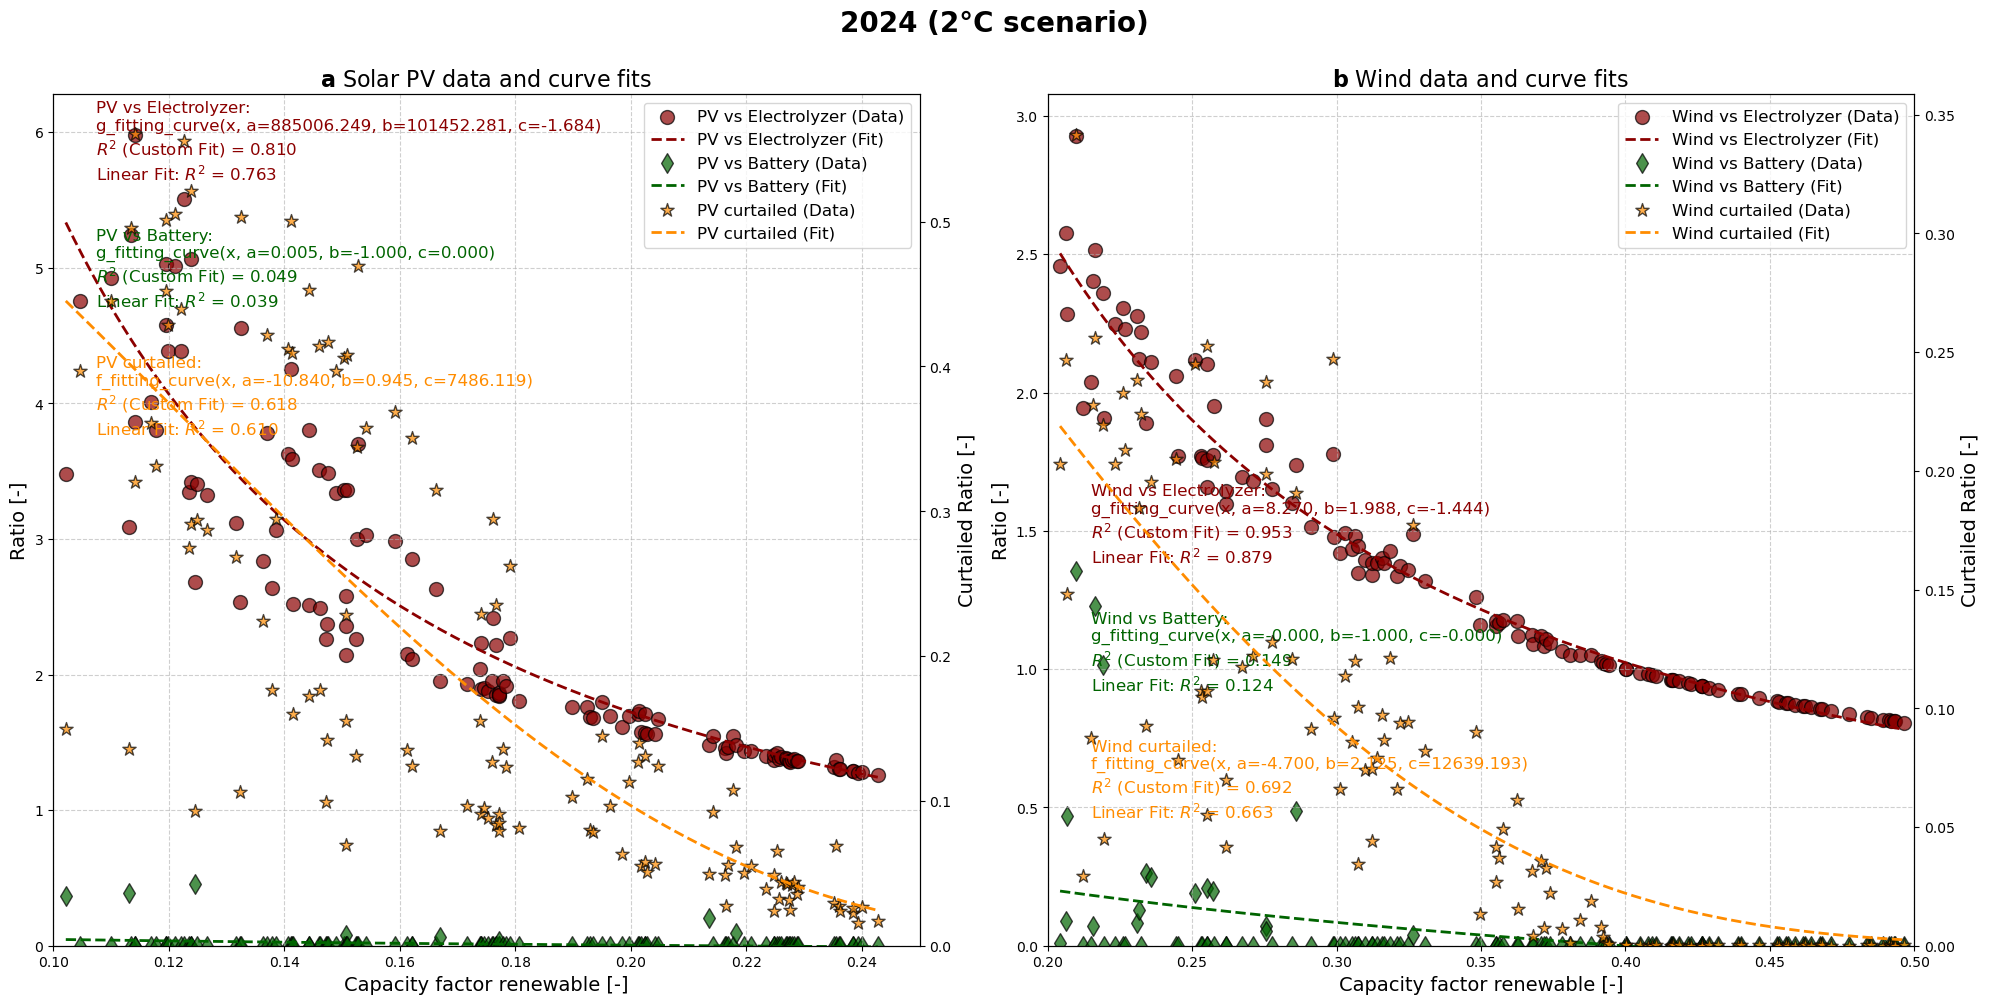

<Figure size 640x480 with 0 Axes>

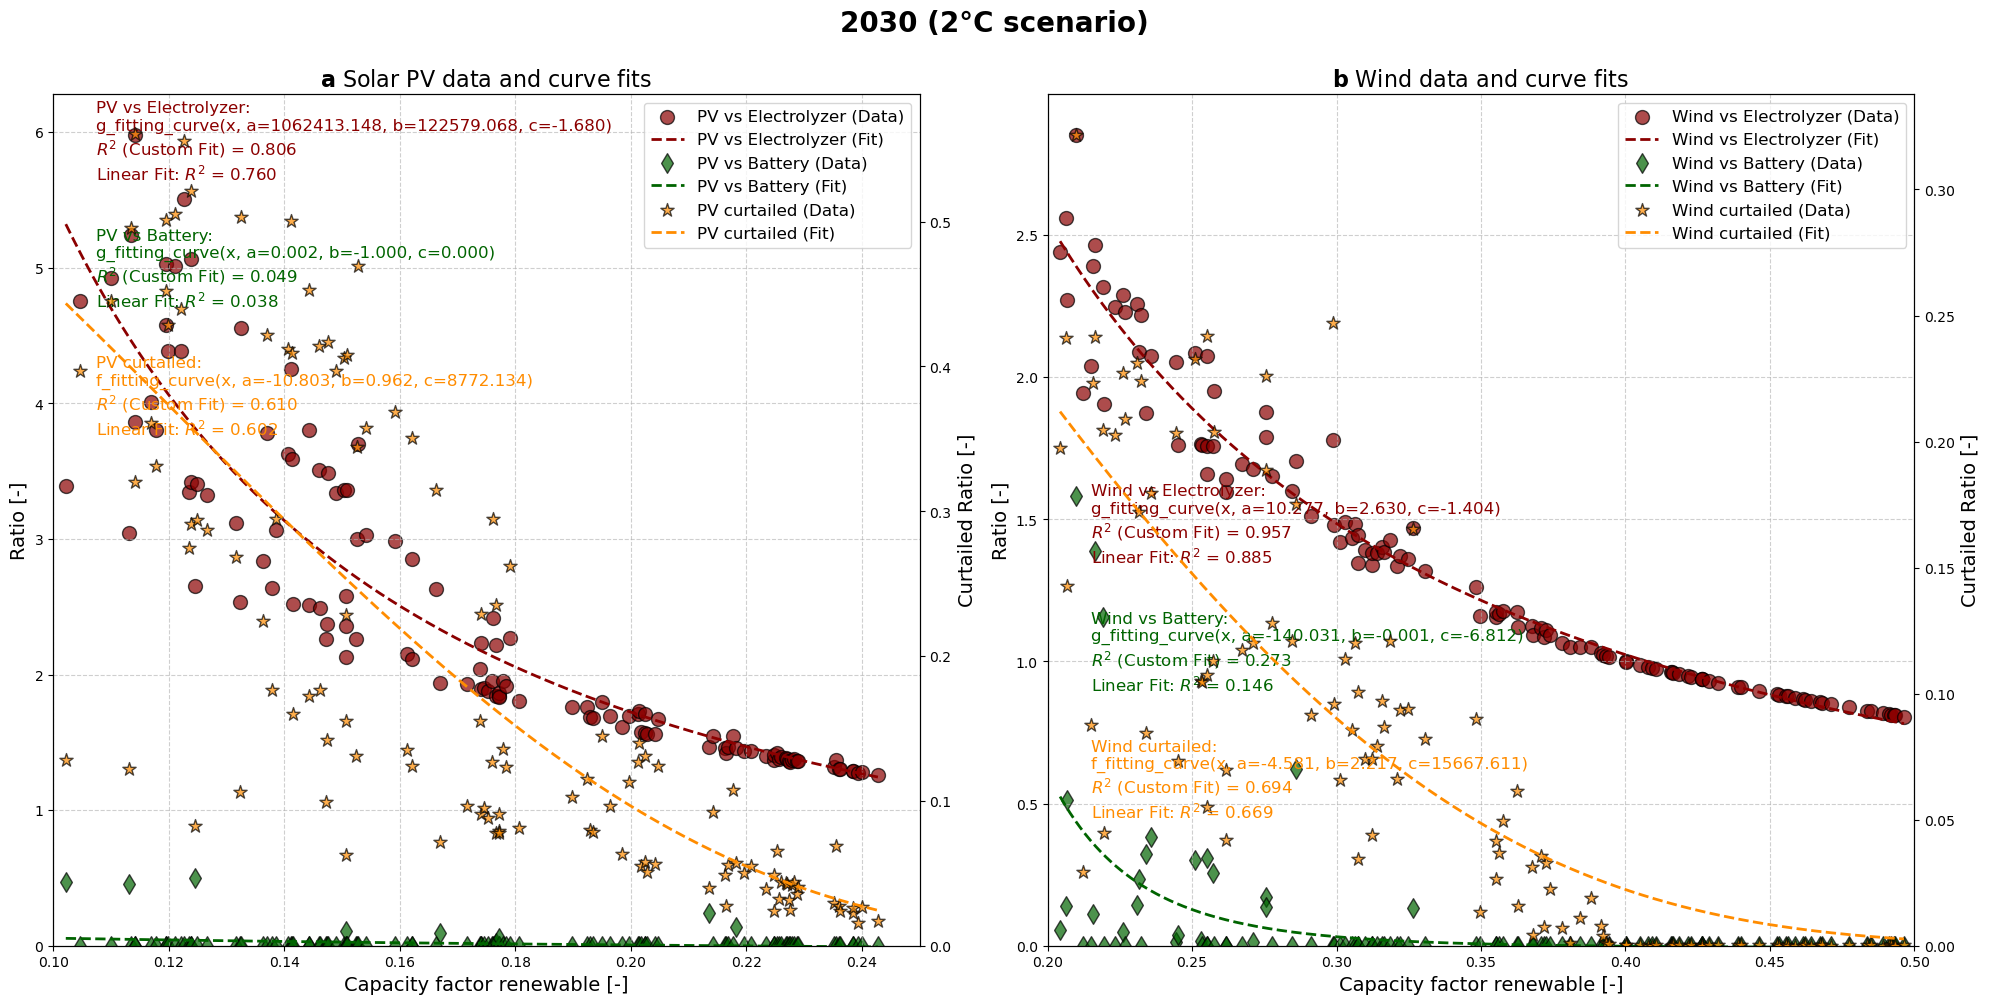

<Figure size 640x480 with 0 Axes>

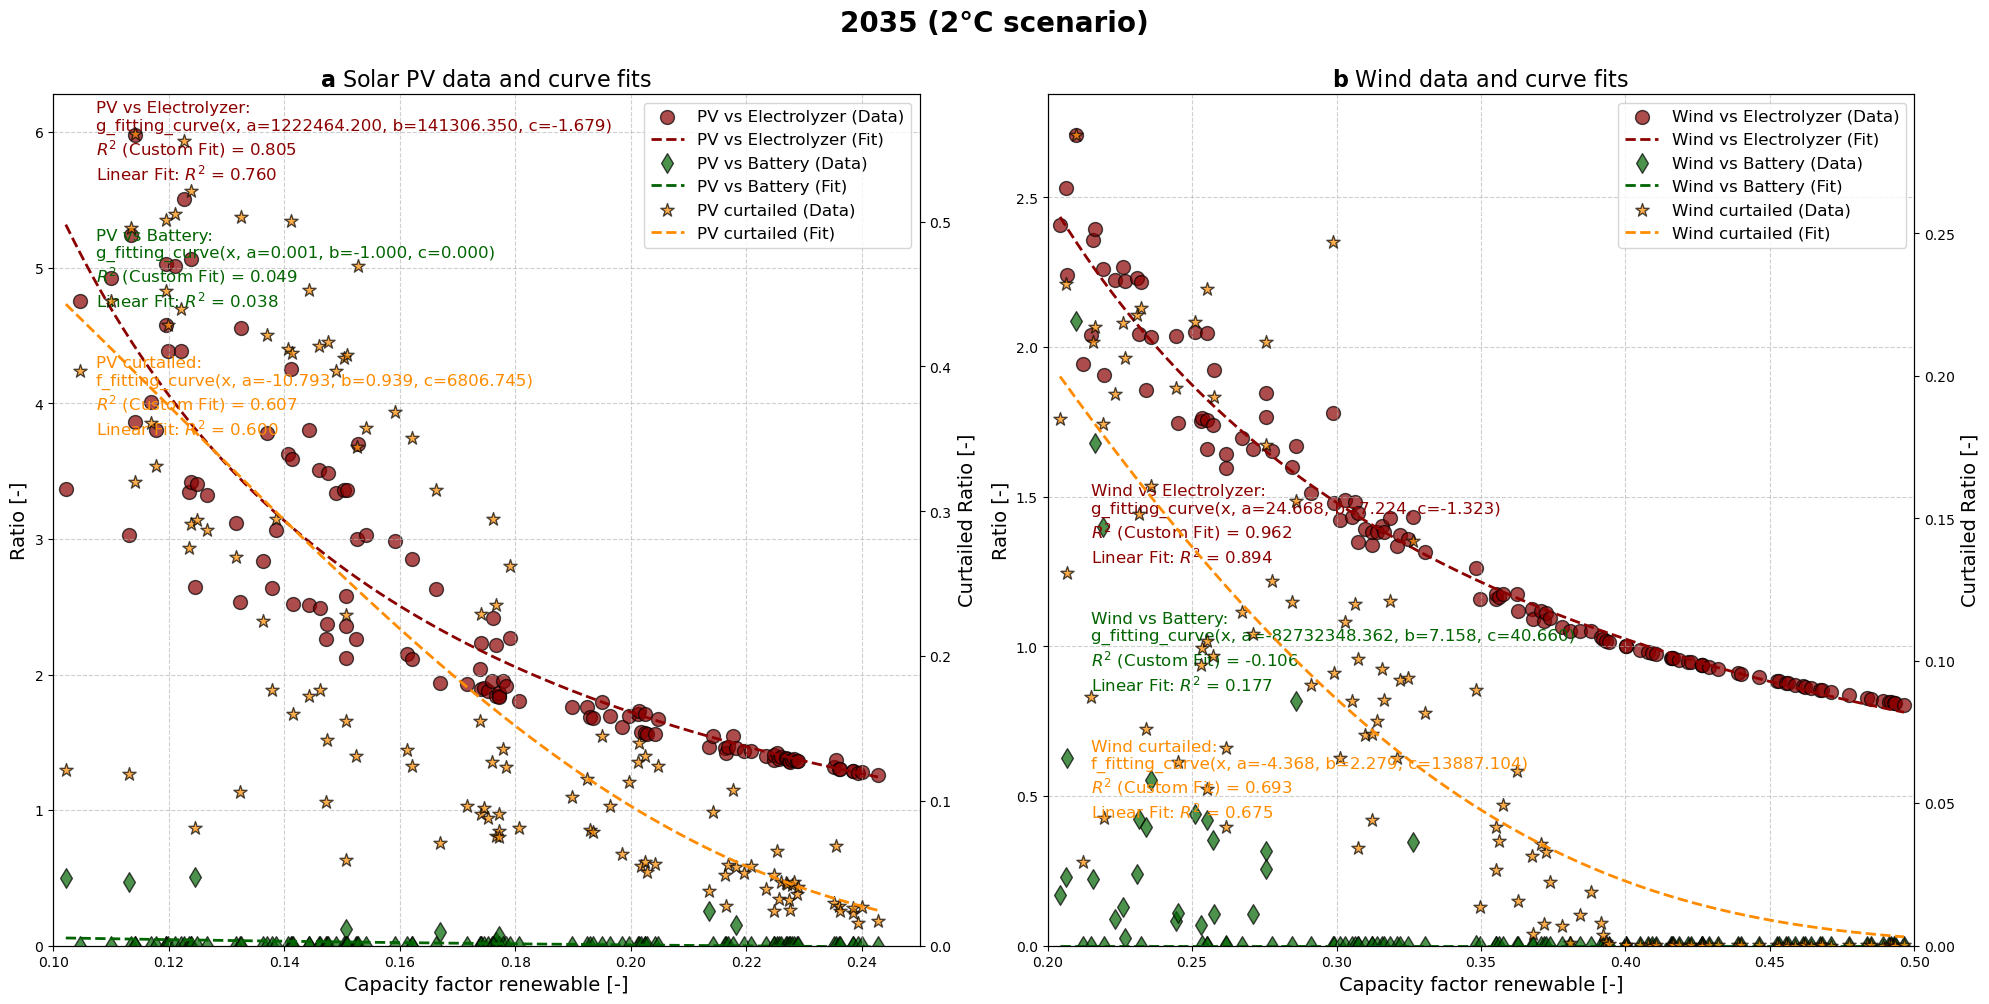

<Figure size 640x480 with 0 Axes>

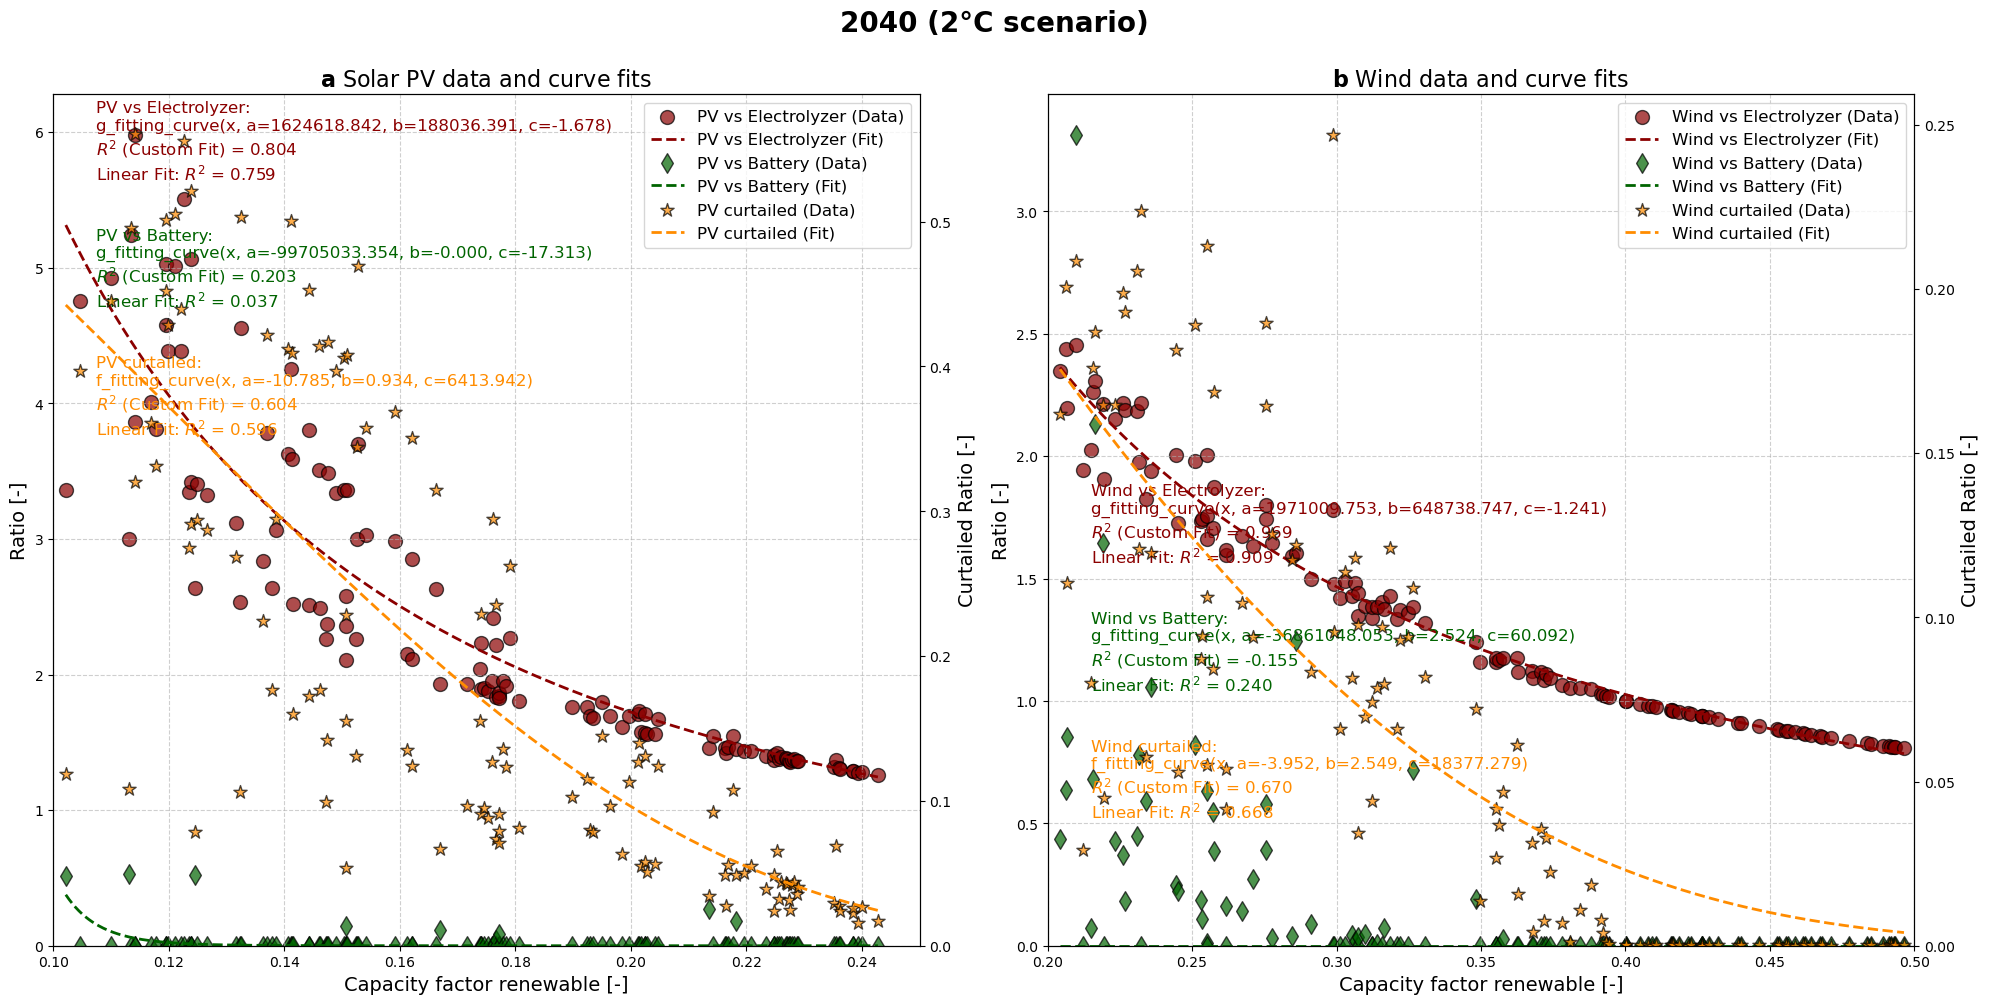

<Figure size 640x480 with 0 Axes>

In [22]:
# Define the linear function for curve fitting
def linear_fit(x, m, c):
    return m * x + c

curve_chosen = g_fitting_curve # g_fitting_curve

for db in DICT_DBS.keys():
    wind_df = df_end[df_end.index.get_level_values('config').str.contains('wind') & 
                    df_end.index.get_level_values('database').str.contains(db)].sort_values(by='cf_wind_on', ascending=True)
    solar_df = df_end[df_end.index.get_level_values('config').str.contains('solar') & 
                    df_end.index.get_level_values('database').str.contains(db)].sort_values(by='cf_pv', ascending=True)

    # Define the data pairs with custom aesthetics
    data_pairs = [
        (solar_df.cf_pv, solar_df.ratio_pv_electrolyzer, 'PV vs Electrolyzer', 'o', 'darkred', curve_chosen),
        (solar_df.cf_pv, solar_df.ratio_battery_pv, 'PV vs Battery', 'd', 'darkgreen', curve_chosen),
        (solar_df.cf_pv, solar_df.ratio_pv_curtailed, 'PV curtailed', '*', 'darkorange', f_fitting_curve),
        (wind_df.cf_wind_on, wind_df.ratio_wind_electrolyzer, 'Wind vs Electrolyzer', 'o', 'darkred', curve_chosen),
        (wind_df.cf_wind_on, wind_df.ratio_battery_wind, 'Wind vs Battery', 'd', 'darkgreen', curve_chosen),
        (wind_df.cf_wind_on, wind_df.ratio_wind_curtailed_on, 'Wind curtailed', '*', 'darkorange', f_fitting_curve)
    ]

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10), sharex=False)

    # Create secondary y-axes
    ax1_sec = ax1.twinx()
    ax2_sec = ax2.twinx()

    # Plotting for PV data
    for i, (x, y, label, marker, color, fit_func) in enumerate(data_pairs):
        if 'curtailed' not in label and 'Wind' not in label:
            ax1.scatter(x, y, label=f'{label} (Data)', marker=marker, color=color, s=100, alpha=0.7, edgecolor='black')

            try:
                # Fit the custom curve
                popt, _ = curve_fit(fit_func, x, y, maxfev=10000, p0=[1, 1, 1])

                # Generate x values for the fitted curve
                x_fit = np.linspace(min(x), max(x), 500)

                # Calculate y values using the fitted function
                y_fit = fit_func(x_fit, *popt)

                # Plot the fitted curve
                ax1.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=2, label=f'{label} (Fit)')

                # Calculate R-squared for the custom fit
                residuals = y - fit_func(x, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((y - np.mean(y))**2)
                r_squared_custom = 1 - (ss_res / ss_tot)

                # Fit and plot the linear model
                popt_linear, _ = curve_fit(linear_fit, x, y)
                y_fit_linear = linear_fit(x_fit, *popt_linear)
                #ax1.plot(x_fit, y_fit_linear, color=color, linestyle=':', linewidth=2, label=f'{label} (Linear Fit)')

                # Calculate R-squared for the linear fit
                residuals_linear = y - linear_fit(x, *popt_linear)
                ss_res_linear = np.sum(residuals_linear**2)
                r_squared_linear = 1 - (ss_res_linear / ss_tot)

                # Add the fitting function formula and R-squared as a text annotation
                fit_equation = (
                    f"{label}:\n"
                    f"{fit_func.__name__}(x, a={popt[0]:.3f}, b={popt[1]:.3f}, c={popt[2]:.3f})\n"
                    f"$R^2$ (Custom Fit) = {r_squared_custom:.3f}\n"
                    f"Linear Fit: $R^2$ = {r_squared_linear:.3f}"
                )
                ax1.text(0.05, 0.9 - 0.15 * i, 
                         fit_equation, color=color, fontsize=12, transform=ax1.transAxes)

            except RuntimeError as e:
                print(f"Could not fit curve for {label}: {e}")
                # Generate x values for the fitted curve
                x_fit = np.linspace(min(x), max(x), 500)
                # Fit and plot the linear model
                popt_linear, _ = curve_fit(linear_fit, x, y)
                y_fit_linear = linear_fit(x_fit, *popt_linear)
                #ax1.plot(x_fit, y_fit_linear, color=color, linestyle=':', linewidth=2, label=f'{label} (Linear Fit)')
                # Add the fitting function formula and R-squared as a text annotation
                fit_equation = (
                    f"{label}:\n"
                    f"Linear Fit: $R^2$ = {r_squared_linear:.3f}"
                )
                ax1.text(0.05, 0.9 - 0.15 * i, 
                         fit_equation, color=color, fontsize=12, transform=ax1.transAxes)

    # Plotting for Wind data
    for i, (x, y, label, marker, color, fit_func) in enumerate(data_pairs):
        if 'curtailed' not in label and 'PV' not in label:
            ax2.scatter(x, y, label=f'{label} (Data)', marker=marker, color=color, s=100, alpha=0.7, edgecolor='black')

            try:
                # Fit the custom curve
                popt, _ = curve_fit(fit_func, x, y, maxfev=10000, p0=[1, 1, 1])

                # Generate x values for the fitted curve
                x_fit = np.linspace(min(x), max(x), 500)

                # Calculate y values using the fitted function
                y_fit = fit_func(x_fit, *popt)

                # Plot the fitted curve
                ax2.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=2, label=f'{label} (Fit)')

                # Calculate R-squared for the custom fit
                residuals = y - fit_func(x, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((y - np.mean(y))**2)
                r_squared_custom = 1 - (ss_res / ss_tot)

                # Fit and plot the linear model
                popt_linear, _ = curve_fit(linear_fit, x, y)
                y_fit_linear = linear_fit(x_fit, *popt_linear)
                #ax2.plot(x_fit, y_fit_linear, color=color, linestyle=':', linewidth=2, label=f'{label} (Linear Fit)')

                # Calculate R-squared for the linear fit
                residuals_linear = y - linear_fit(x, *popt_linear)
                ss_res_linear = np.sum(residuals_linear**2)
                r_squared_linear = 1 - (ss_res_linear / ss_tot)

                # Add the fitting function formula and R-squared as a text annotation
                fit_equation = (
                    f"{label}:\n"
                    f"{fit_func.__name__}(x, a={popt[0]:.3f}, b={popt[1]:.3f}, c={popt[2]:.3f})\n"
                    f"$R^2$ (Custom Fit) = {r_squared_custom:.3f}\n"
                    f"Linear Fit: $R^2$ = {r_squared_linear:.3f}"
                )
                ax2.text(0.05, 0.9 - 0.15 * i, 
                         fit_equation, color=color, fontsize=12, transform=ax2.transAxes)

            except RuntimeError as e:
                print(f"Could not fit curve for {label}: {e}")
                # Generate x values for the fitted curve
                x_fit = np.linspace(min(x), max(x), 500)
                # Fit and plot the linear model
                popt_linear, _ = curve_fit(linear_fit, x, y)
                y_fit_linear = linear_fit(x_fit, *popt_linear)
                #ax2.plot(x_fit, y_fit_linear, color=color, linestyle=':', linewidth=2, label=f'{label} (Linear Fit)')
                # Add the fitting function formula and R-squared as a text annotation
                fit_equation = (
                    f"{label}:\n"
                    f"Linear Fit: $R^2$ = {r_squared_linear:.3f}"
                )
                ax2.text(0.05, 0.9 - 0.15 * i, 
                         fit_equation, color=color, fontsize=12, transform=ax2.transAxes)

    # Plotting curtailed data on secondary y-axes
    for i, (x, y, label, marker, color, fit_func) in enumerate(data_pairs):
        if 'curtailed' in label and 'PV' in label:
            ax1_sec.scatter(x, y, label=f'{label} (Data)', marker=marker, color=color, s=100, alpha=0.7, edgecolor='black')

            try:
                # Fit the custom curve
                popt, _ = curve_fit(fit_func, x, y, maxfev=10000, p0=[1, 1, 1])

                # Generate x values for the fitted curve
                x_fit = np.linspace(min(x), max(x), 500)

                # Calculate y values using the fitted function
                y_fit = fit_func(x_fit, *popt)

                # Plot the fitted curve
                ax1_sec.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=2, label=f'{label} (Fit)')

                # Calculate R-squared for the custom fit
                residuals = y - fit_func(x, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((y - np.mean(y))**2)
                r_squared_custom = 1 - (ss_res / ss_tot)

                # Fit and plot the linear model
                popt_linear, _ = curve_fit(linear_fit, x, y)
                y_fit_linear = linear_fit(x_fit, *popt_linear)
                #ax1_sec.plot(x_fit, y_fit_linear, color=color, linestyle=':', linewidth=2, label=f'{label} (Linear Fit)')

                # Calculate R-squared for the linear fit
                residuals_linear = y - linear_fit(x, *popt_linear)
                ss_res_linear = np.sum(residuals_linear**2)
                r_squared_linear = 1 - (ss_res_linear / ss_tot)

                # Add the fitting function formula and R-squared as a text annotation
                fit_equation = (
                    f"{label}:\n"
                    f"{fit_func.__name__}(x, a={popt[0]:.3f}, b={popt[1]:.3f}, c={popt[2]:.3f})\n"
                    f"$R^2$ (Custom Fit) = {r_squared_custom:.3f}\n"
                    f"Linear Fit: $R^2$ = {r_squared_linear:.3f}"
                )
                ax1_sec.text(0.05, 0.9 - 0.15 * i, 
                             fit_equation, color=color, fontsize=12, transform=ax1_sec.transAxes)
                
                df_result.loc[('ratio_pv_curtailed',db), 'a'] = popt[0]
                df_result.loc[('ratio_pv_curtailed',db), 'b'] = popt[1]
                df_result.loc[('ratio_pv_curtailed',db), 'c'] = popt[2]

            except RuntimeError as e:
                print(f"Could not fit curve for {label}: {e}")
                # Generate x values for the fitted curve
                x_fit = np.linspace(min(x), max(x), 500)
                # Fit and plot the linear model
                popt_linear, _ = curve_fit(linear_fit, x, y, maxfev=100)
                y_fit_linear = linear_fit(x_fit, *popt_linear)
                #ax1_sec.plot(x_fit, y_fit_linear, color=color, linestyle=':', linewidth=2, label=f'{label} (Linear Fit)')
                # Add the fitting function formula and R-squared as a text annotation
                fit_equation = (
                    f"{label}:\n"
                    f"Linear Fit: $R^2$ = {r_squared_linear:.3f}"
                )
                ax1_sec.text(0.05, 0.9 - 0.15 * i, 
                             fit_equation, color=color, fontsize=12, transform=ax1_sec.transAxes)

        elif 'curtailed' in label and 'Wind' in label:
            ax2_sec.scatter(x, y, label=f'{label} (Data)', marker=marker, color=color, s=100, alpha=0.7, edgecolor='black')

            try:
                # Fit the custom curve
                popt, _ = curve_fit(fit_func, x, y, maxfev=10000, p0=[1, 1, 1])

                # Generate x values for the fitted curve
                x_fit = np.linspace(min(x), max(x), 500)

                # Calculate y values using the fitted function
                y_fit = fit_func(x_fit, *popt)

                # Plot the fitted curve
                ax2_sec.plot(x_fit, y_fit, color=color, linestyle='--', linewidth=2, label=f'{label} (Fit)')

                # Calculate R-squared for the custom fit
                residuals = y - fit_func(x, *popt)
                ss_res = np.sum(residuals**2)
                ss_tot = np.sum((y - np.mean(y))**2)
                r_squared_custom = 1 - (ss_res / ss_tot)

                # Fit and plot the linear model
                popt_linear, _ = curve_fit(linear_fit, x, y)
                y_fit_linear = linear_fit(x_fit, *popt_linear)
                #ax2_sec.plot(x_fit, y_fit_linear, color=color, linestyle=':', linewidth=2, label=f'{label} (Linear Fit)')

                # Calculate R-squared for the linear fit
                residuals_linear = y - linear_fit(x, *popt_linear)
                ss_res_linear = np.sum(residuals_linear**2)
                r_squared_linear = 1 - (ss_res_linear / ss_tot)

                # Add the fitting function formula and R-squared as a text annotation
                fit_equation = (
                    f"{label}:\n"
                    f"{fit_func.__name__}(x, a={popt[0]:.3f}, b={popt[1]:.3f}, c={popt[2]:.3f})\n"
                    f"$R^2$ (Custom Fit) = {r_squared_custom:.3f}\n"
                    f"Linear Fit: $R^2$ = {r_squared_linear:.3f}"
                )
                ax2_sec.text(0.05, 0.9 - 0.15 * i, 
                             fit_equation, color=color, fontsize=12, transform=ax2_sec.transAxes)
                
                df_result.loc[('ratio_wind_curtailed_on',db), 'a'] = popt[0]
                df_result.loc[('ratio_wind_curtailed_on',db), 'b'] = popt[1]
                df_result.loc[('ratio_wind_curtailed_on',db), 'c'] = popt[2]

            except RuntimeError as e:
                print(f"Could not fit curve for {label}: {e}")
                # Generate x values for the fitted curve
                x_fit = np.linspace(min(x), max(x), 500)
                # Fit and plot the linear model
                popt_linear, _ = curve_fit(linear_fit, x, y, maxfev=100)
                y_fit_linear = linear_fit(x_fit, *popt_linear)
                ax2_sec.plot(x_fit, y_fit_linear, color=color, linestyle=':', linewidth=2, label=f'{label} (Linear Fit)')
                # Add the fitting function formula and R-squared as a text annotation
                fit_equation = (
                    f"{label}:\n"
                    f"Linear Fit: $R^2$ = {r_squared_linear:.3f}"
                )
                ax2_sec.text(0.05, 0.9 - 0.15 * i, 
                             fit_equation, color=color, fontsize=12, transform=ax2_sec.transAxes)
                

    # Set labels and titles
    ax1.set_xlabel('Capacity factor renewable [-]', fontsize=14)
    ax1.set_ylabel('Ratio [-]', fontsize=14)
    ax1.set_title(r'$\bf{a}$ Solar PV data and curve fits', fontsize=16)
    ax1.set_xlim(0.10, 0.25)
    ax1.set_ylim(0,)
    ax1_sec.set_ylim(0,)
    ax1_sec.set_ylabel('Curtailed Ratio [-]', fontsize=14, color='black')

    ax2.set_xlabel('Capacity factor renewable [-]', fontsize=14)
    ax2.set_ylabel('Ratio [-]', fontsize=14)
    ax2.set_title(r'$\bf{b}$ Wind data and curve fits', fontsize=16)
    ax2.set_xlim(0.20, 0.50)
    ax2.set_ylim(0,)
    ax2_sec.set_ylim(0,)
    ax2_sec.set_ylabel('Curtailed Ratio [-]', fontsize=14, color='black')

    # Add grids
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax2.grid(True, linestyle='--', alpha=0.6)

    # Add legends to each subplot
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines1_sec, labels1_sec = ax1_sec.get_legend_handles_labels()
    ax1.legend(lines1 + lines1_sec, labels1 + labels1_sec, fontsize=12)

    lines2, labels2 = ax2.get_legend_handles_labels()
    lines2_sec, labels2_sec = ax2_sec.get_legend_handles_labels()
    ax2.legend(lines2 + lines2_sec, labels2 + labels2_sec, fontsize=12)
    title_sup = DICT_DBS[db].replace("Ref.", "2024")
    plt.suptitle(f"{title_sup} (2°C scenario)", fontsize =20, weight='bold', y=1.00)

    # Adjust layout to prevent overlap
    plt.tight_layout(pad=1.1)  # Adjust the pad value as necessary

    # Show the plot
    plt.savefig("figs/sizing_{}".format(db), tight_layout=True)
    plt.show()
    plt.clf()
    
df_result.to_excel(r"data\results_curve_fits_wind_hydrogen.xlsx")